# Unsupervised Domain Adaptation

## Introduction 

Deep neural networks can learn highly discriminative representations for image recognition tasks given a large amount of training data, but do not generalize well to novel domains. 
This issue is related to the following assumptions:
* data is abundant
* train data and test data originate from the same domain:
  * they are represented by the same features 
  *  they both follow the same distribution
However, this doesn't often occur in real-life challenges.


![](https://drive.google.com/uc?export=view&id=1mp8Hgr8voZ_ex-yseNZ6KlGrBCYzxhYq)

Collecting a large amount of annotated data in novel domains implies high annotation costs. To tackle this issue, domain adaptation transfers knowledge from a label-rich training domain adaptation to a label scarce (or even absent) novel domain [1].
Traditional unsupervised domain adaptation (UDA) assumes that the source domain and the target domain completely share the sets of categories, i.e., closed-set DA. This assumption does not often hold in practice [Saito, Saenko]. Namely, different occurences may happen: 

* Target and source domain do not share exactly the same set of categories:
  *   unknown categories: when there are target categories absent in the source domain i.e. open-set DA (ODA) [4,29];
  * source private categories: when there are source categories absent in the target domain  i.e., partial DA (PDA) [5];
* A mixture of ODA and PDA

Although several different approaches have been tailored for each specific setting, the main limit to overcome is the impossibility to determine the category shift beforehand.


This project exclusively focuses on UDA: the proposed solution aims to reduce the **domain shift** as much as possible, while still assuming a shared label space. 
Domain shift is defined as a change in the data distribution between an algorithm's training dataset and the one it encounters when deployed. This issue can be ubiquitous, and find its main causes in:
* Differences in time or in environments: E.g; sunny vs rainy, day vs night
*  Different modalities: E.g: real images vs CAD images.

![](https://drive.google.com/uc?export=view&id=11Q1wfw9cnfkqCw0D7HP70ThaIl9K5NYm)

When facing domain shift, deep learning algorithms' performance suffers on test data. Additionally, in some CV tasks, minimizing this issue is crucial for real-life applications such as autonomous driving cars.
To overcome domain shift, there are typically two main approaches: 
* Fine - tuning: process taking an already trained model on a given task, and tuning it to make it perform a second similar task.
* Unsupervised Domain Adaptation (UDA): which aims to overcome the domain shift between the source and target domainsby learning a classifier that accurately classifies the unlabeled data in the target domain.



Most of the solutions which have been developed for computer vision applications -which do not have to be explicitly programmed- reach impressive performances only on tasks with vast amounts of labeled data. Moreover, collecting and annotating sufficient data for every task is prohibitively expensive and nearly impossible in many cases. 

In standard UDA it is assumed that data comes from two domains: the source and the target. Let $Ds = \{x_i^s, y_i^s\}^{n_s}_{i=1}$ be the source domain with $n_s$ labeled examples and $D_t = \{X_i^t, y_i^t\}^{n_t}_{i=1}$ be the target domain with $n_t$ labeled examples where the labels $y_i^t$ in the target domain are unknown. 

![](https://drive.google.com/uc?export=view&id=1D1K7uhYZDgBDk6jqGga5LCrPIhe5cV-d)


### Task 

The following analysis will present the domain shift problem while performing object recognition. To do so, the __Adaptiope__ dataset will be used, from which two domains out of three will be considered: Real World (RW) and Product (PR) domains.  
The backbone of our idea takes input from [Unsupervised Domain Adaptation via Structurally Regularized Deep Clustering](https://arxiv.org/abs/2003.08607). 


A function  $F_θ : X → Y$ is learned, with parameters θ, mapping an input image $X$ to a class label $y$ and performing better on target data. Namely, we are going to
* train our model supervisedly on the source domain, i.e. having access to the images as well as the object labels
* train our model unsupervisedly on the training set of the target domain, i.e. having access to the images, but not to the labels
* evaluate our model on the test set of our target domain

The starting point will be setting a baseline which will be computed by training on the source domain and testing on the target domain.
The backbone of the baseline model is ResNet18, to which no particular changes have been applied besides on the fully connected layer. Namely, instead of keeping the last ResNet18 layers, which have been trained on ImageNet, two new linear layers have been adopted with an additional Dropout layer to enforce learning difficulty. These changes have been applied for the classification to be dataset agnostic.  
Successively,the proposed solution will be applied on both directions: 
* Product → Real World
* Real World → Product

Next, an SRDC (Structurally Regularized Deep Clustering) algorithm will be applied, consisting in a joint training of an autoencoder together with K-means clustering. The idea behind this proposal is to indirectly uncover the intrinsic differences of the target domain and align similar features, while exploiting the information provided by the labeled source domain ([Tang, Chen, Jia, 2020](https://arxiv.org/abs/2003.08607)).

### Overview 

There are three basic techniques for unsupervised domain adaptation: discrepancy, adversarial and reconstruction - based: 

* __Discrepancy-Based__: some divergence criterion between the source and target data distributions is minimized (E.g; MMD, Coral, CCD), thus achieving a domain-invariant feature representation. The main assumption here is that such a representation exists, which in turn assumes a some kind of relation among tasks.
* __Adversarial-Based__: adversarial training is used to achieve domain adaptation. For instance, one approach is to generate synthetic target data which are somehow related to the source domain using Generative Adversarial Networks (GANs). These synthetic data are then used to the train the target model.
* __Reconstruction-Based__: this approach uses an auxiliary reconstruction task to create a shared representation for each of the domains. This ensures that the network learns not only to discriminate correctly but also preserves information about the target data.

However, as the analysis' SRDC reference paper states, among these mainstream UDA methods, some fail in retaining the intrinsic discrimination of the target data, as the main goal is to learn __aligned__ features between the two domains, such that a classifier trained on the source features can be readily applied to the target ones ([Tang, Chen, Jia, 2020](https://arxiv.org/abs/2003.08607). To alleviate this risk, authors proposed to directly uncover this intrinsic target discrimination via discriminative clustering of target data, where clustering solutions are constrained to using structural source regularization conditioned on the _assumed structural domain similarity_. 


To pursue this goal, a flexible framework of deep network based discriminative clustering is used, in which the Kullback–Leibler(KL) divergence between the predicted label distribution, and an introduced auxiliary one, is minimized. When handling source data, its aforementioned auxiliary distribution is replaced with the ground-truth labels distribution in order to pursue structural source regularization. Additionally, clustering of intermediate network features, combined with structural regularization with soft selection of less divergent source examples, helps enhance target discrimination. 
According to the authors, results obtained with this approach outperform all existing methods on the three UDA benchmarks.

## Code

The following analysis can be split in three main chunks: 

+ Data loading
+ Baseline definition (ResNet18) according to our computational power (while keeping the values form the original assignment in mind).
+ UDA proposal via simplified soft-KMEANS
+ UDA proposal via simplified SRDC
+ Results comparison and further annotations  
 

### Data

The preliminary stage of the project requires to load the available datasets and divide each category into different folders. Then, augmentation is applied on the dataset to improve model performance by enhancing training difficulty of the baseline. As many studies have proven [(Perez, Wang 2017)](https://arxiv.org/pdf/1712.04621.pdf),  [(Mikołajczyk, Grochowski et al 2018)](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8388338), [(Xu, et al., 2016)](https://arxiv.org/pdf/1601.03651.pdf), data augmentation enhances data classification performances. On a side note, it is relevant to highlight that not all images have been transformed: many different images have been additionally created to enhance the already available dataset. The following transformations were applied
<br>
* _Color modification_, including random gray scale, random invert, and random autocontrast; 
* _Image rotation_, to change the placement of our object during classifcation;
* _Random vertifcal flip_ for the same reason as above;
* _Image normalization_ to ensure that each input parameter follow a similar distribution so that the convergence can be faster during training. 

#### Data Loading

In [ ]:
# REQUIRED LIBRARIES 

import torch
import torchvision
import torch.nn as nn
from itertools import cycle
from torchvision.utils import save_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from google.colab import drive
from torchvision import transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from torch.utils.data.dataset import Subset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from google.colab import drive
from pathlib import Path
import numpy as np
import cv2
from torch import optim
from typing import Optional, Sequence
from torch.optim.lr_scheduler import StepLR
from shutil import copy
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# HIDE WARNINGS 

import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy.random import uniform
from sklearn.datasets import make_blobs
import seaborn as sns
import random
import numpy as np
warnings.filterwarnings('ignore')

In [ ]:
path_pr= "/content/drive/MyDrive/DL_Project/Data/product_images" #retrieving the main content of product
path_rw = "/content/drive/MyDrive/DL_Project/Data/real_life" #retrieving the main content of real world
device = torch.device('cuda:0')

In [ ]:
lst_pr = os.listdir(path_pr) #setting to list to ease the merging of different folders
lst_rw = os.listdir(path_rw)
lst_pr.sort() 
lst_rw.sort() #sorting for easier retrieval 

print(len(lst_pr) == len(lst_rw)) #checking they both have the same number of folders 

True


In [ ]:
print('Produt images: {}'.format(lst_pr))
print('__________________________________________________________________\n')
print('Real life: {}'.format(lst_rw))

Produt images: ['backpack', 'bookcase', 'car jack', 'comb', 'crown', 'file cabinet', 'flat iron', 'game controller', 'glasses', 'helicopter', 'ice skates', 'letter tray', 'monitor', 'mug', 'network switch', 'over-ear headphones', 'pen', 'purse', 'stand mixer', 'stroller']
__________________________________________________________________

Real life: ['backpack', 'bookcase', 'car jack', 'comb', 'crown', 'file cabinet', 'flat iron', 'game controller', 'glasses', 'helicopter', 'ice skates', 'letter tray', 'monitor', 'mug', 'network switch', 'over-ear headphones', 'pen', 'purse', 'stand mixer', 'stroller']


In the following chunk of code we split our dataset into a train set and a test set for both source and target domain.


In [ ]:
def create_folders(input_path, output_path, objective) : 
  """Splits folders respectively in train and test
  following the 80-20 ratio"""
  test_ratio = 0.2
  train_ratio = 0.8
  random.seed(1234)


  total = 0 
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  if not os.path.exists(input_path):
    os.makedirs(input_path)

  if (objective) not in os.listdir(output_path):
    os.makedirs(os.path.join(output_path,objective)) 
  
  dir = os.path.join(output_path,objective)
  
    
  for folder in os.listdir(input_path) :
    print('Creating folder...')
    os.makedirs(os.path.join(dir,folder))
    
    lst_dir = os.listdir(os.path.join(input_path,folder)) 
    random.shuffle(lst_dir) #randomly shuffling 
    if objective == 'Train' :
        values = random.sample(lst_dir, int(train_ratio*len(lst_dir))+1) #sampling randomly to pick images 
      
    else :
        values = random.sample(lst_dir, int(test_ratio*len(lst_dir))+1) #sampling randomly to pick images 
  
   
        
    
    
    saving = os.path.join(dir,folder)
    n = 0
    for img in values :
      n += 1
      name_img = img
      img = Image.open(os.path.join(os.path.join(input_path,folder),img)) #opening color image
      img = img.resize(size=(224,224)) #resizing images to avoid pytorch RESIZE which zooms in. Moreover, the model trains faster on smaller images. 
      img.save(os.path.join(saving,name_img)) #saving product images - NON TRASFORMATA 
    total +=n
    print('{} images saved for {} in folder {}'.format(n, objective, folder))




In [ ]:
def create_merged(folder1, folder2): 
  dir = "/content/drive/MyDrive/DL_Project/Data/Data/Merged_train"
  if not os.path.exists(dir):
    os.makedirs(dir)
  l1 = os.listdir(folder1)
  l2 = os.listdir(folder2)
  l1.sort()
  l2.sort()

  for c1,c2 in zip(l1, l2) : ## FOLDERS ITERATION 
    print(c1 == c2)
    p1 = os.path.join(folder1,c1)
    p2 = os.path.join(folder2,c2)
    d1 = os.path.join(dir,c1)
    d2 = os.path.join(dir,c2)

    for f1,f2 in zip(os.listdir(p1),os.listdir(p2)) : ## IMAGES ITERATION
      f1_s = os.path.join(p1,f1)
      f2_s = os.path.join(p2,f2)
      ds1 = os.path.join(d1,f1).replace(".jpg", "_1.jpg")
      ds2 = os.path.join(d2,f2).replace(".jpg", "_2.jpg")

  
      img = Image.open(f1_s) 
      if not os.path.exists(d1):
        os.makedirs(d1)
       
  
      print(f"saving image to {ds1}")
      img.save(ds1)
      img = Image.open(f2_s) 
      print(f"saving image to {ds2}")
      img.save(ds2)
    

Three different datasets are created: one for Real Life, one for Products, and one with both datasets merged. This latter decision has been made due to the relevance of normalization for the algorithm that is being referenced in this assignment. It has been noticed that created models perform poorly when images are badly normalised. Thus, a very first approach was to just normalise both datasets with their respective mean and standard deviation, and merging them after. However, this caused imbalances in the normalisation, and all nets struggled to learn. Given these outcomes, a single big dataset with both real life and product is created in order to normalise it by just using one mean and standard deviation. 

In all three cases datasets have been normalized according to their own mean and standard deviation. Imagenet values were taken as main reference at first (mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]), however, images were severely non-recognizable and our reference autoencoder struggled to reconstruct them (given its simple structure), therefore a function is implemented to return mu and std each time.

In [ ]:
# PRODUCTS 
#create_folders('/content/drive/MyDrive/DL_Project/Data/product_images','/content/drive/MyDrive/DL_Project/Data/Data/PR_Folder','Train')
#create_folders('/content/drive/MyDrive/DL_Project/Data/product_images','/content/drive/MyDrive/DL_Project/Data/Data/PR_Folder','Test')

# REAL LIFE
#create_folders('/content/drive/MyDrive/DL_Project/Data/real_life','/content/drive/MyDrive/DL_Project/Data/Data/RL_Folder','Train')
#create_folders('/content/drive/MyDrive/DL_Project/Data/real_life','/content/drive/MyDrive/DL_Project/Data/Data/RL_Folder','Test')

## MERGED 
#create_merged("/content/drive/MyDrive/DL_Project/Data/Data/PR_Folder/Train","/content/drive/MyDrive/DL_Project/Data/Data/RL_Folder/Train")

In [ ]:
def return_mu_std(train_path, batch_size) : 
     """DATA NORMALIZATION WITH THE ACTUAL MU AND STD OF THE DATASET"""
     compiler= list()
     compiler.append(T.ToTensor())
     compiler = T.Compose(compiler) 
     train = torchvision.datasets.ImageFolder(train_path, transform=compiler) 
     train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,  #train iterator
                                           num_workers=4, drop_last=True, shuffle=True) 
     channels_sum, channels_squared_sum, num_batches = 0, 0, 0
     for data, _ in train_loader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
     mean = channels_sum / num_batches

     # std = sqrt(E[X^2] - (E[X])^2)
     std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

     return mean, std


In [ ]:
class Img_augmenter() :
  """ Instantiation of different tranformations for img augmentation"""

  def __init__(self, train_path:str, test_path:str,  batch_size,transf) :
    self.compiler = list()
    self.train_path = train_path
    self.test_path = test_path
    self.transf = transf
    self.batch =  batch_size
    self.mean, self.std = return_mu_std(self.train_path,self.batch)
 

  def transformations_train(self) : 

    """Set of transformations:
        - Randomhorizontalflip
        - RandomGrayscale
        - Resize to ensure correct dimension
        - RandomAutocontrast
        - RandomVerticalflip
        - RandomInvert
      Returns the compiled set of transformations
      probabilities are set to very low as the number of images in the folders is not that high.
      Augmentation for the training dataset"""
  
    compiler = list()
    print('Compiling transformations....')
    compiler.append(T.ToTensor())
    if self.transf  == True:
 
     
   
      compiler.append(T.RandomHorizontalFlip(0.4)) #horizontally flipping the picture 1 over 2 times
    
      compiler.append(T.RandomGrayscale(0.02)) #scaling to gray with 0.02 prop
      compiler.append(T.RandomInvert(0.02)) #randomly inverting the colors of an image, low probability of 0.02
      compiler.append(T.RandomRotation(30)) #randomly rotate the image of 30°
      compiler.append(T.RandomAutocontrast(0.01)) #randomly p=0.01 autocontrast the pixels of the given image
      compiler.append(T.RandomVerticalFlip(0.055)) #randomly flip the image vertically
      compiler.append(T.Normalize(mean=self.mean,  #normalization with values from given function
                                std=self.std))
     
      
    else : # No transformations are required for the test dataset besides normalization
      compiler= list()
      compiler.append(T.ToTensor())
      compiler.append(T.Normalize(mean=self.mean, 
                                std=self.std))
    

    self.compiler = compiler 
    self.compiler = T.Compose(self.compiler)
      
    return self.compiler


  def transformations_none(self) :
    """Additional non-transformed images are added to enhance the dataset"""

    compiler= list()
    compiler.append(T.ToTensor())
    compiler.append(T.Normalize(mean=self.mean, 
                                std=self.std))
    self.compiler = compiler 
    self.compiler = T.Compose(self.compiler) 

    return self.compiler

  def transformations_none_rotation(self) : 
    """Additional, slightly transformed images are added to enhance the dataset"""
    compiler= list()
    compiler.append(T.ToTensor())
    compiler.append(T.RandomRotation(60))
    compiler.append(T.Normalize(mean=self.mean, #Using imagenet values due to the few images in the dataset of adaptiope
                                std=self.std))
    self.compiler = compiler 
    self.compiler = T.Compose(self.compiler) 

    return self.compiler


  
  def image_folders(self) :

    """Loads the datasets"""

    train = torchvision.datasets.ImageFolder(self.train_path, transform=self.transformations_train()) #transformed dataset flips/colors etc.
    train_2 = torchvision.datasets.ImageFolder(self.train_path, transform=self.transformations_none()) #transformed dataset only normalisation
    train_3 = torchvision.datasets.ImageFolder(self.train_path, transform=self.transformations_none_rotation()) #transformed dataset only to tensor

    l = []
    l.append(train)
    l.append(train_2)
    l.append(train_3)
    train = torch.utils.data.ConcatDataset(l)
    # A dataset composed by three different ImageFolders is composed with 3x more images than before for better training of the autoencoder
    try:
      test = torchvision.datasets.ImageFolder(self.test_path, transform=self.transformations_none()) #non-transformed
      return train, test
    except:
      return train
    
    


  
  def DataLoader(self) : 

    """Implements dataloader iterator"""
    try: 
      train, test = self.image_folders()
      print('________________________________')
      print('Done! Returning compiler.')
      train_loader = torch.utils.data.DataLoader(train, batch_size=self.batch,  #train iterator
                                            num_workers=4, drop_last=True, shuffle=True) 
    
      test_loader = torch.utils.data.DataLoader(test, batch_size=self.batch, #test iterator
                                            num_workers=4)
      return train_loader,  test_loader

    except: 
      train = self.image_folders()
      print('________________________________')
      print('Done! Returning compiler.')
      train_loader = torch.utils.data.DataLoader(train, batch_size=self.batch,  #train iterator
                                            num_workers=4, drop_last=True, shuffle=True) 
      return train_loader

    

In [ ]:
try: 
  test_T = "/content/drive/MyDrive/DL_Project/Data/Data/PR_Folder/Test" # train path 
  train_T = "/content/drive/MyDrive/DL_Project/Data/Data/PR_Folder/Train" # test path 
  augm_T = Img_augmenter(train_T,test_T,32,transf=True)
  test_S = "/content/drive/MyDrive/DL_Project/Data/Data/RL_Folder/Test" # train path 
  train_S = "/content/drive/MyDrive/DL_Project/Data/Data/RL_Folder/Train" # test path 
  
 
except: 
  test_T = "/content/drive/MyDrive/DL_Project/Data/PR_Folder/Test" # train path 
  train_T = "/content/drive/MyDrive/DL_Project/Data/PR_Folder/Train" # test path 
  augm_T = Img_augmenter(train_T,test_T,32,transf=True)
  test_S = "/content/drive/MyDrive/DL_Project/Data/RL_Folder/Test" # train path 
  train_S = "/content/drive/MyDrive/DL_Project/Data/RL_Folder/Train" # test path 
  
augm_T = Img_augmenter(train_T,test_T,32,transf=True) # test path 

augm_S = Img_augmenter(train_S,test_S,32,transf=True)
trainl, testl = augm_S.DataLoader() # loading three different data loaders: one for training, one for testing and one for validation. 


# MERGING BOTH DATASET FOR JOINT TRAINING
train_M = "/content/drive/MyDrive/DL_Project/Data/Data/Merged_train"
augm_M = Img_augmenter(train_M,test_T,32,transf=True) 
trainl_M = augm_M.DataLoader()

Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.


In the following chunk of code we display a grid of augmented images. 

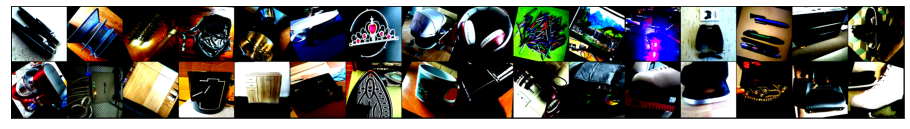

In [ ]:
def show_transformed_batch(dl): #From https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(images,nrow=16).permute(1,2,0)) 
        break
# RL after normalization and data augmentation         
show_transformed_batch(trainl)



tensor([0.7956, 0.7843, 0.7815]) tensor([0.3113, 0.3186, 0.3205])
Compiling transformations....
________________________________
Done! Returning compiler.


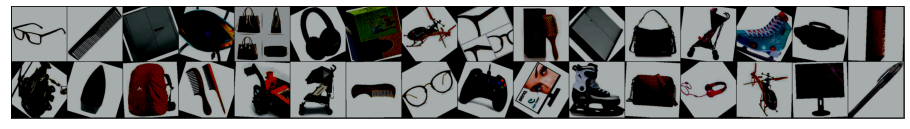

In [ ]:
try: 
  test = "/content/drive/MyDrive/DL_Project/Data/Data/PR_Folder/Test" # train path 
  train = "/content/drive/MyDrive/DL_Project/Data/Data/PR_Folder/Train" # test path 
  augm = Img_augmenter(train,test,32,transf=True)
  trainl_rl, testl_rl = augm.DataLoader() 
except:
  test = "/content/drive/MyDrive/DL_Project/Data/PR_Folder/Test" # train path 
  train = "/content/drive/MyDrive/DL_Project/Data/PR_Folder/Train" # test path 
  augm = Img_augmenter(train,test,32,transf=True)
  trainl_rl, testl_rl = augm.DataLoader() 
  # loading three different data loaders: one for training, one for testing and one for validation. 
# PR images after normalization and data augmentation 
show_transformed_batch(trainl_rl)

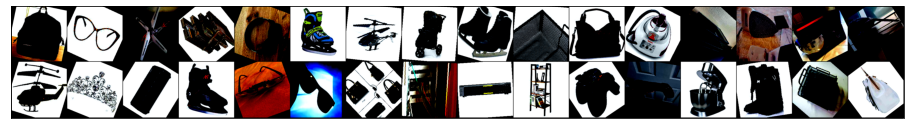

In [ ]:
# Merged dataset after normalisation and augmentation 
show_transformed_batch(trainl_M[0])

In [ ]:
import copy 

def save_model_to_path(model,path) : 
  """Saves the whole model to drive. 
  Given the low computational power this is useful at test time to load the model again"""
  best_model_state = copy.deepcopy(model.state_dict())
  torch.save(model.state_dict(), path+".pt")

def load_model_to_path(model, path) :
  """Load given model weights and parameters again"""
  model.load_state_dict(torch.load(path+".pt"), strict = False)
  print(model.load_state_dict(torch.load(path+".pt"), strict = False))
  return model
  #model eval 


def save_checkpoint(epoch, state_dict, optimizer_dict, loss, path) : 
  torch.save({"epoch": epoch,
              "model_state_dict": state_dict,
              "loss": loss,
              "optimizer_state_dict": optimizer_dict
              }, path)
  
def resume_checkpoint(model,epoch, optimizer, path, train: bool) :
  checkpoint = torch.load(path)
  print(checkpoint.keys())
  model.load_state_dict(checkpoint['model_state_dict'])
  try: 
    optimizer = optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  except:
    optimizer = optimizer
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  if (train == True) : 
    return model, optimizer, epoch
  else :
    model.eval()
    return model

In [ ]:
def switch_source_target(path_t, path_s, path_merged, bs, switched:bool) : 
    """Switches target and source datasets according to bool label"""
    if (path_t == path_s) and (path_s == path_merged) : 

      if switched == False:

        path_t = "/content/drive/MyDrive/DL_Project/Data/Data/PR_Folder"
        path_s =  "/content/drive/MyDrive/DL_Project/Data/Data/RL_Folder"
        path_merged = "/content/drive/MyDrive/DL_Project/Data/Data/Merged_train"
      else : 
        path_s = "/content/drive/MyDrive/DL_Project/Data/Data/PR_Folder"
        path_t =  "/content/drive/MyDrive/DL_Project/Data/Data/RL_Folder"
        path_merged = "/content/drive/MyDrive/DL_Project/Data/Data/Merged_train"

    ############ SOURCE AND TARGET #################
    test_T = os.path.join(path_t,"Test") 
    train_T = os.path.join(path_s,"Train")  

  
    test_S = os.path.join(path_s,"Test") 
    train_S = os.path.join(path_t,"Train")
  
 
    augm_S = Img_augmenter(train_T,test_T,bs,transf=True) 
    augm_T = Img_augmenter(train_T,test_T,bs,transf=True)

    train_source,test_target = augm_S.DataLoader() # loading three different data loaders: one for training, one for testing 

    # MERGING BOTH DATASET FOR JOINT TRAINING

    augm_M = Img_augmenter(path_merged,test_T,bs,transf=True) 
    trainl_M = augm_M.DataLoader()
  
    return train_source,test_target, trainl_M


  

In [ ]:
def accuracy(p, label) : 
  max_p = torch.argmax(p, dim = 1) 
  counts = (torch.unique(max_p[max_p == label], return_counts=True))[1]
 

  return  counts.sum()/len(label)

In [ ]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

def get_optimizer(net, lr, wd, momentum):
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

In [ ]:
train_source,test_target, trainl_M = switch_source_target("","","", 8, True) ### GETTING ALL NEEEDED LOADERS   source = Product, target = Real Life 
train_target,test_source, trainl_M = switch_source_target("","","", 8, False) ### GETTING ALL NEEEDED LOADERS   source = Real Life, target = Product

Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.


### Baseline

#### ResNet18 
ResNet18 has been chosen base classifier to compute performance baselines on four different scenarios: 
* Training on the product domain images and testing on product domain images
* Training on the product domain images and testing on real world domain images 
* Training on the real world images and testing on real world images
* Training on the real world images and testing on product domain images

ResNet18 is often used as a state of the art image classification model. Its main features are listed below:
* Only 2 million parameters (using many small kernels, 1x1, 3x3)
* Identity bypass: if a layer is not required, it can simply be ignored(input is just forwarded as output)
* Reduction of internal covariance shift with Batch Normalization. 

![](https://drive.google.com/uc?export=view&id=14O3aok-tQZBzHHjZFf54aMtlv7vkNhjN)

ResNet18 has been chosen over a ResNet50 because no relevant improvements on accuracy have been noted. Therefore, the choice landed on a simpler, but still well performing model. As mentioned before, the model's fully connected layer has been modified. Furthermore, a dropout layer has been added to improve precision and accuracy by following the common practice of applying it after a fully connected layer. 
Baseline computation is relevant in terms of showing domain shift's issue: when training on a domain and testing on the other, significant performance drops are highlighted. 


**To note:** we used this baseline as main reference given the many issues in computational power we have been facing on Colab, despite also buying Colab Pro. Therefore, any performance gain will be computed on these values although the reference ones have been assigned in the main assignment paper.


In [ ]:
classes = len(os.listdir(os.path.join('/content/drive/MyDrive/DL_Project/Data/Data/PR_Folder','Train')))

net = models.resnet18(pretrained=True)### First trying with ResNet18 weights over our CNN-> largely trained on ImageNet

for p in net.parameters():  #Freezing model's weights 
    p.requires_grad = False

num_classes = net.fc.in_features #Getting the number of classes

class Resnet18_Module(torch.nn.Module):

    """Although ResNet is trained on image net for agnosticity purposes 
         the last layers were decoupled and some new ones were added, 
         which could be better related to the Adaptiope Dataset, 
         and thus granting dataset-agnosticity."""

    def __init__(self, num_classes):
        super().__init__()
        self.linear1= torch.nn.Linear(512,120) 
        self.linear2=torch.nn.Linear(120,num_classes)

        self.dropout = torch.nn.Dropout(0.35) #Adding a Dropout layer to enforce last layers' learning 
        self.softmax = torch.nn.LogSoftmax(dim=1)


    
    def forward(self,x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        
        x = self.dropout(x)
        x = self.softmax(x)
        return x
        
net.fc = Resnet18_Module(num_classes)
net.to(device)
for param in net.fc.parameters(): #re-enabling weights from the fully connected layer on
        param.requires_grad = True

In [ ]:
def training(model, training_loader, cost_function, optimizer, device) :
  """Training step"""
  
  samples = 0.0
  running_loss = 0.
  running_accuracy = 0.

  train_acc = []
  train_err = [] 
  samp_t = []
  # set the network to training mode
  net.train() 

  # iterate over the training set
  for batch_idx, (img, lab) in enumerate(training_loader):

    #to GPU
    try:
      img = img.to(device)
      lab = lab.to(device) #ground truth labels
    except:
      continue
      
    #forward pass
    
    outputs =  net(img) 

    #loss
    loss = cost_function(outputs,lab)

    # backpropagation
    loss.backward()
    
    #weights update
    optimizer.step()
    
    #gradients reset
    optimizer.zero_grad()

    # prediction, loss value
    samples += img.shape[0]
   

    running_loss += loss.item()
    _, predicted = outputs.max(dim=1) # maximum value of all elements in the input tensor (probability)

    # compute training accuracy
    running_accuracy += predicted.eq(lab).sum().item() 
  print('Training loss {}, Training accuracy {}'.format(running_loss/samples, running_accuracy/samples*100))
  train_err.append(running_loss/samples)
  train_acc.append(running_accuracy/samples*100)

  return train_err, train_acc 
      

def testing(net, testing_loader, cost_function, device, phase) : 
  """Testing step"""

  test_err = []
  test_acc = []


  samp_s = []


  samples = 0.0
  running_loss = 0.0
  running_accuracy = 0.0
  samp = []
  #Evaluation mode and not Training
  net.eval() 

  #No gradient computation bc we're not testing -> gradient must not be modified anymore (we're not updating weights and learning) 
  with torch.no_grad():

    # iterate over the test set
    for batch_idx, (img,lab) in enumerate(testing_loader):
      
      # load data into GPU
      img= img.to(device)
      lab = lab.to(device)
        
      # forward pass
      outputs = net(img)

      # loss computation
      loss = cost_function(outputs, lab)

      # fetch prediction and loss value
      samples+=img.shape[0]
      
      running_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, max_predicted = outputs.max(1)

      # compute accuracy
      running_accuracy += max_predicted.eq(lab).sum().item()
  print('{} loss {}, {} accuracy {}'.format(phase,running_loss/samples, phase ,running_accuracy/samples*100))
  #print('-----------------------------------------------------')


  test_err.append(running_loss/samples)
  test_acc.append(running_accuracy/samples*100)

  return test_err, test_acc
  

In [ ]:
def main(model,
         train,
         test,
         val,
         batch_size=128,
         test_batch_size=64, #256, #cambiare il batch a 8
         device='cuda:0', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=25,
         visualization_name='centered'
         ):

  # creates a logger for the experiment
  writer = SummaryWriter(log_dir=f"runs/{visualization_name}")

  #DataLoaders

  augm = Img_augmenter(train,test,val,test_batch_size, transf=True) #setting transformed pictures to true
  trainl, vall, testl = augm.DataLoader()
  
  # Retrieving the model and sending it to cuda (if possible else to cpu)
  model.fc = Resnet18_Module(num_classes).to(device)
  net = model.to(device)

  
  #Optimizer, Cost function
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  cost_function = get_cost_function()

  #Testing the test step

  testing(net, trainl, cost_function, device, 'Train')
  testing(net, testl, cost_function, device, 'Test')

  for e in range(epochs) : 
    print('-----------------------------------------------------')
    print('Currently at epoch {}/{}'.format(e+1,epochs))
    err, acc = training(net, trainl, cost_function, optimizer, device)
    # add values to logger
    #writer.add_scalar('Loss/train_loss', err[-1], e)
    #writer.add_scalar('Accuracy/train_accuracy', acc[-1], e)
    


  # compute and print final metrics
  print('\n')
  print('-----------------------------------------------------')
  print('After training:')
  testing(net, trainl,  cost_function,device, 'Train')
  testing(net, testl,cost_function,device,'Test')

  # close the logger
  writer.close()

Doing that a baseline will be set. Later, it will be helpful to assess how much our model will reduce the domain shift. 

In [ ]:
test ="/content/drive/MyDrive/DL_Project/Data/Data/PR_Folders/Test"
train = "/content/drive/MyDrive/DL_Project/Data/Data/PR_Folders/Train"

torch.cuda.empty_cache()
net = models.resnet18(pretrained=True)
main(net,train,test)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
train = "/content/drive/MyDrive/DL_Project/Data/Data/RL_Folders/Test"
test = "/content/drive/MyDrive/DL_Project/Data/Data/RL_Folders/Train"

torch.cuda.empty_cache()
net = models.resnet18(pretrained=True)
main(net,train,test)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
train = "/content/drive/MyDrive/DL_Project/Data/Data/PR_Folders/Test"
test = "/content/drive/MyDrive/DL_Project/Data/Data/RL_Folders/Train"

torch.cuda.empty_cache()
net = models.resnet18(pretrained=True)
main(net,train,test)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
train = "/content/drive/MyDrive/DL_Project/Data/Data/RL_Folders/Test"
test = "/content/drive/MyDrive/DL_Project/Data/Data/PR_Folders/Train"

torch.cuda.empty_cache()
net = models.resnet18(pretrained=True)
main(net,train,test)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

|  Scenario |   Test Accuracy|   
|---|---|
|Real World → Real World   | 82.5% |    |   
|Real World → Products  |  72%   |   
|Products → Products |   93%  |   
|Products → Real World   | 63%  |   

The table above summarizes the results obtained by the classifier (which may slightly change due to the randomness of the process). 
<br>
Accuracies gap obtained by training and testing on different domains highlights the domain shift. For instance, a drop in performances of about 30\% is present when training on the product dataset and testing on real world, when compared to training and testing both on the product dataset.
<br>
<br>
The model trained on real world images reaches a relatively low accuracy when tested on the same domain, whereas the model trained and tested on the product dataset shows better results. It is reasonable to hypothesize that this is caused by the differences in the background noise:  PR domain dataset provides objects set on a blank space. Therefore, it is easier for the model to identify borders, angles and relevant features, which can be less trivial with real world images. 

### Feature Representation 

One point of interest is the understanding of ResNet18 feature extraction effectiveness. To do so, a direct access to features in the fully connected layer is enabled, to plot them. To be properly visualized,  a dimensionality reduction algorithm is applied. Both PCA and T-SNE algorithms have been considered to eventually spot some consistent differences in performance. 
Once the features have been extracted and plotted in a 2-Dimensional space, it is interesting to observe whether a clustering algorithm such as K-means can improve feature alignment based on classes.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from sklearn.preprocessing import StandardScaler
# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.cluster import KMeans 

In [ ]:
class Img_augmenter_train() :
  """ Instantiation of different tranformations for img augmentation
      These transofrmations are only applied to the WHOLE dataset to see how well ResNet performs as feature extractor.
      Thus only resize is applied and the dataloader is returned.
      A different class has been chosen in order to differntiate between transformed data and non-transformed data """

  def __init__(self, train_path) :
    self.compiler = list()
    self.train_path = train_path

  

  def transformations_train(self) : 
    compiler = list()
    compiler.append(T.ToTensor())
    compiler.append(T.Resize((224,224)))

    self.compiler = compiler 
    self.compiler = T.Compose(self.compiler)
      
    return self.compiler
  


  
  def image_folders(self) :

    """Loads the datasets"""

    train = torchvision.datasets.ImageFolder(self.train_path, transform=self.transformations_train()) #transformed dataset
    return train

  
  def DataLoader(self) : 

    """Implements dataloader iterator"""
    train = self.image_folders()

    train_loader = torch.utils.data.DataLoader(train,  #train iterator
                                           num_workers=4, drop_last=True, shuffle=True) #, pin_memory=True)

    return train_loader
  

In [ ]:
class Resnet18_Module_train(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.linear1= torch.nn.Linear(512,120)
        self.linear2=torch.nn.Linear(120,num_classes)



    
    def forward(self,x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x
        


In [ ]:
prod_img =  "/content/drive/MyDrive/DL_Project/Data/product_images"  #"/content/drive/MyDrive/DL_Project/Data/Data/real_life"  # 
real_life = "/content/drive/MyDrive/DL_Project/Data/real_life"       #"/content/drive/MyDrive/DL_Project/Data/Data/product_images"

In [ ]:
augm = Img_augmenter_train(prod_img)
load_prod = augm.DataLoader()
prod_features, prod_labels = next(iter(load_prod))

In [ ]:
augm = Img_augmenter_train(real_life)
load_real = augm.DataLoader()
real_features, real_labels = next(iter(load_real))

In [ ]:
num_classes = 20
net= models.resnet18(pretrained=True)
net.fc = Resnet18_Module(num_classes).to(device)
net.to(device)

In [ ]:
class Feature_representation():

    def __init__(self, domain :str, dim_type:str, model, loader_1, loader_2, device, path= None) -> None:

        self.type = dim_type
        self.model = load_model_to_path(model,path) 
        self.loader_1= loader_1
        self.loader_2 = loader_2
        self.device = device 
        self.domain = domain

    def feature_extractor(self) :

        lst_outputs = []
        
        net.train() 

        for train_features, train_labels in iter(self.loader_1) : 
   
            img = train_features.to(self.device)
            with torch.no_grad():
                # Load model 
                 
                outputs =  self.model(img) 
                lst_outputs.append(torch.Tensor.numpy(outputs.cpu()).tolist()[0])

        if self.domain == 'both':

            lst_outputs_2 = []

            for train_features, train_labels in iter(self.loader_2) : 

                img = train_features.to(self.device)
                with torch.no_grad():

                    outputs =  self.model(img) 
                    lst_outputs_2.append(torch.Tensor.numpy(outputs.cpu()).tolist()[0])

            lst_outputs.extend(lst_outputs_2)
        
        return lst_outputs


    def return_dim(self):

        lst_outputs = self.feature_extractor()
        X_std = StandardScaler().fit_transform(lst_outputs)
        

        if self.type == 'pca':
            pca = PCA(n_components=5)
            pca.fit(X_std)
            X_dim = pca.transform(X_std)
            
        elif self.type == 'tsne':
            ts = TSNE()
            X_dim = ts.fit_transform(X_std)
        
        else: 
            raise Exception('Invalid Dimensionality reduction algorithm')

        return X_dim


    def target_(self):
        target = []

        for _, label in iter(self.loader_1):
            label = torch.Tensor.numpy(label).tolist()[0]
            
            target.append((label))

        if self.domain == 'both':

            for _, label in iter(self.loader_2):

                label = torch.Tensor.numpy(label).tolist()[0]
                target.append((label))
            

        return target 



    
    
    def plot_(self, k_means:bool, n_cluster = 6):
    
        X_dim = self.return_dim()
        title = self.domain
        if k_means:
            title += "K-Means on "
            kmeans = KMeans(n_clusters=n_cluster) 
            color = kmeans.fit_predict(X_dim)
        
        else:

            color = self.target_()

        
        
        if self.type == 'pca':
            title += 'Principal Component Analysis (PCA)'
        
        elif self.type == 'tsne':
            title += 'T-SNE'
        
        else:
            raise Exception('Invalid Dimensionality reduction algorithm')

        
        trace0 = go.Scatter(
            x = X_dim[:,0],
            y = X_dim[:,1],
        #     name = Target,
        #     hoveron = Target,
            mode = 'markers',
            text = color,
            showlegend = False,
            marker = dict(
                size = 8,
                color = color,
                colorscale ='Jet',
                showscale = False,
                line = dict(
                    width = 2,
                    color = 'rgb(255, 255, 255)'
                ),
                opacity = 0.8
            )
        )
        data = [trace0]


        layout = go.Layout(
            title= title,
            hovermode= 'closest',
            xaxis= dict(
                title= 'First  Component',
                ticklen= 5,
                zeroline= False,
                gridwidth= 2,
            ),
            yaxis=dict(
                title= 'Second  Component',
                ticklen= 5,
                gridwidth= 2,
            ),
            showlegend= True
        )


        fig = dict(data=data, layout=layout)
        py.iplot(fig, filename='styled-scatter')

    

        

Below, the `feat_rep.plot()` function aimed to display the features extracted by ResNet18 before and after performing K-Means algorithm. However, some issues were encountered with colab not displaying the plots with plotly library. Following was tried: 
* `%matplotlib inline`
* `import plotly.graph_objects as go`

However, when downloading the notebook these were correctly diaplyed on Visual Studio. Thus. hereby a screenshot of both plots is pasted. 



In [ ]:
## Real Life
feat_rep = Feature_representation('Real life ','tsne', net, load_real, load_prod, device=device)
feat_rep.plot_(k_means=False)
feat_rep.plot_(k_means=True)

## Product
feat_rep = Feature_representation('Product ','tsne', net, load_prod, load_real, device=device)
feat_rep.plot_(k_means=False)
feat_rep.plot_(k_means=True)

## Both Domains
feat_rep = Feature_representation('Both ','tsne', net, load_prod, load_real, device=device)
feat_rep.plot_(k_means=False)
feat_rep.plot_(k_means=True)

### Real Life
![](https://drive.google.com/uc?export=view&id=1SSKKTt6C8ynDClE3xXj0i8zhPviDvE2h)
![](https://drive.google.com/uc?export=view&id=1AnweaZxJ9EuSJnzVh3fYJUJI6fUambB0)

### Products
![](https://drive.google.com/uc?export=view&id=1C_umwZndSHSYgOKs8FZzlcO8_ARuC4wc)
![](https://drive.google.com/uc?export=view&id=1Dv8JO-HU6xQHsNVJk9oLhiHUTRQ0E4Jw)

### Both Domains
![](https://drive.google.com/uc?export=view&id=1D7YYIFtJvdIz3UqL5b4H5ZvdcLSHliib)
![](https://drive.google.com/uc?export=view&id=1CDa6kpFMVEwAWGk22qno9tJ0B4XE6xUz)



From the plots above, it is possible to notice that
* features, when extracted, overlap and are fuzzily distributed;
* The K-means clustering algorithm is able to push the observation belonging to the same class closer and pull the ones belonging to different classes further away. 

The outcome is not completely satisfactory: a well-performed combination of dimensionality reduction and clustering should lead to clearly defined clusters, well separated from each other (as shown below). 
For this reason, we hypothesize that a well trained deep clustering algorithm  (both on source and target), would improve performance. 


![](https://drive.google.com/uc?export=view&id=1hNb2xEdXQr8ff1aptZQnMX2Se89mrDYJ)

NB: T-SNE algorithm has been displayed due to the good results which have been obtained by combining the dimensionality reduction algorithm and k-means. However, there is also the possibility to test it with PCA and K-means combined. 

### Unsupervised Domain Adaptation via Deep Clustering

Mainstream UDA methods learn
aligned features between the two domains:a classifier trained on the source features can be readily applied
to the target ones. However, such a transferring strategy
has a potential risk of damaging the intrinsic discrimination of target data. 

This issue is addressed by instantiating the general assumption of _domain closeness_ : structural domain similarity can be split into the notions of _domain-wise discrimination and class-wise closeness_. The
former assumes the existence of intrinsic structures of discriminative data clusters in individual domains, whereas the latter assumes geometrical closeness of clusters corresponding to the same class label for the two domains. These assumptions cover the backbone of the following analysis and motivate the constraint on clustering solutions. 
The main idea of the approach adopted in this research is the following: a simple and flexible non-generative framework is chosen, in which a discriminative clustering algorithm is applied. The proposed method, however, is a simpler and more intuitive version of the one referenced in the paper. Namely, a simple convolutional autoencoder is adopted, trained once, decoupled over both _source_ and _target_: 
* Firstly, through a typical reconstruction loss to push the model to learn all relevant features to reconstruct the image. 
* Secondly, by pushing features belonging to the same class closer to each other, while pulling different ones further away.

This approach allows not only to optimize image reconstruction, but also domain distance reduction, as relevant features are associated to their respective classes, by leveraging other different losses than the reconstruction one. 
The chosen clustering algorithm is soft K-Means, which is applied on the latent space instead of the input space. This should allow the encoder to learn relevant features of the image, regardless of the domain it belongs to. Reference evidence is given by the fact that if k-means is applied to complex high dimensional data, such as raw image pixels, poor performance is reached. On the other hand, joint learning of data representation and k-means clustering potentially learns a k-means friendly space [(Gao, et al., 2020)](https://homepages.inf.ed.ac.uk/thospeda/papers/gao2020concreteKmeans.pdf) [(Yang, et al, 2017)](https://arxiv.org/pdf/1610.04794.pdf). 
Additionally to this model tweak, regularization has been replaced with the DEPICT  (Deep clustering via joint convolutional autoencoder embedding and relative entropy minimization)  algorithm. The main reason behind this is that it was found to be a simpler, more straight forward and intuitive approach to the one proposed on the reference paper, and also used as baseline code from SRDC authors. 
To summarize, the main idea is the combined usage of the reconstruction loss of the decoder can enhance the overall performance of the clustering algorithm.

This approach has obviously some strong limitations, in that the embedding space tends to compress data, thus inducing clusters to overlap on each other, which is why the reference-paper ([Unsupervised domain adaptation via structurally regularized deep network]()) proposes regularizing the feature space to obtain many sub-manifolds. Nonetheless,[(Gao, et al., 2020)](https://homepages.inf.ed.ac.uk/thospeda/papers/gao2020concreteKmeans.pdf) adopts a reparametrisation trick which enables the use of proabilistic hard assignments in the forward propagation (Straight-Through Gumbel-Softmax estimator), while also allowing gradients to be back-propagated through clusters soft-assignment for network training. 
A second non-negligible limitation concerning the applied approach is that it assumes _homogeneous domain adaptation_: a shared label space between source and target domain. Therefore, different adaptations need to be assessed to solve this issue, where the main setting presents the source and target domains with differing or disjoint label-spaces, i.e., _heterogeneous domain adaptation_.


Below, the main differences between the SRDC and DEPICT are highlighted. 
<table>
  <tr>
    <th>SRDC</th>
    <th>CAE+DEPICT</th>
  </tr>
  <tr>
    <td>1. Construct a source model using the source data</td>
    <td>1. Extract features from the source domain data using a feature extractor (CAE or pre-trained model)</td>
  </tr>
  <tr>
    <td>2. Train a classifier on the target data using the source model as an initialization</td>
    <td>2. Perform clustering on the source domain features using KMeans algorithm</td>
  </tr>
  <tr>
    <td>3. Fine-tune the source model on the target data</td>
    <td>3. Extract features from the target domain data</td>
  </tr>
  <tr>
    <td>4. Use the fine-tuned model for classification on the target domain</td>
    <td>4. Assign cluster labels to target domain data based on the clustering results from the source domain</td>
  </tr>
  <tr>
    <td></td>
    <td>5. Create soft targets for each target domain data point based on the assigned cluster label</td>
  </tr>
  <tr>
    <td></td>
    <td>6. Fine-tune the feature extractor on the target domain data using the soft targets</td>
  </tr>
</table>

Instead of fine-tuning the autoencoder with the soft targets, the training of the model is enhanced by backpropagating not only the reconstruction loss, but the DEPICT one as well. The main idea is to use clustering to align the feature spaces of the source and target domains. Then, the cluster assignments are used as as soft targets to fine-tune the CAE on the target domain data.

Before implementing said autoencoder, a first small K-Means algorithm has been applied on the ResNet18 to fine-tune the model and see whether it enhances the ability of such model to push features closer together. 

### RESNET


Given the already good results obtained with ResNet18, the first step has been  trying to fine-tune the model twofoldly: firstly, the model is trained on source data. Secondly, the model is fine-tuned by applying a basic K-Means algorithm. Here cluster centers are initialised at the very first iteration from the first embeddings during pre-training and only updated after in the fine-tuning. The main idea is taken from here: https://link.springer.com/chapter/10.1007/978-3-642-41822-8_15 


However, one big limitation of this approach is that authors use the mean of input images that are assigned to a specific cluster, and correct and update with the embeddings only after. 




In [ ]:

class Resnet18_Module(torch.nn.Module):

    """Although ResNet is trained on image net for agnosticity purposes 
         the last layers were decoupled and some new ones were added, 
         which could be better related to the Adaptiope Dataset, 
         and thus granting dataset-agnosticity."""

    def __init__(self, num_classes):
        super().__init__()
        batch_size = 8
        num_classes = 20
        model = models.resnet18(pretrained=True)
        for param in model.parameters():
                    param.requires_grad = False
        modules = list(model.children())[:-1]      # delete the last fc layer. The same structure as the first resnet has been used, but with cleaner code.
        self.resnet_modules=modules
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(model.fc.in_features, 128)
        self.fc2 = nn.Linear(128, 20)
        self.dropout = torch.nn.Dropout(0.35) #Adding a Dropout layer to enforce last layers' learning 
        self.softmax = torch.nn.LogSoftmax(dim=1)
       

    
    def forward(self,x):
        
        x = self.resnet(x)
        x = x.reshape(x.shape[0], 512)

        x = self.fc1(x)
        x = F.relu(x)
        latent_dim_1 =self.fc2(x) 
        x = self.dropout(x)
        output = self.softmax(x)
        return  latent_dim_1, output
 


In [ ]:
class KMeansCriterion(nn.Module):
    """New KMeans criterion"""
    
    def __init__(self, lmbda):
        super().__init__()
        self.lmbda = lmbda
    
    def forward(self, embeddings, centroids):
      
        distances = torch.sum((embeddings[:, None, :] - centroids)**2, 2)
        cluster_distances, cluster_assignments = distances.max(1)
        loss = self.lmbda * cluster_distances.sum()
        return loss, cluster_assignments


In [ ]:

def centroid_init(k, d, trainloader, em):

    """Centroids initialisation: initializes a vector of dimension (batch size, n. of classes) 
       by randomly associating input features to the vector.
       Embeddings of the last epochs are taken as input and used to update such cluster assignments. 
       The mean of centroid values per cluster assignment is returned.   """

    centroid_sums = torch.zeros(k, d).to(device)
    centroid_counts = torch.zeros(k).to(device)
    for X, y in trainloader:
        X_var, y_var = X, y
        cluster_assignments = torch.LongTensor(X.size(0)).random_(k)
        embeddings = em
        update_clusters(centroid_sums, centroid_counts,
                        cluster_assignments.to(device), em)
    
    centroid_means = centroid_sums / centroid_counts[:, None]
    return centroid_means.clone()

def update_clusters(centroid_sums, centroid_counts,
                    cluster_assignments, embeddings):
    """Cluster centroids update with the linear layer embeddings. A class hard-assignment is returned for each feature.
    It is relevant to underly that these are hard and not soft assignments:
    @Hard assignments: each data point is assigned to exactly one cluster, and the assignment is based on the distance between the data point and the cluster centers.
    @Soft assignments: each data point is assigned a probability of belonging to each cluster, rather than a single assignment. 
                        The assignment is based on the likelihood of the data point given the cluster distribution."""
    k = centroid_sums.size(0)
    centroid_sums.index_add_(0, cluster_assignments, embeddings).to(device)
    np_counts = np.bincount(cluster_assignments.data.cpu().numpy(), minlength=k) # counts the occurrence of each element
    centroid_counts.add_(torch.FloatTensor(np_counts).to(device))

In [ ]:
def train(centroids, model, optimizer, train, source,  phase,path,n_clus = 20,
          print_every=100, verbose=False): 
    '''Training step of the algorithm'''

    model.train()

    
    ############## SIMPLE KMEANS ###############################
    if (phase == 1) : 
      
      criterion = torch.nn.CrossEntropyLoss()
      for i, (data, S) in enumerate(zip(cycle(train), source)):
        # Iterating over the two domains
        loss_print = 0 

        # Target Data - Source Data
        X , labels = S #First training only on source
        X = X.to(device)
        labels = labels.to(device)
      
        optimizer.zero_grad()
        em,  cat_t  = model(X) 

        loss = criterion(cat_t, labels)
        loss.backward()
        optimizer.step()
      save_checkpoint(model, model.state_dict(), optimizer.state_dict(), loss, f"drive/MyDrive/DL_Project/checkpoint_{path}")  
      save_model_to_path(model, f"drive/MyDrive/DL_Project/model_resnet_{path}")
      return cat_t.to(device), loss

     

    else : #second step after centroids initialization and model trainig, the model is fine-tuned with the k-means 
      kmeans = KMeansCriterion(lmbda=1e-3)
      k, d = centroids.size()
      centroid_sums = torch.zeros_like(centroids).to(device)
      centroid_counts = torch.zeros(k).to(device)
      for i, (X, _) in enumerate(source) :
       
        X = X.to(device)
        optimizer.zero_grad()
        em, cat_t  = model(X) 
        cluster_loss, cluster_assignments = kmeans(cat_t, centroids) #computes loss and assignments
        cluster_assignments.detach()
        update_clusters(centroid_sums, centroid_counts,
                        cluster_assignments, cat_t)
      
        cluster_loss.backward()
        optimizer.step()
        
      
    
      
      save_checkpoint(model, model.state_dict(), optimizer.state_dict(), cluster_loss, f"drive/MyDrive/DL_Project/checkpoint_resnet_{path}_clustering")  
      centroid_means = centroid_sums / (centroid_counts[:, None] + 1)
      return cluster_loss, centroid_means, cluster_assignments

In [ ]:
## TRAINING TOGETHER WITHOUT FINE - TUNING MULTI PURPOSE CLUSTERING 
def train_together(centroids, model, optimizer, trainl, source, phase, path,n_clus = 20,
          print_every=100, verbose=False): 
    '''Training step of the algorithm for training resnet and clustering together'''

    model.train()

    kmeans = KMeansCriterion(lmbda=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    ############## SIMPLE KMEANS ###############################

    if (phase == 1) : 
      for i, (data, S) in enumerate(zip(cycle(trainl), source)):
        # Iterating over the two domains
        loss_print = 0 

        # Target Data - Source Data
        #X, _ = data #we initialized centroids with SOURCE DATA
        X , labels = S #Fixing for source!!
        X = X.to(device)
        labels = labels.to(device)
      
        optimizer.zero_grad()
        em,  cat_t  = model(X) 
        loss = criterion(cat_t, labels)
        loss.backward()
        optimizer.step()
          
      centroids = centroid_init(8, 20, source, cat_t.to(device))
     
      return centroids 
    
    else : 
   
      centroid_sums = []
      centroid_counts = []
   
      for i, (data, S) in enumerate(zip(cycle(trainl), source)):
          # Iterating over the two domains
          loss_print = 0 

          # Target Data - Source Data
          #X, _ = data #we initialized centroids with SOURCE DATA
          X , labels = S #Fixing for source!!
          X = X.to(device)
          labels = labels.to(device)
        
          optimizer.zero_grad()
          em,  cat_t  = model(X) 
    
          centroid_sums = torch.zeros_like(centroids).to(device)
          centroid_counts = torch.zeros(8).to(device)
          cluster_loss, cluster_assignments = kmeans(cat_t, centroids) #computes loss and assignments
          cluster_assignments.detach()
          update_clusters(centroid_sums, centroid_counts,
                          cluster_assignments, cat_t)

          loss = criterion(cat_t, labels)
          loss += cluster_loss*0.03
    
          loss.backward()
          optimizer.step()
          
          

      save_checkpoint(model, model.state_dict(), optimizer.state_dict(), loss, f"drive/MyDrive/DL_Project/checkpoint_resnet_during_{path}")  
      save_model_to_path(model, f"drive/MyDrive/DL_Project/model_resnet_during_{path}")

      return  loss, cluster_assignments

In [ ]:
def testing(net, testing_loader, cost_function, device, phase) : 
  """Testing step"""
  val_acc = [] 
  val_err = []
  test_err = []
  test_acc = []


  samp_s = []
  samp_v = []
  
  total = 0.0
  samples = 0.0
  running_loss = 0.0
  running_accuracy = 0.0
  samp = []
  #Evaluation mode and not Training
  net.eval() 
  loss_print = 0.0
  #No gradient computation bc we're not testing -> gradient must not be modified anymore (we're not updating weights and learning) 
  with torch.no_grad():

    # iterate over the test set
    for batch_idx, (img,lab) in enumerate(testing_loader):
      
     # load data into GPU
      img= img.to(device)
      lab = lab.to(device)
        
      # forward pass
      _, outputs = net(img)
      loss = cost_function(outputs, lab)
      #_, y_pred_tags = torch.max(outputs, dim = 1)    

      #correct_pred = (y_pred_tags == lab).float()
      acc = accuracy(outputs, lab)
      #acc = correct_pred.sum() / len(correct_pred)
      running_accuracy += torch.round(acc * 100)
      loss_print += loss 

    loss_print/len(testing_loader)
    print(' Test loss', loss_print.item())
    print('Accuracy', running_accuracy.item()/len(testing_loader))

In [ ]:
def main(trainl,
         trains,
         test,
         epochs,
         model,
         path,
         learning_rate = 1e-6,
         momentum=0.9,
         weight_decay=0.000001,
         device='cuda:0', 
         visualization_name='centered'):


  model = model.to(device)
  optimizer = get_optimizer(model, learning_rate, weight_decay, momentum)


  LT = [] 
  LS = []
  done = False 
  for e in range(epochs) : 
      
    
    print('_______________________________________________________________')
    print('Pretrain Epoch {}/{}'.format(e+1,epochs))
    
    embeddings_source, loss = train("",model, optimizer,  trainl, trains, 1,path) #trained on both but only with source labels 
    if (done == False) : 
      criterion = KMeansCriterion(lmbda=1e-3)
      centroids = centroid_init(8, 20, trains, embeddings_source)
      centroids = centroids
      done = True
    print(f'LOSS : {loss}')
    ### PLOTTING LOSSES ####
    LS.append((e,loss.detach()))
   

  model = load_model_to_path(Resnet18_Module(20),f"drive/MyDrive/DL_Project/model_resnet_{path}")
  model = model.to(device)
  for e in range(epochs) :  #More epochs for the fine tuning 
      
      
      print('_______________________________________________________________')
      print('ClusterEpoch {}/{}'.format(e+1,epochs)) 

      loss, mean, assignments = train(centroids.detach().to(device), model, optimizer,  train, trains, 2, path) 
      # Detaching centroids from previous model to keep iterating on them 
      print(f'LOSS : {loss}')
      #### PLOTTING LOSSES ####
      LT.append((e,loss.detach()))

  #### TESTING IS MISSING ####
  save_model_to_path(model, f"drive/MyDrive/DL_Project/model_resnet_kmeans_{path}")
  testing(model, test_target, nn.CrossEntropyLoss(),device,'Test')
  return LT, LS 

Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
_______________________________________________________________
Pretrain Epoch 1/250
LOSS : 4.883353233337402
_______________________________________________________________
Pretrain Epoch 2/250
LOSS : 5.143599987030029
_______________________________________________________________
Pretrain Epoch 3/250
LOSS : 3.8162970542907715
_______________________________________________________________
Pretrain Epoch 4/250
LOSS : 4.605614185333252
_______________________________________________________________
Pretrain Epoch 5/250
LOSS : 4.4713454246521
_______________________________________________________________
Pretrain Epoch 6/250
LOSS : 4.403533935546875
_______________________________________________________________
Pretrain Epoch 7/250
LOSS : 5.0452446937561035
____________________________________________________

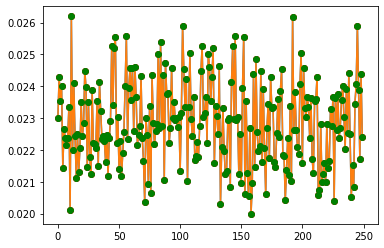

In [ ]:
model = Resnet18_Module(20)

train_source,test_target, trainl_M = switch_source_target("","","", 8, True) ### GETTING ALL NEEEDED LOADERS   source = Product, target = Real Life 
LT, LS = main(trainl_M, train_source,test_target, 250, model, "Product_s")
x_val_T = [x[0] for x in LT] #Epochs
y_val_T = [x[1].cpu() for x in LT] #Loss value
x_val_S = [x[0] for x in LS] #Epochs
y_val_S = [x[1].cpu() for x in LS] #Loss value
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'or')
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'og')
plt.show()

Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
_______________________________________________________________
Pretrain Epoch 1/250
LOSS : 4.565345287322998
_______________________________________________________________
Pretrain Epoch 2/250
LOSS : 4.613670349121094
_______________________________________________________________
Pretrain Epoch 3/250
LOSS : 4.694232940673828
_______________________________________________________________
Pretrain Epoch 4/250
LOSS : 4.212562084197998
_______________________________________________________________
Pretrain Epoch 5/250
LOSS : 5.123997688293457
_______________________________________________________________
Pretrain Epoch 6/250
LOSS : 4.258624076843262
_______________________________________________________________
Pretrain Epoch 7/250
LOSS : 3.9216623306274414
___________________________________________________

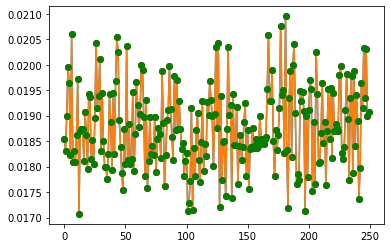

In [ ]:
model = Resnet18_Module(20)

train_source,test_target, trainl_M = switch_source_target("","","", 8, False) ### GETTING ALL NEEEDED LOADERS   source = Reall, target = Product 
LT, LS = main(trainl_M, train_source,test_target, 250, model, "Reall_s")
x_val_T = [x[0] for x in LT] #Epochs
y_val_T = [x[1].cpu() for x in LT] #Loss value
x_val_S = [x[0] for x in LS] #Epochs
y_val_S = [x[1].cpu() for x in LS] #Loss value
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'or')
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'og')
plt.show()

Accuracy does not seem to have increased. Oppositely, the model has worsened. It might be deducible that instead of learning to pull different features further away, the embedding space of the model doesn't cluster as efficiently as before. Additionally, the model does not seem to learn during clustering training, as indicated by the oscillating loss. 

The fact that the model is not learning can be attributed to various reasons: 
+ High learning rate

+ Small batch size (the model is not able to generalize well). Given the already small learning rate this might be the main reason. During training many issues were encountered with training _continuity_ and we were forced to keep reducing batch size for continuous training. 

+ Insufficient data (given previous good performances this may not be the case in this situation).


Below the respective plots of the feature space for further analyzing whether the model was actually able to generalize common features in the feature space.

In [ ]:
# QUESTE DUE QUI SOTTO : devi runnare switch source target, resnet18module e feature representation e load model to path (così anche nelle tre celle sotto)
net = Resnet18_Module(20)

In [ ]:
product_source,test_target, trainl_M = switch_source_target("","","", 8, True) ### GETTING ALL NEEEDED LOADERS   source = Product, target = Real Life 
reall_source,test_source, trainl_M = switch_source_target("","","", 8, False) ### GETTING ALL NEEEDED LOADERS   source = Real Life, target = Product

In [ ]:
resnet_source = load_model_to_path(net, "drive/MyDrive/DL_Project/model_resnet_kmeans_Reall_s.pt")
## Real Life
feat_rep = Feature_representation('Real life ','tsne', net, product_source, reall_source, device=device)
feat_rep.plot_(k_means=False)
feat_rep.plot_(k_means=True)


In [ ]:

resnet_target = load_model_to_path(net, "drive/MyDrive/DL_Project/model_resnet_kmeans_Product_s.pt")
## Product
feat_rep = Feature_representation('Product ','tsne', net, reall_source, product_source, device=device)
feat_rep.plot_(k_means=False)
feat_rep.plot_(k_means=True)

Given the worsened results on the separated datasets, a last approach was to train the model on both datasets combined (source+target) and then finally fine-tuning on the target only. Performances improved of 10 p.p. This outcome could be probably be yield by the fact that despite the batch size, the number of training images was considerably higher than before. Therefore the model learned to generalize better despite the small set of images passed each time during training.

In [ ]:
def main(trainl,
         trains,
         test,
         epochs,
         model,
         path,
         learning_rate = 1e-6,
         momentum=0.9,
         weight_decay=0.000001,
         device='cuda:0', 
         visualization_name='centered'):



  model = model.to(device)
  optimizer = get_optimizer(model, learning_rate, weight_decay, momentum)


  LT = [] 
  LS = []
 
  centroids =  train_together([], model, optimizer,  trainl, trains, 1, path) #iterating only once to get centroids 
  for e in range(epochs) :  #More epochs for the fine tuning 
      
      
      print('_______________________________________________________________')
      print('ClusterEpoch {}/{}'.format(e+1,epochs)) 
 
      loss, assignments = train_together(centroids.detach(),model, optimizer,  trainl, trains, 2, path) 
      # Detaching centroids from previous model to keep iterating on them 
      print(f'LOSS : {loss}')
      #### PLOTTING LOSSES ####
      LT.append((e,loss.detach()))

  #### TESTING IS MISSING ####
  save_model_to_path(model, f"drive/MyDrive/DL_Project/model_resnet_kmeans_together_{path}")
  testing(model, test_target, nn.CrossEntropyLoss(),device,'Test')
  return LT, LS 

Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
_______________________________________________________________
ClusterEpoch 1/250
LOSS : 4.754649639129639
_______________________________________________________________
ClusterEpoch 2/250
LOSS : 5.0405449867248535
_______________________________________________________________
ClusterEpoch 3/250
LOSS : 4.883824825286865
_______________________________________________________________
ClusterEpoch 4/250
LOSS : 4.403587341308594
_______________________________________________________________
ClusterEpoch 5/250
LOSS : 4.312897205352783
_______________________________________________________________
ClusterEpoch 6/250
LOSS : 4.566410541534424
_______________________________________________________________
ClusterEpoch 7/250
LOSS : 4.202311992645264
_______________________________________________________________
C

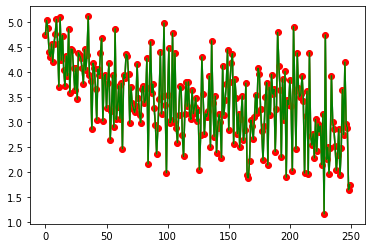

In [ ]:
train_source,test_target, trainl_M = switch_source_target("","","", 8, False) ### GETTING ALL NEEEDED LOADERS   source =  Real Life, target = Product
model = Resnet18_Module(20)
## SOURCE : PRODUCT , TARGET: REAL LIFE
## Lower learning rate as well 
LT, LS = main(train_source, train_source,test_target, 250, model, "Reall_s")
x_val_T = [x[0] for x in LT] #Epochs
y_val_T = [x[1].cpu() for x in LT] #Loss value
x_val_S = [x[0] for x in LS] #Epochs
y_val_S = [x[1].cpu() for x in LS] #Loss value
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'or')
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'-g')
plt.show()

Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
_______________________________________________________________
ClusterEpoch 1/250
LOSS : 5.051088809967041
_______________________________________________________________
ClusterEpoch 2/250
LOSS : 4.750427722930908
_______________________________________________________________
ClusterEpoch 3/250
LOSS : 5.123909950256348
_______________________________________________________________
ClusterEpoch 4/250
LOSS : 4.170165538787842
_______________________________________________________________
ClusterEpoch 5/250
LOSS : 4.31599235534668
_______________________________________________________________
ClusterEpoch 6/250
LOSS : 4.7555975914001465
_______________________________________________________________
ClusterEpoch 7/250
LOSS : 4.895389080047607
_______________________________________________________________
Cl

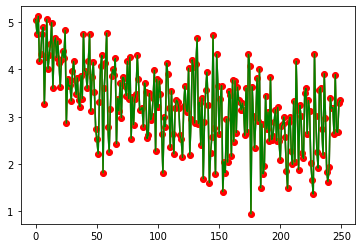

In [ ]:
train_source,test_target, trainl_M = switch_source_target("","","", 8, True) ### GETTING ALL NEEEDED LOADERS   source =  Product, target = Real Life
model = Resnet18_Module(20)
## SOURCE : PRODUCT , TARGET: REAL LIFE
## Lower learning rate as well 
LT, LS = main(train_source, train_source,test_target, 250, model, "Product_s")
x_val_T = [x[0] for x in LT] #Epochs
y_val_T = [x[1].cpu() for x in LT] #Loss value
x_val_S = [x[0] for x in LS] #Epochs
y_val_S = [x[1].cpu() for x in LS] #Loss value
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'or')
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'-g')
plt.show()

Results are however still not satisfactory as despite the good and robust Backbone that has been used, the model is not able to generalize well and the loss function keeps oscillating.

In [ ]:
# QUESTE TRE QUI SOTTO
net = Resnet18_Module(20)

In [ ]:
product_source,test_target, trainl_M = switch_source_target("","","", 8, True) ### GETTING ALL NEEEDED LOADERS   source = Product, target = Real Life 
reall_source,test_source, trainl_M = switch_source_target("","","", 8, False) ### GETTING ALL NEEEDED LOADERS   source = Real Life, target = Product

In [ ]:
## Real Life
resnet_together_source = load_model_to_path(net, "drive/MyDrive/DL_Project/model_resnet_kmeans_together_Product_s.pt")
feat_rep = Feature_representation('Real life ','tsne', net, product_source, reall_source, device=device)
feat_rep.plot_(k_means=False)
feat_rep.plot_(k_means=True)

In [ ]:
## Product
resnet_together_target =  load_model_to_path(net, "drive/MyDrive/DL_Project/model_resnet_kmeans_together_Reall_s.pt")
feat_rep = Feature_representation('Product ','tsne', net, reall_source, prod_source, device=device)
feat_rep.plot_(k_means=False)
feat_rep.plot_(k_means=True)

In [ ]:
## Both Domains
renset_together_both =   load_model_to_path(net, "drive/MyDrive/DL_Project/model_resnet_kmeans_together.pt")
feat_rep = Feature_representation('Both ','tsne', net, load_prod, load_real, device=device)
feat_rep.plot_(k_means=False)
feat_rep.plot_(k_means=True)

AGGIUNGI COMMENTO SULL' ESTRAZIONE DELLE FEATURES

Given the non - satisfactory results with the auto-implemented KMeans a further attempt was to use the standard sklearn library to replicate the DEPICT only as fine-tuning on the feature extractor.
As a matter of fact, one of the main limits of the presented algorithm was that the average for each cluster was returned instead of a harder assignment. Therefore, instead of computing the direct distance with each cluster closeby, the average of distances was returned. This could lead to very misleading outcomes as the average of very closeby clusters and very far away ones could lead to the assingment of a misleading class which however reflects this average computing. Additionally, the model was firstly trained on only the source (or both datasets combined), and then the trianing was enhanced with the clustering algorithm for a better generalized feature space. However, **soft assignments** to the target domain coming from the **hard assignments** of the source domain  were *not* taken into consideration. Having these pseudo labels, however, would add further information for the network training and fully mirror the depict algorithm.

Below, the backbone is not even trained on the source domain, just the features are extracted. Then KMeans are applied to the features extracted by the feature extractor, which will then be used as soft assignments for the features extracted during training on the target domain. 

In [ ]:

class Resnet18_Module_2(torch.nn.Module):

    """Although ResNet is trained on image net for agnosticity purposes 
         the last layers were decoupled and some new ones were added, 
         which could be better related to the Adaptiope Dataset, 
         and thus granting dataset-agnosticity."""

    def __init__(self, num_classes):
        super().__init__()
        batch_size = 8
        num_classes = 20
        model = models.resnet18(pretrained=True)
        for param in model.parameters():
                    param.requires_grad = False
        modules = list(model.children())[:-1]      # delete the last fc layer. The same structure as the first resnet has been used, but with cleaner code.
        self.resnet_modules=modules
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(model.fc.in_features, 128)
        self.fc2 = nn.Linear(128, 20)
        self.dropout = torch.nn.Dropout(0.35) #Adding a Dropout layer to enforce last layers' learning 
        self.softmax = torch.nn.Softmax()
       

    
    def forward(self,x):
        
        x = self.resnet(x)
        x = x.reshape(x.shape[0], 512)
        x = self.fc1(x)
        x = F.relu(x)
        latent_dim_1 = self.fc2(x) 
        x = self.dropout(latent_dim_1)
        output = self.softmax(x)
        return  latent_dim_1, output
 


In [ ]:
from sklearn.cluster import KMeans
from torchvision import models

class DEPICT_FineTune():
    def __init__(self, num_epochs, num_clusters, source, target, test):
        self.num_epochs = num_epochs
        self.num_clusters = num_clusters
        self.resnet18 = Resnet18_Module_2(num_clusters)
        self.criterion = nn.CrossEntropyLoss()
        self.KLDiv = nn.KLDivLoss()
        self.optimizer = torch.optim.Adam(self.resnet18.parameters())
        self.source = source 
        self.target = target
        self.test = test
  
    def return_optimizer(self) :
       optimizer = torch.optim.Adam(self.resnet18.parameters(), lr=1e-07) #SMALL GRADIENT TO AVOID GRADIENT EXPLOSION (we get NAN and INF)
       optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                  mode='min',
                                                  factor=0.2,
                                                  patience=15,
                                                  min_lr=1e-15)
       return optimizer

    def train(self):
        
        for param in self.resnet18.fc1.parameters(): #re-enabling weights from the fully connected layer on
          param.requires_grad = True
          
        self.resnet18.to(device)
        self.resnet18.train()
        optimizer = self.return_optimizer()
        print("Starting training....")
        LT = [] 

        source_features = [] #using the backbone as feature extractor - Source
        print("First Source Training ....")
        for epoch in range(self.num_epochs):
          
          for batch_idx, (data, S) in enumerate(zip(cycle(self.source), self.source)):
              X, labels = S
              img = X.to(device)
              lab = labels.to(device)
              optimizer.zero_grad()
              features, y = self.resnet18(img)
              loss = self.criterion(y, lab)
              loss.backward()
              optimizer.step()
              source_features.append(y)

        source_features = torch.cat(source_features, dim=0) #[4096,20]
        kmeans = KMeans(n_clusters=self.num_clusters, random_state=0).fit(source_features.detach().cpu().numpy()) #[4096, 20]
        target_features = [] #using the backbone as feature extractor - Target
        

        for batch_idx, (data, T) in enumerate(zip(cycle(self.target), self.target)):
            X, _ = T
            img = X.to(device)
            features, y = self.resnet18(img)
            target_features.append(y) #Not training on the target as we are only fine-tuning on the source

        target_features = torch.cat(target_features, dim=0)   
        target_clusters = kmeans.predict(target_features.detach().cpu().numpy()) #detaching from graph training loop

        soft_assignment_T = torch.zeros((target_features.size(0), self.num_clusters)) #SOFT LABEL for each T data point
        soft_assignment_T = soft_assignment_T.to(device)
    
        
        for i in range(target_features.size(0)):
            soft_assignment_T[i, target_clusters[i]] = 1
      
        optimizer_2 = self.return_optimizer()



        # Training loop
        print("Soft Label Training ....")
        for epoch in range(self.num_epochs):
           
            for batch_idx, (img, _) in enumerate(train_target):
                img = img.to(device)
                optimizer_2.zero_grad()
                features, outputs = self.resnet18(img)
                loss = self.criterion(soft_assignment_T[batch_idx * train_target.batch_size: (batch_idx + 1) * train_target.batch_size], outputs) #getting only the ones in the batch
            
                loss.backward()
                optimizer_2.step()
            print("EPOCH: {}/{}".format(epoch,self.num_epochs) + f"\nLoss: {loss}")
            print("_________________________________________________________________")
            LT.append((epoch,loss.detach()))

        return LT
        

    def testing(self, cost_function):

        total = 0
        r_loss = 0
        correct = 0

        self.resnet18.eval()
        with torch.no_grad():

          for batch_idx, (img, label) in enumerate(self.test):
                
                images = img.to(device)
                labels = label.to(device)
                _, outputs = self.resnet18(images)   
                data = outputs.data.to(device)
                loss = cost_function(data, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                r_loss += loss
        print('Accuracy of the network on the target domain test images: %d %%' % (100 * correct / total))
        print('Test Loss: ', r_loss)



Starting training....
First Source Training ....
Soft Label Training ....
EPOCH: 0/200
Loss: 3.062986373901367
_________________________________________________________________
EPOCH: 1/200
Loss: 3.0649123191833496
_________________________________________________________________
EPOCH: 2/200
Loss: 3.0582170486450195
_________________________________________________________________
EPOCH: 3/200
Loss: 3.0568947792053223
_________________________________________________________________
EPOCH: 4/200
Loss: 3.049285411834717
_________________________________________________________________
EPOCH: 5/200
Loss: 3.0575156211853027
_________________________________________________________________
EPOCH: 6/200
Loss: 3.0578927993774414
_________________________________________________________________
EPOCH: 7/200
Loss: 3.058192729949951
_________________________________________________________________
EPOCH: 8/200
Loss: 3.0606048107147217
___________________________________________________________

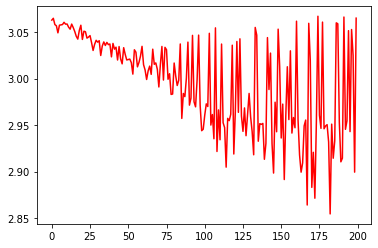

Accuracy of the network on the target domain test images: 4 %
Test Loss:  tensor(159.4520, device='cuda:0')


In [ ]:
dep_t = DEPICT_FineTune(200, 20, train_source, train_target, test_target)

LT = dep_t.train() #Firstly for PRODUCT -> REAL LIFE
x_val_T = [x[0] for x in LT] #Epochs
y_val_T = [x[1].cpu() for x in LT] #Loss value
plt.plot(x_val_T,y_val_T,'-r')
plt.show()
dep_t.testing(nn.CrossEntropyLoss())



Despite the small and descending learning rate it can be observed that although the loss decreases in the first ca. 60 epochs, then the gradient seems to explode and loss oscillations keep increasing. This can be mostly related to the small size of our batch and its relation to gradient descent, which gets closer and closer to a stochastic type of gradient descent, rather than a mini-batch one. There may be multiple batches from which it cannot much be learned from.
Since the loss was decreasing in a good way, it may be that the optimizer has pushed the NN out of the minimum.

In [ ]:
train_source,test_target, trainl_M = switch_source_target("","","", 64, True) ### GETTING ALL NEEEDED LOADERS   source = Product, target = Real Life 
train_target,test_source, trainl_M = switch_source_target("","","", 64, False) ### GETTING ALL NEEEDED LOADERS   source = Real Life, target = Product

Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Starting training....
First Source Training ....
Soft Label Training ....
EPOCH: 0/400
Loss: 3.053722381591797
_________________________________________________________________
EPOCH: 1/400
Loss: 3.05340576171875
_________________________________________________________________
EPOCH: 2/400
Loss: 3.0522217750549316
_________________________________________________________________
EPOCH: 3/400
Loss: 3.052546977996826
_________________________________________________________________
EPOCH: 4/400
Loss: 3.0529279708862305
_________________________________________________________________
EPOCH: 5/400
Loss: 3.054677963256836
_________________________________________________________________
EPOCH: 6/400
Loss: 3.056424140930176
_________________________________________________________________
EPOCH: 7/400
Loss: 3.053044319152832
_________________________________________________________________
EPOCH: 8/400
Loss: 3.0548574924468994
_______________________________________________________________

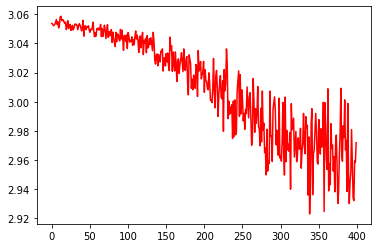

Accuracy of the network on the target domain test images: 4 %
Test Loss:  tensor(21.0531, device='cuda:0')


In [ ]:
dep_t = DEPICT_FineTune(400, 20, train_source, train_target, test_target)

LT = dep_t.train() #Firstly for PRODUCT -> REAL LIFE
x_val_T = [x[0] for x in LT] #Epochs
y_val_T = [x[1].cpu() for x in LT] #Loss value
plt.plot(x_val_T,y_val_T,'-r')
plt.show()
dep_t.testing(nn.CrossEntropyLoss())



In [ ]:
class DEPICT_FineTune_Only():
    """Instead of source training it only passes the fefatures through the net to learn a first representation and to assign soft labels"""
    def __init__(self, num_epochs, num_clusters, source, target, test):
        self.num_epochs = num_epochs
        self.num_clusters = num_clusters
        self.resnet18 = Resnet18_Module_2(num_clusters)
        self.criterion = nn.CrossEntropyLoss()
        self.KLDiv = nn.KLDivLoss()
        self.optimizer = torch.optim.Adam(self.resnet18.parameters())
        self.source = source 
        self.target = target
        self.test = test
  
    def return_optimizer(self) :
       optimizer = torch.optim.Adam(self.resnet18.parameters(), lr=1e-07) #SMALL GRADIENT TO AVOID GRADIENT EXPLOSION (we get NAN and INF)
       optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                  mode='min',
                                                  factor=0.2,
                                                  patience=15,
                                                  min_lr=1e-15)
       return optimizer

    def train(self):
        
        for param in self.resnet18.fc1.parameters(): #re-enabling weights from the fully connected layer on
          param.requires_grad = True

        self.resnet18.to(device)
        optimizer = self.return_optimizer()
        print("Starting training....")
        LT = [] 

        source_features = [] #using the backbone as feature extractor - Source
        for epoch in range(self.num_epochs):
          
          for batch_idx, (data, S) in enumerate(zip(cycle(self.source), self.source)):
              X, labels = S
              img = X.to(device)
              features, y = self.resnet18(img)
              source_features.append(y)

        source_features = torch.cat(source_features, dim=0) #[4096,20]
        kmeans = KMeans(n_clusters=self.num_clusters, random_state=0).fit(source_features.detach().cpu().numpy()) #[4096, 20]
        target_features = [] #using the backbone as feature extractor - Target
        

        for batch_idx, (data, T) in enumerate(zip(cycle(self.target), self.target)):
            X, _ = T
            img = X.to(device)
            features, y = self.resnet18(img)
            target_features.append(y) #Not training on the target as we are only fine-tuning on the source

        target_features = torch.cat(target_features, dim=0)   
        target_clusters = kmeans.predict(target_features.detach().cpu().numpy()) #detaching from graph training loop

        soft_assignment_T = torch.zeros((target_features.size(0), self.num_clusters)) #SOFT LABEL for each T data point
        soft_assignment_T = soft_assignment_T.to(device)
    
        
        for i in range(target_features.size(0)):
            soft_assignment_T[i, target_clusters[i]] = 1
      

        optimizer_2 = self.return_optimizer()
        self.resnet18.train()

        # Training loop
        print("Soft Label Training ....")
        for epoch in range(self.num_epochs):
           
            for batch_idx, (img, _) in enumerate(train_target):
                img = img.to(device)
                optimizer_2.zero_grad()
                features, outputs = self.resnet18(img)
                loss = self.criterion(soft_assignment_T[batch_idx * train_target.batch_size: (batch_idx + 1) * train_target.batch_size], outputs) #getting only the ones in the batch
            
                loss.backward()
                optimizer_2.step()
            print("EPOCH: {}/{}".format(epoch,self.num_epochs) + f"\nLoss: {loss}")
            print("_________________________________________________________________")
            LT.append((epoch,loss.detach()))

        return LT
        

    def testing(self, cost_function):

        total = 0
        r_loss = 0
        correct = 0

        self.resnet18.eval()
        with torch.no_grad():

          for batch_idx, (img, label) in enumerate(self.test):
                
                images = img.to(device)
                labels = label.to(device)
                _, outputs = self.resnet18(images)   
                data = outputs.data.to(device)
                loss = cost_function(data, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                r_loss += loss
        print('Accuracy of the network on the target domain test images: %d %%' % (100 * correct / total))
        print('Test Loss: ', r_loss)



Starting training....
First Source Training ....
Soft Label Training ....
EPOCH: 0/400
Loss: 3.0260581970214844
_________________________________________________________________
EPOCH: 1/400
Loss: 3.027940273284912
_________________________________________________________________
EPOCH: 2/400
Loss: 3.024895668029785
_________________________________________________________________
EPOCH: 3/400
Loss: 3.0282559394836426
_________________________________________________________________
EPOCH: 4/400
Loss: 3.027684211730957
_________________________________________________________________
EPOCH: 5/400
Loss: 3.0271902084350586
_________________________________________________________________
EPOCH: 6/400
Loss: 3.023865222930908
_________________________________________________________________
EPOCH: 7/400
Loss: 3.0259838104248047
_________________________________________________________________
EPOCH: 8/400
Loss: 3.0289108753204346
____________________________________________________________

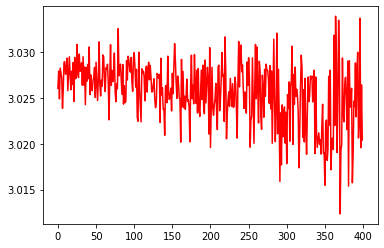

Accuracy of the network on the target domain test images: 4 %
Test Loss:  tensor(20.9815, device='cuda:0')


In [ ]:
dep_t = DEPICT_FineTune_Only(400, 20, train_source, train_target, test_target)

LT = dep_t.train() #Firstly for PRODUCT -> REAL LIFE
x_val_T = [x[0] for x in LT] #Epochs
y_val_T = [x[1].cpu() for x in LT] #Loss value
plt.plot(x_val_T,y_val_T,'-r')
plt.show()
dep_t.testing(nn.CrossEntropyLoss())



In [ ]:
dep_s = DEPICT_FineTune(1, 20, train_target, train_source, test_source)
LS = dep_s.train() #Secondly for REAL LIFE -> PRODUCT #Unità di calcolo non più disponibiliy CUDA Memory error
x_val_S = [x[0] for x in LS] #Epochs
y_val_S = [x[1].cpu() for x in LS] #Loss value
plt.plot(x_val_S,y_val_S,'-g')
LS.testing(nn.CrossEntropyLoss())

# This cell could not be run given the lack of computational power which has been exhausted for the last 72 hours. GPU could not be used.

Only basic KMeans on the products of the softmax seem to have been having soeme effect on model's performance, whereas training the model with a pseudo-DEPICT algorithm did not enhance performances.

By considering the similar KMeans algorithm, and giving the better outcome, now the same approach is implemented with the previously-defined autoencoder. Here a classifier is jointly trained with the autoencoder, while taking into account cluster assignments. Therefore, the optimization problem will be as follows: 

min(M, $\theta$, $\sigma$, $\phi$) = $L_{AE}$($X_s$, $X_t$, $\sigma$, $\phi$) + $\lambda$*Cluster_Loss($X_t$, M, $\sigma|)+$$\lambda$$_2$$*$CrossEntropy

The main idea would be to encourage the autoencoder to learn discriminative features. Therefore the model is trained jointly on target and source images, but the loss is not only composed by the reconstruction loss: there is the cluster and the cross entropy loss as well. This would allow to enhance a more generic learning of the classifier. Soft labels for the target domain are not needed during training, as the only goal is for the autoencoder to learn a generalized feature space.

### Autoencoder 

The model of choice is a convolutional autoencoder, from which the encoder will be used as feature extractor during training, and classifier during testing time.  
Autoencoders compress information automatically. The entire network always resembles an hourglass-like shape, with smaller hidden layers than the input and output layers. 

![](https://drive.google.com/uc?export=view&id=1I7bjUCRiXGpwEV_OywUOGHxcSbC26A_J)

Additionally, autoencoders learn non linear mapping and retain important information. Thus, keeping the latent space small forces the model to learn an intelligent representation of the data. 




For continuity, the first attempt of the architecture of the autocoder has ResNet as backbone. This was due to the fact that ResNet seemed to be quite good in extract the features despite of the domain. 

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.back_ = models.resnet18(pretrained = True) #ResNet backbone, pretrained 
        
        # avg pool
        self.back_.avgpool  = torch.nn.AvgPool2d((3,3))
        self.back_.fc = torch.nn.Linear(8*2048,784 * 8)  
        self.linear2 = torch.nn.Linear(2048, 20)
        self.softmax = torch.nn.Softmax(dim=1)


    def forward(self, inp):
        inp = self.back_.conv1(inp) #first conv block 
        inp = self.back_.bn1(inp) #first conv block 
        inp = self.back_.relu(inp) #first conv block 
        inp = self.back_.maxpool(inp) #first conv block 
        inp = self.back_.layer1(inp) #first layer
        inp = self.back_.layer2(inp) #second layer 
        inp = self.back_.layer3(inp) #third layer
        inp = self.back_.layer4(inp) #fourth layer
        inp = self.back_.avgpool(inp) #avgpooling
        inp2 = torch.flatten(inp) #flatten , tensor reshaping  
        inp = self.back_.fc(inp) #new fully connected layer
        p = self.softmax(inp)

        return inp, inp2, p  #returning encoded images, flatten output for clustering, and probability assignments 

In [ ]:
class Decoder(torch.nn.Module):

    """This class is the transpose of the Encoder class"""
    def __init__(self,
                 latent_dim : int):
        
        super().__init__()

        self.lin1 = torch.nn.Linear( 8* latent_dim, 8* 2048)  
        self.unflatten = torch.nn.Unflatten(-1, (8, 512, 2,2))  
        self.upsample = torch.nn.Upsample(size = 7)
       
        self.layer1 = torch.nn.Sequential(
            
            torch.nn.ConvTranspose2d(512, 512, 3,1,1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(512, 512, 3,1,1),
            torch.nn.BatchNorm2d(512),
            torch.nn.Sequential(
                torch.nn.ConvTranspose2d(512,256, 2,2),
                torch.nn.BatchNorm2d(256)

            )
        )

        self.layer2 =  torch.nn.Sequential(
            
            torch.nn.ConvTranspose2d(256, 256, 3,1,1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(256, 256, 3,1,1),
            torch.nn.BatchNorm2d(256),
            torch.nn.Sequential(
                torch.nn.ConvTranspose2d(256,128, 2,2),
                torch.nn.BatchNorm2d(128)

            )
        )

        self.layer3 =  torch.nn.Sequential(
            
            torch.nn.ConvTranspose2d(128, 128, 3,1,1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 128, 3,1,1),
            torch.nn.BatchNorm2d(128),
            torch.nn.Sequential(
                torch.nn.ConvTranspose2d(128,64, 2,2),
                torch.nn.BatchNorm2d(64)

            )
        )

        self.layer4 =  torch.nn.Sequential(
            
            torch.nn.ConvTranspose2d(64, 64, 3,1,1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 64, 3,1,1),
            torch.nn.BatchNorm2d(64),
            torch.nn.Sequential(
                torch.nn.ConvTranspose2d(64,64, 2,2),
                torch.nn.BatchNorm2d(64)

            )
        )

        self.layer5 = torch.nn.Sequential(
            torch.nn.Upsample(size=112),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.ConvTranspose2d(64,3,6,2,2)
        )

    def forward(self, inp):

        inp = self.lin1(inp)
        inp = self.unflatten(inp)
        inp = self.upsample(inp)
        inp = self.layer1(inp)
        inp = self.layer2(inp)
        inp = self.layer3(inp)
        inp = self.layer4(inp)
        inp = self.layer5(inp)

        return inp 

However, with this architecture we experienced very poor results. Given continuous cuda-out of memory results, we had to return one single image after training with any epochs. 

![](https://drive.google.com/uc?export=view&id=18CiBoQ06O6YbG9iUhIQ8AF9hJroA8NSM)

While Autoencoders provide some consistent perks such as unsupervisedly removing noise from input signals and thus extracting the smallest amount of data needed to reconstruct the original input, leading to learning only significant features, there were some limits that had to be faced. 
Firstly, the model used a ResNet18 backbone, whose feature distribution might have been too complex for the decoder to detangle. Given the small amount of training images, the overall architecture was too deep to fetch significant information. 
Secondly, one might also consider the distribution gap between ImageNet Dataset and Adaptiope. A reparametrisation trick could have been used to realign both distributions. However, given the simplicity of the task and the low number of images, as well as the need for leveraging well-reconstructed images, led to the decision of using a simpler model trained from scratch.   

The main idea of using ResNet18 as backbone and thus applying some basical transfer learning was leveraged by the already good outcomes of ResNet18 as feature extractor. The simpler idea would have been to enhance its performances while taking into account two further sources of information: 
* The optimization of feature clustering algorithm: the more features close to each other are pushed together, the better features for each class are identified. 
* The optimization of feature extraction by taking advantage of autoencoder's reconstruction loss. 

Nonetheless, given the complex model, the distributions's gap emerged to be too wide for the constructed model to learn significant features, thus only outputting random noise. Therefore, while still leveraging the idea of using a good and enhanced feature extractor, a simpler autoencoder was created, with less layers. 

In [ ]:
class Encoder_N(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int
                 ):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. 
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.layer1 = nn.Sequential(nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
                    nn.ReLU(),
                    nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
                    nn.ReLU(),
                    nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
                    nn.ReLU(),
                    nn.Flatten(), # Image grid to single feature vector
                    nn.Linear(351232, latent_dim))
        
        self.linear2 = nn.Linear(latent_dim, 20*8)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):

      enc = self.layer1(x)
      lin_p = self.linear2(enc) 
      p = self.softmax(lin_p)
      return enc, p 

In [ ]:
class Decoder_N(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. 
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = 224
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 351232),
             nn.ReLU()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            nn.ReLU(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            nn.ReLU(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(c_hid, 3, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 28, 28)
        x = self.net(x)
        return x

In [ ]:
class Autoencoder(nn.Module):

  def __init__(self, 
              base_channel_size: int,
              latent_dim: int,
              encoder_class : object = Encoder_N, #Encoder_N
              decoder_class : object = Decoder_N, #Decoder_N
              num_input_channels: int = 3):
        super().__init__()
        # Saving hyperparameters of autoencoder
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)

  def forward(self, x):

    enc, p = self.encoder(x)
    x_hat = self.decoder(enc)
    return x_hat

  def _get_reconstruction_loss(self, batch):
    """
    Given a batch of images, this function returns the reconstruction loss (MSE in our case)
    """
    x, _ = batch # We do not need the labels
    x = x.to(device)
    x_hat = self.forward(x)
    loss = F.mse_loss(x, x_hat, reduction="none")
    loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
    return loss, x_hat

  def configure_optimizers(self, model_params):
      optimizer = torch.optim.Adam(model_params, lr=1e-3)
      optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                            mode='min',
                                            factor=0.2,
                                            patience=20,
                                             min_lr=1e-8)
     
 
      # Using a scheduler is optional but can be helpful.
      # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
      return optimizer 

  def training_step(self, batch):
      loss, x_hat = self._get_reconstruction_loss(batch)
      
      return loss, x_hat

In [ ]:
import matplotlib.pyplot as plt

def plot_results(dec_out):
    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 2
    rows = 4
    for i in range(1, columns*rows +1):
        img = dec_out[i-1]
        fig.add_subplot(rows, columns, i)
        img = img.permute(1,2,0)
        out = img.cpu().detach().numpy()
        plt.imshow(out.astype('uint8'))
    plt.show()

In [ ]:

def training_autoencoder(model, train_images, epochs, m_type):
  for_plotting = []
 
  model = model.to(device)
  model.train()
  if (m_type == "AE") or (m_type!="NET"):
    optimizer = model.configure_optimizers(model.parameters())

    for e in range(epochs):
      for i, batch in enumerate(train_images):
        optimizer.zero_grad()
        loss, x_hat = model.training_step(batch)
        loss.backward()
        optimizer.step()
        
        
      save_checkpoint(e, model.state_dict(), optimizer.state_dict(), loss, f"drive/MyDrive/DL_Project/checkpoint_{m_type}") # Product -> Real Life
      for_plotting.append((e, loss))
      print(f"Reconstruction loss {loss} for epoch {e}")
      print("_________________________________________")

      if (( e % 10 )== 0) : 
          plot_results(x_hat)
      save_model_to_path(model, f"drive/MyDrive/DL_Project/model_{m_type}_new")
    

  return for_plotting

Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
Reconstruction loss 81991.75 for epoch 0
_________________________________________


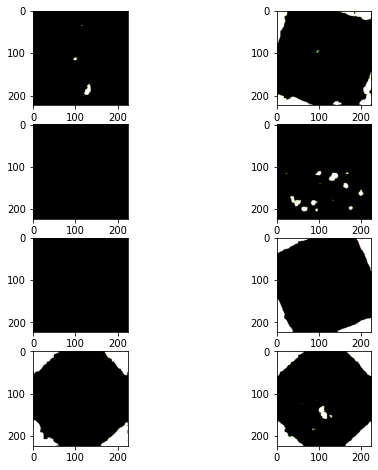

Reconstruction loss 44867.578125 for epoch 1
_________________________________________
Reconstruction loss 73604.7890625 for epoch 2
_________________________________________
Reconstruction loss 82025.8046875 for epoch 3
_________________________________________
Reconstruction loss 68929.0625 for epoch 4
_________________________________________
Reconstruction loss 68031.140625 for epoch 5
_________________________________________
Reconstruction loss 68087.515625 for epoch 6
_________________________________________
Reconstruction loss 82199.34375 for epoch 7
_________________________________________
Reconstruction loss 61102.828125 for epoch 8
_________________________________________
Reconstruction loss 78050.171875 for epoch 9
_________________________________________
Reconstruction loss 51997.3515625 for epoch 10
_________________________________________


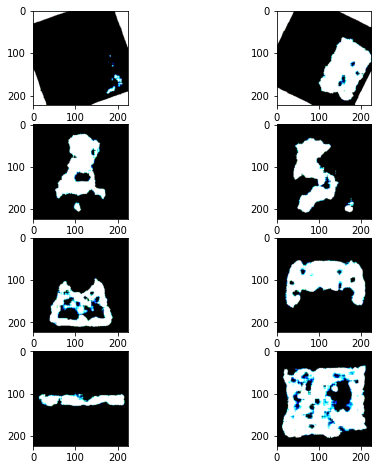

Reconstruction loss 74088.1484375 for epoch 11
_________________________________________
Reconstruction loss 75290.1015625 for epoch 12
_________________________________________
Reconstruction loss 55411.72265625 for epoch 13
_________________________________________
Reconstruction loss 56599.359375 for epoch 14
_________________________________________
Reconstruction loss 87129.015625 for epoch 15
_________________________________________
Reconstruction loss 59648.64453125 for epoch 16
_________________________________________
Reconstruction loss 77087.640625 for epoch 17
_________________________________________
Reconstruction loss 57793.890625 for epoch 18
_________________________________________
Reconstruction loss 59629.23046875 for epoch 19
_________________________________________
Reconstruction loss 85501.15625 for epoch 20
_________________________________________


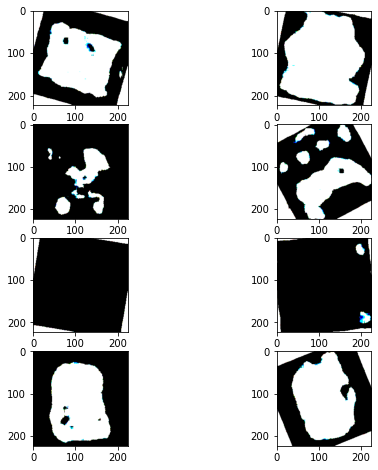

Reconstruction loss 71225.578125 for epoch 21
_________________________________________
Reconstruction loss 74230.75 for epoch 22
_________________________________________
Reconstruction loss 38130.9296875 for epoch 23
_________________________________________
Reconstruction loss 50601.4296875 for epoch 24
_________________________________________
Reconstruction loss 63393.6796875 for epoch 25
_________________________________________
Reconstruction loss 63037.6015625 for epoch 26
_________________________________________
Reconstruction loss 69574.34375 for epoch 27
_________________________________________
Reconstruction loss 78574.1171875 for epoch 28
_________________________________________
Reconstruction loss 55812.76953125 for epoch 29
_________________________________________
Reconstruction loss 63094.140625 for epoch 30
_________________________________________


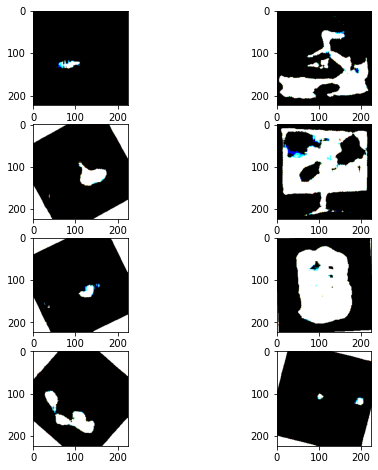

Reconstruction loss 42914.1640625 for epoch 31
_________________________________________
Reconstruction loss 70948.3984375 for epoch 32
_________________________________________
Reconstruction loss 48457.07421875 for epoch 33
_________________________________________
Reconstruction loss 61440.18359375 for epoch 34
_________________________________________
Reconstruction loss 68598.15625 for epoch 35
_________________________________________
Reconstruction loss 65411.53125 for epoch 36
_________________________________________
Reconstruction loss 72583.5078125 for epoch 37
_________________________________________
Reconstruction loss 63696.80078125 for epoch 38
_________________________________________
Reconstruction loss 41532.1875 for epoch 39
_________________________________________
Reconstruction loss 51730.81640625 for epoch 40
_________________________________________


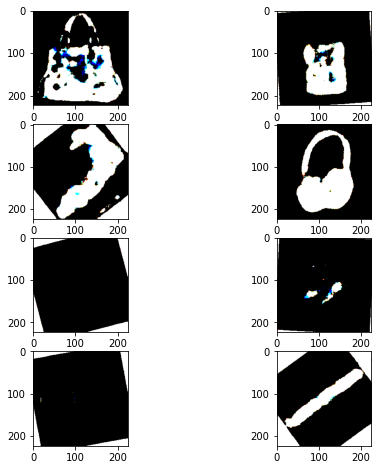

Reconstruction loss 53595.796875 for epoch 41
_________________________________________
Reconstruction loss 57548.59375 for epoch 42
_________________________________________
Reconstruction loss 59688.27734375 for epoch 43
_________________________________________
Reconstruction loss 47505.6484375 for epoch 44
_________________________________________
Reconstruction loss 52933.83203125 for epoch 45
_________________________________________
Reconstruction loss 74458.21875 for epoch 46
_________________________________________
Reconstruction loss 68569.5390625 for epoch 47
_________________________________________
Reconstruction loss 44841.27734375 for epoch 48
_________________________________________
Reconstruction loss 71168.0546875 for epoch 49
_________________________________________
Reconstruction loss 66615.796875 for epoch 50
_________________________________________


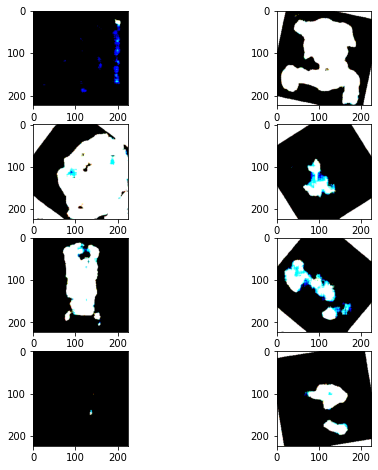

Reconstruction loss 58328.50390625 for epoch 51
_________________________________________
Reconstruction loss 84374.234375 for epoch 52
_________________________________________
Reconstruction loss 38699.36328125 for epoch 53
_________________________________________
Reconstruction loss 61287.7265625 for epoch 54
_________________________________________
Reconstruction loss 66196.65625 for epoch 55
_________________________________________
Reconstruction loss 40231.95703125 for epoch 56
_________________________________________
Reconstruction loss 65647.9140625 for epoch 57
_________________________________________
Reconstruction loss 64642.765625 for epoch 58
_________________________________________
Reconstruction loss 94130.09375 for epoch 59
_________________________________________
Reconstruction loss 50039.453125 for epoch 60
_________________________________________


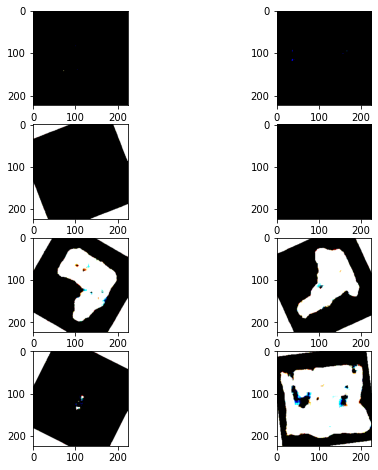

Reconstruction loss 44643.328125 for epoch 61
_________________________________________
Reconstruction loss 61168.3671875 for epoch 62
_________________________________________
Reconstruction loss 71510.40625 for epoch 63
_________________________________________
Reconstruction loss 60405.9140625 for epoch 64
_________________________________________
Reconstruction loss 45959.8359375 for epoch 65
_________________________________________
Reconstruction loss 58301.2890625 for epoch 66
_________________________________________
Reconstruction loss 61679.0703125 for epoch 67
_________________________________________
Reconstruction loss 70699.625 for epoch 68
_________________________________________
Reconstruction loss 65165.76953125 for epoch 69
_________________________________________
Reconstruction loss 43663.57421875 for epoch 70
_________________________________________


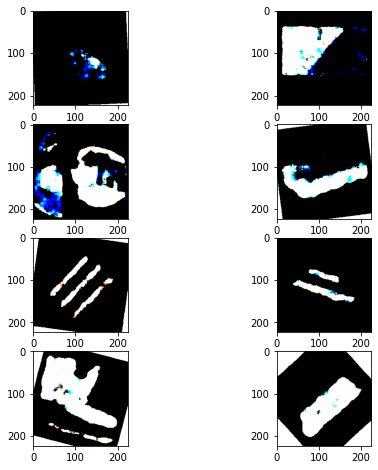

Reconstruction loss 62678.1171875 for epoch 71
_________________________________________
Reconstruction loss 67491.71875 for epoch 72
_________________________________________
Reconstruction loss 60087.23828125 for epoch 73
_________________________________________
Reconstruction loss 56398.67578125 for epoch 74
_________________________________________
Reconstruction loss 85180.65625 for epoch 75
_________________________________________
Reconstruction loss 84758.046875 for epoch 76
_________________________________________
Reconstruction loss 76259.875 for epoch 77
_________________________________________
Reconstruction loss 58407.65234375 for epoch 78
_________________________________________
Reconstruction loss 62524.02734375 for epoch 79
_________________________________________
Reconstruction loss 56581.7109375 for epoch 80
_________________________________________


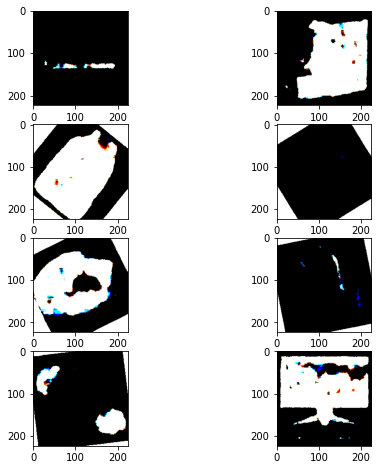

Reconstruction loss 72429.6484375 for epoch 81
_________________________________________
Reconstruction loss 86676.53125 for epoch 82
_________________________________________
Reconstruction loss 55279.5234375 for epoch 83
_________________________________________
Reconstruction loss 55271.34765625 for epoch 84
_________________________________________
Reconstruction loss 65823.1484375 for epoch 85
_________________________________________
Reconstruction loss 54817.1640625 for epoch 86
_________________________________________
Reconstruction loss 63731.58203125 for epoch 87
_________________________________________
Reconstruction loss 51788.1875 for epoch 88
_________________________________________
Reconstruction loss 77180.1640625 for epoch 89
_________________________________________
Reconstruction loss 45239.6796875 for epoch 90
_________________________________________


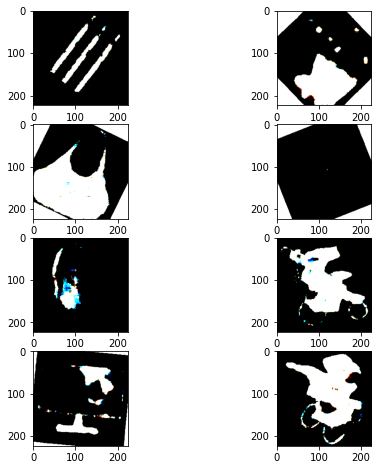

Reconstruction loss 66193.6875 for epoch 91
_________________________________________
Reconstruction loss 55744.3046875 for epoch 92
_________________________________________
Reconstruction loss 63509.640625 for epoch 93
_________________________________________
Reconstruction loss 67532.296875 for epoch 94
_________________________________________
Reconstruction loss 56386.859375 for epoch 95
_________________________________________
Reconstruction loss 61136.3203125 for epoch 96
_________________________________________
Reconstruction loss 50612.5546875 for epoch 97
_________________________________________
Reconstruction loss 84133.453125 for epoch 98
_________________________________________
Reconstruction loss 69487.40625 for epoch 99
_________________________________________


In [ ]:
train_source,test_target, trainl_M = switch_source_target("","","", 8, True) ### GETTING ALL NEEEDED LOADERS   source =  Product, target = Real Life
autoencoder = Autoencoder(224,64)
autoencoder = autoencoder.to(device)
for_loss = training_autoencoder(autoencoder, train_source, 100, "AE_Product_s")

<All keys matched successfully>
Reconstruction loss 93116.953125 for epoch 0
_________________________________________


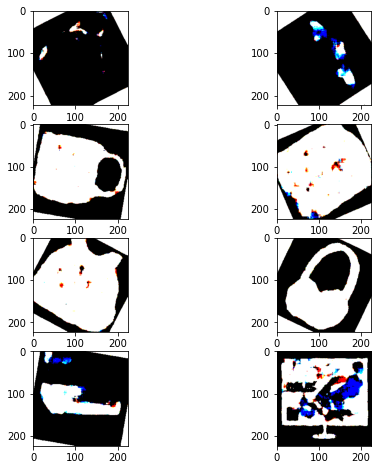

Reconstruction loss 92018.390625 for epoch 1
_________________________________________
Reconstruction loss 35767.3671875 for epoch 2
_________________________________________
Reconstruction loss 60016.65625 for epoch 3
_________________________________________
Reconstruction loss 55550.10546875 for epoch 4
_________________________________________
Reconstruction loss 44270.15625 for epoch 5
_________________________________________
Reconstruction loss 57001.6015625 for epoch 6
_________________________________________
Reconstruction loss 52195.1171875 for epoch 7
_________________________________________
Reconstruction loss 80565.234375 for epoch 8
_________________________________________
Reconstruction loss 47175.2265625 for epoch 9
_________________________________________
Reconstruction loss 63270.39453125 for epoch 10
_________________________________________


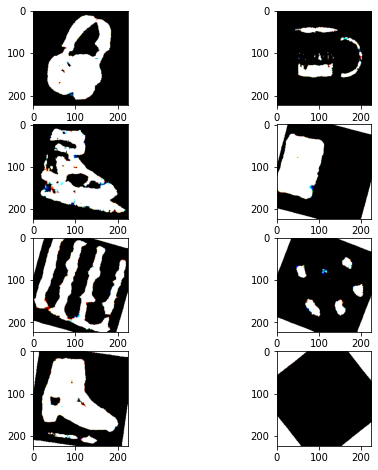

Reconstruction loss 63500.80859375 for epoch 11
_________________________________________
Reconstruction loss 56857.6015625 for epoch 12
_________________________________________
Reconstruction loss 74519.1171875 for epoch 13
_________________________________________
Reconstruction loss 40344.70703125 for epoch 14
_________________________________________
Reconstruction loss 43774.37890625 for epoch 15
_________________________________________
Reconstruction loss 37192.234375 for epoch 16
_________________________________________
Reconstruction loss 36434.90234375 for epoch 17
_________________________________________
Reconstruction loss 48347.91796875 for epoch 18
_________________________________________
Reconstruction loss 41374.07421875 for epoch 19
_________________________________________
Reconstruction loss 30272.912109375 for epoch 20
_________________________________________


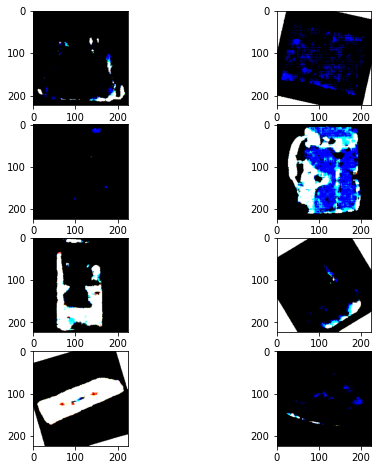

Reconstruction loss 59553.5625 for epoch 21
_________________________________________
Reconstruction loss 52347.9765625 for epoch 22
_________________________________________
Reconstruction loss 70721.1796875 for epoch 23
_________________________________________
Reconstruction loss 58012.87890625 for epoch 24
_________________________________________
Reconstruction loss 65477.984375 for epoch 25
_________________________________________
Reconstruction loss 50789.37109375 for epoch 26
_________________________________________
Reconstruction loss 65482.55859375 for epoch 27
_________________________________________
Reconstruction loss 58010.5546875 for epoch 28
_________________________________________
Reconstruction loss 73807.109375 for epoch 29
_________________________________________
Reconstruction loss 60981.83984375 for epoch 30
_________________________________________


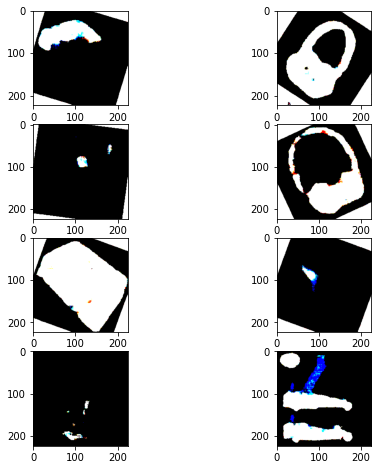

Reconstruction loss 44031.2578125 for epoch 31
_________________________________________
Reconstruction loss 56211.1875 for epoch 32
_________________________________________
Reconstruction loss 75587.953125 for epoch 33
_________________________________________
Reconstruction loss 62525.4375 for epoch 34
_________________________________________
Reconstruction loss 77328.625 for epoch 35
_________________________________________
Reconstruction loss 74904.359375 for epoch 36
_________________________________________
Reconstruction loss 53268.140625 for epoch 37
_________________________________________
Reconstruction loss 54553.4609375 for epoch 38
_________________________________________
Reconstruction loss 56956.8203125 for epoch 39
_________________________________________
Reconstruction loss 53742.8125 for epoch 40
_________________________________________


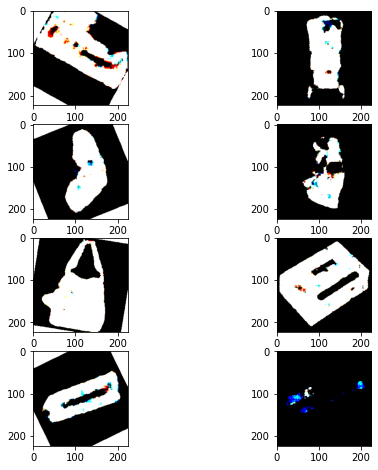

Reconstruction loss 74169.9375 for epoch 41
_________________________________________
Reconstruction loss 46652.09375 for epoch 42
_________________________________________
Reconstruction loss 46333.203125 for epoch 43
_________________________________________
Reconstruction loss 63892.71875 for epoch 44
_________________________________________
Reconstruction loss 70980.59375 for epoch 45
_________________________________________
Reconstruction loss 56346.4375 for epoch 46
_________________________________________
Reconstruction loss 52063.37890625 for epoch 47
_________________________________________
Reconstruction loss 55932.65234375 for epoch 48
_________________________________________
Reconstruction loss 43841.953125 for epoch 49
_________________________________________
Reconstruction loss 45787.36328125 for epoch 50
_________________________________________


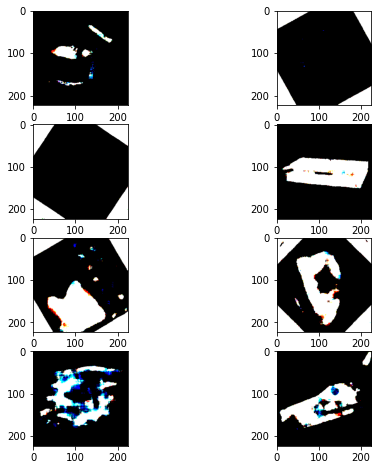

Reconstruction loss 81359.796875 for epoch 51
_________________________________________
Reconstruction loss 47328.6953125 for epoch 52
_________________________________________
Reconstruction loss 66419.578125 for epoch 53
_________________________________________
Reconstruction loss 60591.50390625 for epoch 54
_________________________________________
Reconstruction loss 44896.41796875 for epoch 55
_________________________________________
Reconstruction loss 59681.5546875 for epoch 56
_________________________________________
Reconstruction loss 84352.1640625 for epoch 57
_________________________________________
Reconstruction loss 68142.046875 for epoch 58
_________________________________________
Reconstruction loss 68134.796875 for epoch 59
_________________________________________
Reconstruction loss 60756.3984375 for epoch 60
_________________________________________


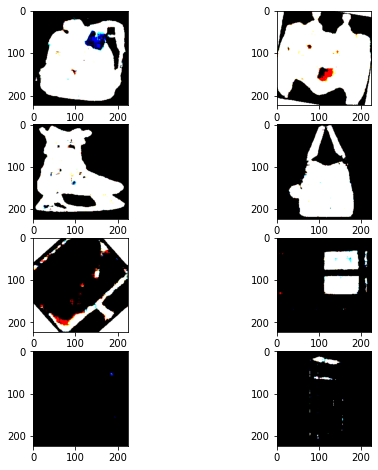

Reconstruction loss 69328.7421875 for epoch 61
_________________________________________
Reconstruction loss 41756.23828125 for epoch 62
_________________________________________
Reconstruction loss 48670.359375 for epoch 63
_________________________________________
Reconstruction loss 52035.09375 for epoch 64
_________________________________________
Reconstruction loss 59494.46875 for epoch 65
_________________________________________
Reconstruction loss 42958.8984375 for epoch 66
_________________________________________
Reconstruction loss 55416.609375 for epoch 67
_________________________________________
Reconstruction loss 58032.453125 for epoch 68
_________________________________________
Reconstruction loss 51181.86328125 for epoch 69
_________________________________________
Reconstruction loss 54582.0 for epoch 70
_________________________________________


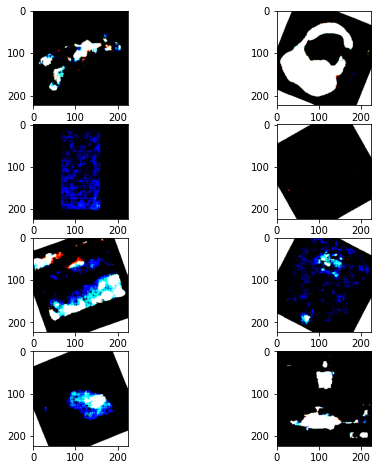

Reconstruction loss 70329.0625 for epoch 71
_________________________________________
Reconstruction loss 69520.3671875 for epoch 72
_________________________________________
Reconstruction loss 38125.421875 for epoch 73
_________________________________________
Reconstruction loss 57293.01171875 for epoch 74
_________________________________________
Reconstruction loss 51505.8671875 for epoch 75
_________________________________________
Reconstruction loss 66059.09375 for epoch 76
_________________________________________
Reconstruction loss 52743.8203125 for epoch 77
_________________________________________
Reconstruction loss 60878.78515625 for epoch 78
_________________________________________
Reconstruction loss 68303.3984375 for epoch 79
_________________________________________
Reconstruction loss 50925.25 for epoch 80
_________________________________________


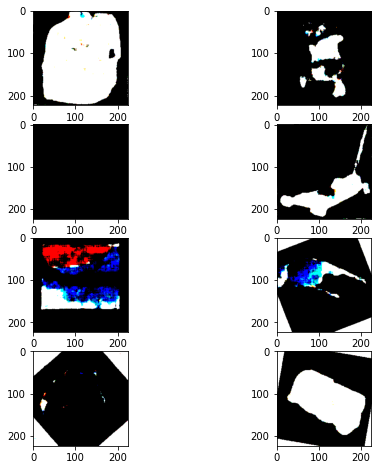

Reconstruction loss 68653.578125 for epoch 81
_________________________________________
Reconstruction loss 78455.7734375 for epoch 82
_________________________________________
Reconstruction loss 67209.234375 for epoch 83
_________________________________________
Reconstruction loss 89840.0078125 for epoch 84
_________________________________________
Reconstruction loss 57905.7890625 for epoch 85
_________________________________________
Reconstruction loss 35980.24609375 for epoch 86
_________________________________________
Reconstruction loss 37948.34765625 for epoch 87
_________________________________________
Reconstruction loss 82959.265625 for epoch 88
_________________________________________
Reconstruction loss 54044.0078125 for epoch 89
_________________________________________
Reconstruction loss 75496.15625 for epoch 90
_________________________________________


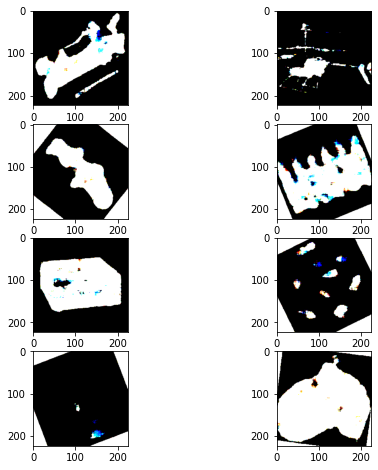

Reconstruction loss 61836.94921875 for epoch 91
_________________________________________
Reconstruction loss 71437.046875 for epoch 92
_________________________________________
Reconstruction loss 69527.828125 for epoch 93
_________________________________________
Reconstruction loss 56201.78515625 for epoch 94
_________________________________________
Reconstruction loss 51518.38671875 for epoch 95
_________________________________________
Reconstruction loss 59032.05078125 for epoch 96
_________________________________________
Reconstruction loss 46669.1953125 for epoch 97
_________________________________________
Reconstruction loss 43600.23828125 for epoch 98
_________________________________________
Reconstruction loss 54962.8359375 for epoch 99
_________________________________________


In [ ]:

autoencoder = Autoencoder(224,64)
autoencoder = autoencoder.to(device)
model = load_model_to_path(autoencoder, "drive/MyDrive/DL_Project/model_AE_Product_s_new")
for_loss = training_autoencoder(model, train_source, 100, "AE_Product_s")

In [ ]:
autoencoder = Autoencoder(224,64)
autoencoder = autoencoder.to(device)
model = load_model_to_path(autoencoder, "drive/MyDrive/DL_Project/model_AE_Product_s_new")
for_loss = training_autoencoder(model, train_source, 100, "AE_Product_s")

Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
Reconstruction loss 79582.609375 for epoch 0
_________________________________________


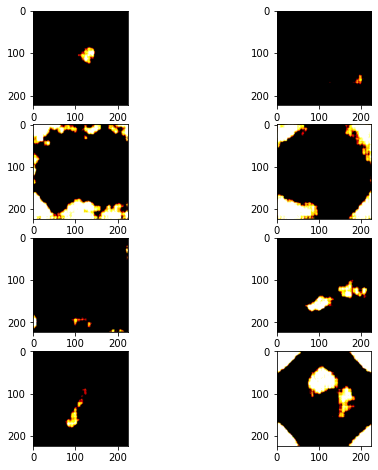

Reconstruction loss 63366.34765625 for epoch 1
_________________________________________
Reconstruction loss 52596.109375 for epoch 2
_________________________________________
Reconstruction loss 47755.140625 for epoch 3
_________________________________________
Reconstruction loss 66173.296875 for epoch 4
_________________________________________
Reconstruction loss 44088.55078125 for epoch 5
_________________________________________
Reconstruction loss 48954.22265625 for epoch 6
_________________________________________
Reconstruction loss 39026.42578125 for epoch 7
_________________________________________
Reconstruction loss 39534.0078125 for epoch 8
_________________________________________
Reconstruction loss 52357.6015625 for epoch 9
_________________________________________
Reconstruction loss 37790.16015625 for epoch 10
_________________________________________


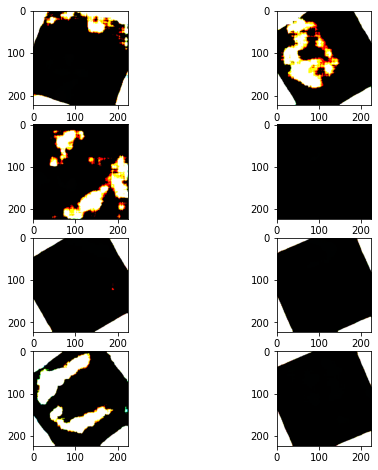

Reconstruction loss 53264.8125 for epoch 11
_________________________________________
Reconstruction loss 33276.140625 for epoch 12
_________________________________________
Reconstruction loss 41907.4921875 for epoch 13
_________________________________________
Reconstruction loss 42043.74609375 for epoch 14
_________________________________________
Reconstruction loss 44950.4921875 for epoch 15
_________________________________________
Reconstruction loss 40539.1171875 for epoch 16
_________________________________________
Reconstruction loss 66782.21875 for epoch 17
_________________________________________
Reconstruction loss 58541.2578125 for epoch 18
_________________________________________
Reconstruction loss 41041.09375 for epoch 19
_________________________________________
Reconstruction loss 37943.66796875 for epoch 20
_________________________________________


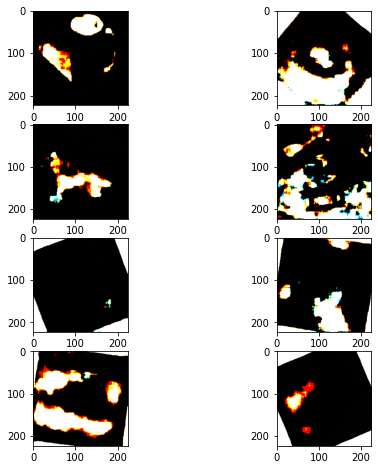

Reconstruction loss 42323.9296875 for epoch 21
_________________________________________
Reconstruction loss 41089.96875 for epoch 22
_________________________________________
Reconstruction loss 43214.8125 for epoch 23
_________________________________________
Reconstruction loss 40734.08984375 for epoch 24
_________________________________________
Reconstruction loss 63020.67578125 for epoch 25
_________________________________________
Reconstruction loss 31137.580078125 for epoch 26
_________________________________________
Reconstruction loss 40585.96875 for epoch 27
_________________________________________
Reconstruction loss 29401.974609375 for epoch 28
_________________________________________
Reconstruction loss 32476.421875 for epoch 29
_________________________________________
Reconstruction loss 32827.8984375 for epoch 30
_________________________________________


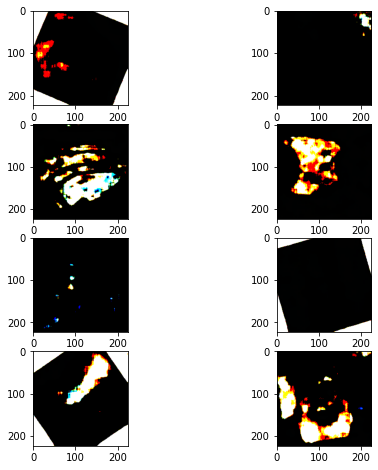

Reconstruction loss 37818.14453125 for epoch 31
_________________________________________
Reconstruction loss 39375.25 for epoch 32
_________________________________________
Reconstruction loss 33391.8515625 for epoch 33
_________________________________________
Reconstruction loss 37741.59375 for epoch 34
_________________________________________
Reconstruction loss 32223.021484375 for epoch 35
_________________________________________
Reconstruction loss 22971.015625 for epoch 36
_________________________________________
Reconstruction loss 34458.81640625 for epoch 37
_________________________________________
Reconstruction loss 36870.65625 for epoch 38
_________________________________________
Reconstruction loss 31993.265625 for epoch 39
_________________________________________
Reconstruction loss 44597.40625 for epoch 40
_________________________________________


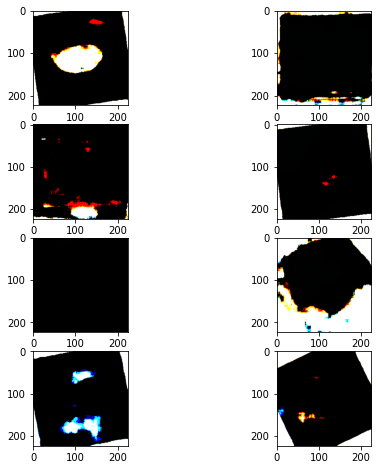

Reconstruction loss 48757.359375 for epoch 41
_________________________________________
Reconstruction loss 44066.7109375 for epoch 42
_________________________________________
Reconstruction loss 26356.51171875 for epoch 43
_________________________________________
Reconstruction loss 41271.1640625 for epoch 44
_________________________________________
Reconstruction loss 34290.72265625 for epoch 45
_________________________________________
Reconstruction loss 31277.83984375 for epoch 46
_________________________________________
Reconstruction loss 38481.734375 for epoch 47
_________________________________________
Reconstruction loss 27264.974609375 for epoch 48
_________________________________________
Reconstruction loss 34775.0859375 for epoch 49
_________________________________________
Reconstruction loss 36479.92578125 for epoch 50
_________________________________________


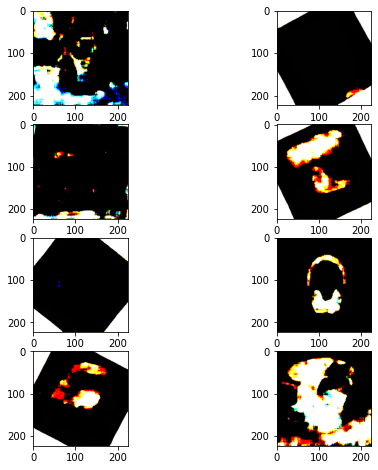

Reconstruction loss 42424.21875 for epoch 51
_________________________________________
Reconstruction loss 40372.5859375 for epoch 52
_________________________________________
Reconstruction loss 39314.85546875 for epoch 53
_________________________________________
Reconstruction loss 44515.53125 for epoch 54
_________________________________________
Reconstruction loss 41993.0703125 for epoch 55
_________________________________________
Reconstruction loss 44255.9375 for epoch 56
_________________________________________
Reconstruction loss 28826.8203125 for epoch 57
_________________________________________


In [ ]:
train_source,test_target, trainl_M = switch_source_target("","","", 8, False) ### GETTING ALL NEEEDED LOADERS   source =  Real Life, target = Product
autoencoder = Autoencoder(224,64)
autoencoder = autoencoder.to(device)
for_loss = training_autoencoder(autoencoder, train_source, 100, "AE_Reall_s")

Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
<All keys matched successfully>
Reconstruction loss 31692.599609375 for epoch 0
_________________________________________


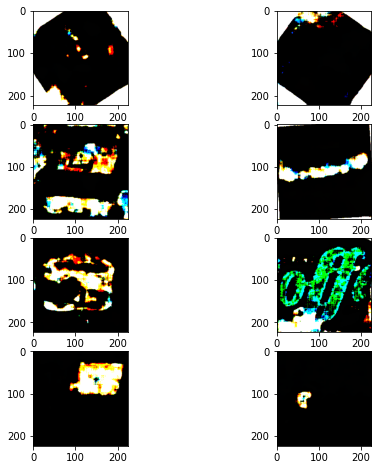

Reconstruction loss 30864.3671875 for epoch 1
_________________________________________
Reconstruction loss 24437.060546875 for epoch 2
_________________________________________
Reconstruction loss 27234.908203125 for epoch 3
_________________________________________
Reconstruction loss 25017.32421875 for epoch 4
_________________________________________
Reconstruction loss 40508.578125 for epoch 5
_________________________________________
Reconstruction loss 32065.68359375 for epoch 6
_________________________________________
Reconstruction loss 30758.419921875 for epoch 7
_________________________________________
Reconstruction loss 44420.15625 for epoch 8
_________________________________________
Reconstruction loss 22677.71484375 for epoch 9
_________________________________________
Reconstruction loss 34320.83203125 for epoch 10
_________________________________________


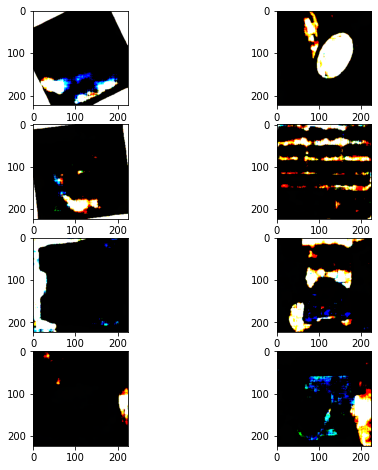

Reconstruction loss 30275.236328125 for epoch 11
_________________________________________
Reconstruction loss 36570.4765625 for epoch 12
_________________________________________
Reconstruction loss 31205.109375 for epoch 13
_________________________________________
Reconstruction loss 34141.6640625 for epoch 14
_________________________________________
Reconstruction loss 41233.51953125 for epoch 15
_________________________________________
Reconstruction loss 51203.41015625 for epoch 16
_________________________________________
Reconstruction loss 36102.8515625 for epoch 17
_________________________________________
Reconstruction loss 37300.60546875 for epoch 18
_________________________________________
Reconstruction loss 28564.28515625 for epoch 19
_________________________________________
Reconstruction loss 34655.5 for epoch 20
_________________________________________


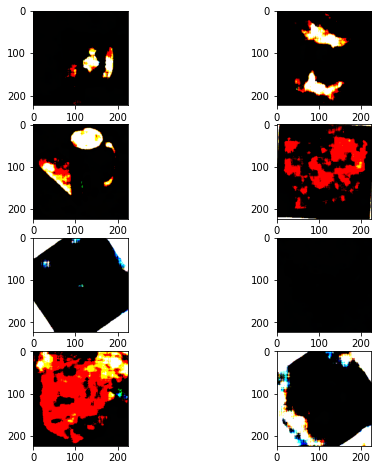

Reconstruction loss 32380.853515625 for epoch 21
_________________________________________
Reconstruction loss 27144.00390625 for epoch 22
_________________________________________
Reconstruction loss 42827.6953125 for epoch 23
_________________________________________
Reconstruction loss 26547.904296875 for epoch 24
_________________________________________
Reconstruction loss 32391.890625 for epoch 25
_________________________________________
Reconstruction loss 37055.2421875 for epoch 26
_________________________________________
Reconstruction loss 37619.40234375 for epoch 27
_________________________________________
Reconstruction loss 36062.4375 for epoch 28
_________________________________________
Reconstruction loss 39672.88671875 for epoch 29
_________________________________________
Reconstruction loss 37581.8203125 for epoch 30
_________________________________________


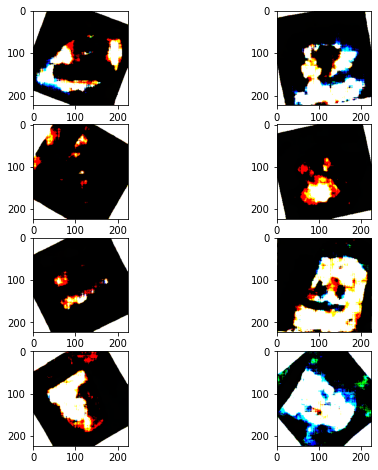

Reconstruction loss 38969.41015625 for epoch 31
_________________________________________
Reconstruction loss 32939.93359375 for epoch 32
_________________________________________
Reconstruction loss 31587.90234375 for epoch 33
_________________________________________
Reconstruction loss 39829.9765625 for epoch 34
_________________________________________
Reconstruction loss 32613.21484375 for epoch 35
_________________________________________
Reconstruction loss 26628.78515625 for epoch 36
_________________________________________
Reconstruction loss 35882.2578125 for epoch 37
_________________________________________
Reconstruction loss 43383.46875 for epoch 38
_________________________________________
Reconstruction loss 24067.7890625 for epoch 39
_________________________________________
Reconstruction loss 25506.703125 for epoch 40
_________________________________________


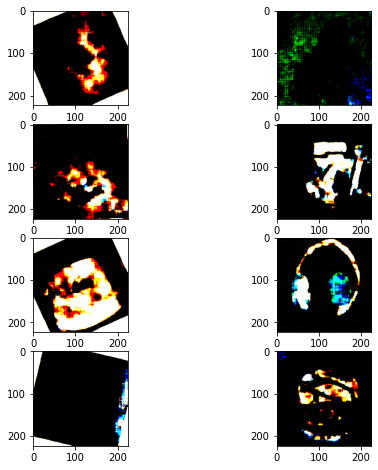

Reconstruction loss 24247.33984375 for epoch 41
_________________________________________
Reconstruction loss 33185.65625 for epoch 42
_________________________________________
Reconstruction loss 32742.84765625 for epoch 43
_________________________________________
Reconstruction loss 25937.85546875 for epoch 44
_________________________________________
Reconstruction loss 34107.359375 for epoch 45
_________________________________________
Reconstruction loss 33990.48046875 for epoch 46
_________________________________________
Reconstruction loss 25232.068359375 for epoch 47
_________________________________________
Reconstruction loss 38052.1796875 for epoch 48
_________________________________________
Reconstruction loss 31961.3828125 for epoch 49
_________________________________________
Reconstruction loss 28152.5234375 for epoch 50
_________________________________________


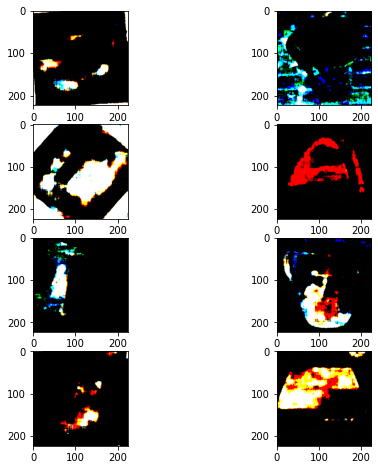

Reconstruction loss 21802.986328125 for epoch 51
_________________________________________
Reconstruction loss 36206.5234375 for epoch 52
_________________________________________
Reconstruction loss 32858.81640625 for epoch 53
_________________________________________
Reconstruction loss 28625.158203125 for epoch 54
_________________________________________
Reconstruction loss 27270.115234375 for epoch 55
_________________________________________
Reconstruction loss 46354.046875 for epoch 56
_________________________________________
Reconstruction loss 31330.66015625 for epoch 57
_________________________________________
Reconstruction loss 21702.2265625 for epoch 58
_________________________________________
Reconstruction loss 31793.77734375 for epoch 59
_________________________________________
Reconstruction loss 34363.765625 for epoch 60
_________________________________________


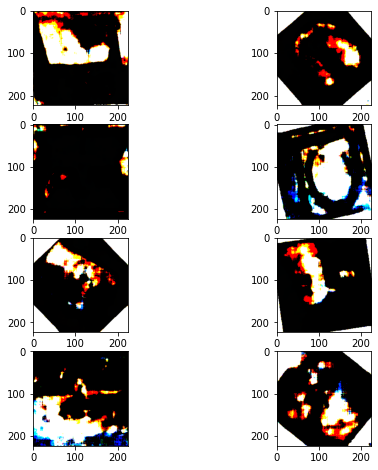

Reconstruction loss 32961.9765625 for epoch 61
_________________________________________
Reconstruction loss 36663.125 for epoch 62
_________________________________________
Reconstruction loss 31823.365234375 for epoch 63
_________________________________________
Reconstruction loss 26836.3828125 for epoch 64
_________________________________________
Reconstruction loss 23039.685546875 for epoch 65
_________________________________________
Reconstruction loss 34202.86328125 for epoch 66
_________________________________________
Reconstruction loss 34724.984375 for epoch 67
_________________________________________
Reconstruction loss 28497.3515625 for epoch 68
_________________________________________
Reconstruction loss 32273.669921875 for epoch 69
_________________________________________
Reconstruction loss 30415.22265625 for epoch 70
_________________________________________


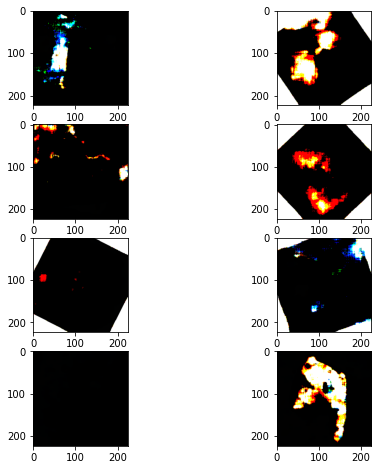

Reconstruction loss 33883.37890625 for epoch 71
_________________________________________
Reconstruction loss 28793.2421875 for epoch 72
_________________________________________
Reconstruction loss 38494.875 for epoch 73
_________________________________________
Reconstruction loss 30857.201171875 for epoch 74
_________________________________________
Reconstruction loss 24399.9609375 for epoch 75
_________________________________________
Reconstruction loss 22350.453125 for epoch 76
_________________________________________
Reconstruction loss 34780.2734375 for epoch 77
_________________________________________
Reconstruction loss 31221.0859375 for epoch 78
_________________________________________
Reconstruction loss 25989.908203125 for epoch 79
_________________________________________
Reconstruction loss 28960.86328125 for epoch 80
_________________________________________


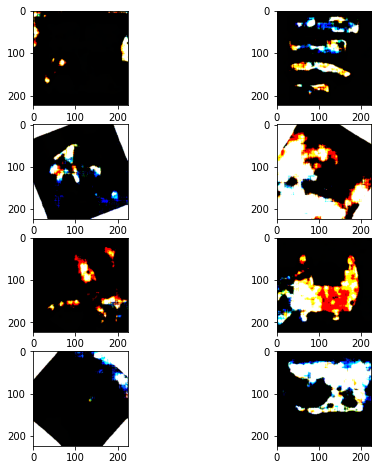

Reconstruction loss 23782.34375 for epoch 81
_________________________________________
Reconstruction loss 35616.3046875 for epoch 82
_________________________________________
Reconstruction loss 34402.4921875 for epoch 83
_________________________________________
Reconstruction loss 43277.640625 for epoch 84
_________________________________________
Reconstruction loss 23577.71875 for epoch 85
_________________________________________
Reconstruction loss 25817.75390625 for epoch 86
_________________________________________
Reconstruction loss 37114.40625 for epoch 87
_________________________________________
Reconstruction loss 34180.2421875 for epoch 88
_________________________________________
Reconstruction loss 34931.71875 for epoch 89
_________________________________________
Reconstruction loss 24952.7109375 for epoch 90
_________________________________________


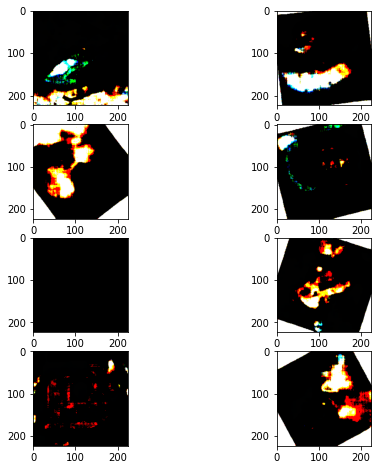

Reconstruction loss 34295.671875 for epoch 91
_________________________________________
Reconstruction loss 27943.94921875 for epoch 92
_________________________________________
Reconstruction loss 17218.435546875 for epoch 93
_________________________________________
Reconstruction loss 34027.3359375 for epoch 94
_________________________________________
Reconstruction loss 29758.205078125 for epoch 95
_________________________________________
Reconstruction loss 27387.033203125 for epoch 96
_________________________________________
Reconstruction loss 23872.658203125 for epoch 97
_________________________________________
Reconstruction loss 34487.15625 for epoch 98
_________________________________________
Reconstruction loss 33586.2109375 for epoch 99
_________________________________________
Reconstruction loss 38278.90625 for epoch 100
_________________________________________


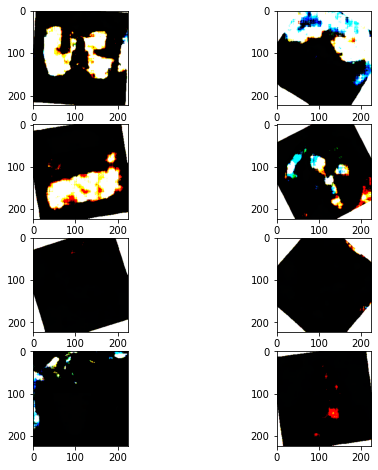

Reconstruction loss 25415.23046875 for epoch 101
_________________________________________
Reconstruction loss 32144.365234375 for epoch 102
_________________________________________
Reconstruction loss 38052.828125 for epoch 103
_________________________________________
Reconstruction loss 28553.04296875 for epoch 104
_________________________________________
Reconstruction loss 38662.5625 for epoch 105
_________________________________________
Reconstruction loss 37999.7109375 for epoch 106
_________________________________________
Reconstruction loss 34643.828125 for epoch 107
_________________________________________
Reconstruction loss 23080.98828125 for epoch 108
_________________________________________
Reconstruction loss 33310.3203125 for epoch 109
_________________________________________
Reconstruction loss 28013.4765625 for epoch 110
_________________________________________


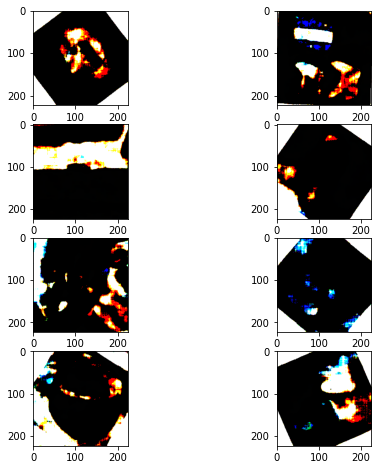

Reconstruction loss 27241.1484375 for epoch 111
_________________________________________
Reconstruction loss 24121.5234375 for epoch 112
_________________________________________
Reconstruction loss 22323.171875 for epoch 113
_________________________________________
Reconstruction loss 28230.0390625 for epoch 114
_________________________________________
Reconstruction loss 27205.9921875 for epoch 115
_________________________________________
Reconstruction loss 31465.9921875 for epoch 116
_________________________________________
Reconstruction loss 31973.21484375 for epoch 117
_________________________________________
Reconstruction loss 64245.1796875 for epoch 118
_________________________________________
Reconstruction loss 27775.0390625 for epoch 119
_________________________________________
Reconstruction loss 38000.72265625 for epoch 120
_________________________________________


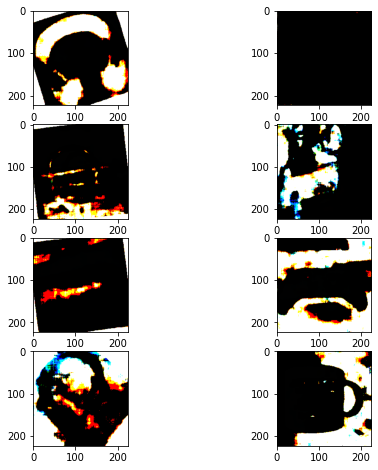

Reconstruction loss 31357.9609375 for epoch 121
_________________________________________
Reconstruction loss 27081.46875 for epoch 122
_________________________________________
Reconstruction loss 26205.74609375 for epoch 123
_________________________________________
Reconstruction loss 33708.66015625 for epoch 124
_________________________________________
Reconstruction loss 25689.880859375 for epoch 125
_________________________________________
Reconstruction loss 32779.8671875 for epoch 126
_________________________________________
Reconstruction loss 31814.564453125 for epoch 127
_________________________________________
Reconstruction loss 35212.34375 for epoch 128
_________________________________________
Reconstruction loss 29177.59765625 for epoch 129
_________________________________________
Reconstruction loss 27650.16796875 for epoch 130
_________________________________________


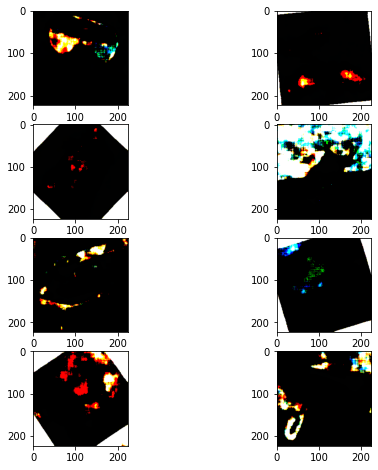

Reconstruction loss 32121.20703125 for epoch 131
_________________________________________
Reconstruction loss 30254.646484375 for epoch 132
_________________________________________
Reconstruction loss 30315.525390625 for epoch 133
_________________________________________
Reconstruction loss 27492.150390625 for epoch 134
_________________________________________
Reconstruction loss 31933.75390625 for epoch 135
_________________________________________
Reconstruction loss 32277.09375 for epoch 136
_________________________________________
Reconstruction loss 30067.24609375 for epoch 137
_________________________________________
Reconstruction loss 26678.291015625 for epoch 138
_________________________________________
Reconstruction loss 32086.2578125 for epoch 139
_________________________________________
Reconstruction loss 29256.21875 for epoch 140
_________________________________________


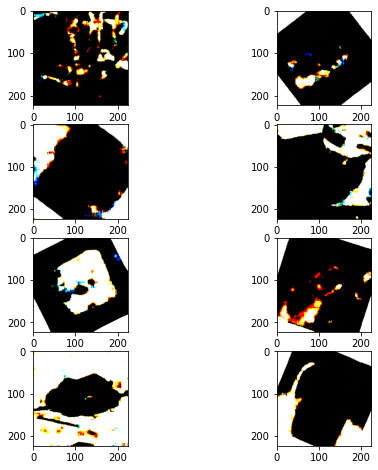

Reconstruction loss 31258.203125 for epoch 141
_________________________________________
Reconstruction loss 31143.09375 for epoch 142
_________________________________________
Reconstruction loss 23483.16015625 for epoch 143
_________________________________________
Reconstruction loss 28378.349609375 for epoch 144
_________________________________________
Reconstruction loss 37618.25390625 for epoch 145
_________________________________________
Reconstruction loss 35740.5546875 for epoch 146
_________________________________________
Reconstruction loss 26792.013671875 for epoch 147
_________________________________________
Reconstruction loss 34014.1640625 for epoch 148
_________________________________________
Reconstruction loss 36933.421875 for epoch 149
_________________________________________


In [ ]:
train_source,test_target, trainl_M = switch_source_target("","","", 8, False) ### GETTING ALL NEEEDED LOADERS   source =  Real Life, target = Product
autoencoder = Autoencoder(224,64)
autoencoder = autoencoder.to(device)
model = load_model_to_path(autoencoder, "drive/MyDrive/DL_Project/model_AE_Reall_s_new")
for_loss = training_autoencoder(model, train_source, 150, "AE_Reall_s")

This outcome was found to be robust both when only using the reconstruction loss, as well as when using all losses combinet together. The autoencoder wasn't really able to even reconstruct the image. By creating a smaller, simpler version of it, without ResNet's backbone, images were finally successfully reconstrcuted. Hence, the issue was found to be with both the _combination_ of all losses, and autoencoder's architecture with so little images. Below a snippet of reconstructed images after few epochs. 


![](https://drive.google.com/uc?export=view&id=1xF2jARJsH7pz5rIqos4wV3XHKlsqvCtw) ![](https://drive.google.com/uc?export=view&id=1Caj-GVbz9F_L5X-FoZFoCj6h2hxdHNpo)



#### Clustering 

In order to uncover the intrinsic discrimination of the target domain, we opt for direct clustering of target instances with structural regularization from the source domain. Target and source domain share the same label space. Based on this assumption, in order to pull instances from different classes further apart and pushing the ones of the same categories closer,  joint training represents a good option. Thus, implicit feature alignment is reached  in the latent space $Z$, where similar features are pushed into the same cluster. 
To leverage the information sourced by labelled source data, the clustering solution is constrained by the so called  _structural source regularization_, which hinges on the assumed structural similarity across domains. This approach differs from few other recent methods (citazione qui), which explictly align features by aligning cluster centers.  
Among various clustering methods, the authors chose a flexible framework of deep discriminative clustering, which minimizes the KL divergence between predictive label distribution of the network and an introduced auxiliary one. The auxiliary distribution is then replaced with that of ground-truth labels of source data, Structural source regularization has been simply implemented by a strategy of network joint training. Oppositely, this revised-SRDC, enhances structural regularization via the reconstruction loss.
The idea behind this approach is to have a visual overview of how well the model is able to reconstruct the image, thus the extent to which not only relevant features, but smaller characteristics-related ones are learned. Thus, back-propagated information is wheeled by twofold information:
* How well relevant and peculiar features are identified by the model itself  
* The extent to which the clustering algorithm succeeds in drifting different features apart, and pushing close ones together

Differently from the DEPICT, a simpler soft K-means algorithm has been used, for the sake of simplicity and comparison with the previously-led baseline analysis. Additionally, no soft-labels have been used for fine tuning. Training focuses mainly on training jointly the autoencoder and the generalization of the feature space.

In [ ]:
def cost_function_Cluster(x, r, centers, num_k=20):
    """Return distances from centers"""
    centers = centers.clone()
    x = x.clone()
    r = r.clone()
    cost = 0

    for k in range(num_k):
      
        norm = torch.linalg.norm(x - centers[k], 2)
        cost += (norm * torch.unsqueeze(r[:,k], dim=1)).sum()

    return cost

In [ ]:
class KMeansCriterion(torch.nn.Module):
    """KMeans Criterion with soft-assignments instead of hard ones"""
    def __init__(self):
        super().__init__()

    def forward(self, X, centers):
      
      X = X.clone() #copy of input, it is differentiable, so gradients will flow back from the result of this operation to input. 
      X = torch.exp(X) #avoid nan assumption of log output
      
      centers = centers.clone()
      p_hat = cluster_responsabilities(centers, X) 
      loss = cost_function_Cluster(X, p_hat, centers) #computing clustering loss  


      return loss, p_hat

In [ ]:
def initialize_centers(X, num_k=20):

    """
    @ARGS:
        -X : tensor of shape (N, D) where N is the number of data points and D is the dimensionality of the data points.
        -num_k : scalar, number of clusters.
    @Returns: tensor of shape (num_k, D) which contains the initial cluster centers, with each row representing a cluster center.
    """
    
    X = X.clone()
    N,D = X.shape 
    centers = torch.zeros(num_k, D)
    used_idx = []
    for k in range(num_k):
        idx = np.random.choice(N)
        used_idx.append(idx)
        centers[k] = X[idx]

    return centers

In [ ]:
def cluster_responsabilities(centers, x, beta=1):
    """Calculation of cluster responsibilities for x, using centers.
       Cluster responsibilities determine the degree of membership of each data point to each cluster.
       @ARGS: 
        - Centers: tensor of shape (K, D) where K is the number of clusters and D is the dimensionality of the data points.
        - X: tensor of shape (N, D) where N is the number of data points.Contains the data points for which we want to calculate the cluster responsibilities.
        - Beta: scalar determining the degree of responsibility assignment. The larger beta, the higher the responsibilities to the closest cluster center.
    """
    N, _ = x.shape
    K,D = centers.shape
    R = torch.zeros(N,K)
    for n in range(N):
        R[n] = torch.exp(-beta * torch.linalg.norm(centers - x[n], 2, dim=1))
        R /= R.sum(dim=1, keepdim=True)
        R = R.to(device)
    return R.clone()

In [ ]:
def update_centers(x,r,num_k=20):
    """Updating cluster centroids given cluster responsibilities and data points
      @ARGS: 
        - X: tensor of shape (N, D) where N is the number of data points and D is the dimensionality of the data points.
        - r: tensor of shape (N, K) where N is the number of data points and K is the number of clusters. Contains the cluster responsibilities.
        - num_K: scalar, number of clusters
    """
    x = x.clone()
    r = r.clone()
    N,D = x.shape
    centers = torch.zeros(num_k,D)
    for k in range(num_k):
        centers[k] = r[:, k].matmul(x) / r[:,k].sum()
        centers =  centers.to(device)
    return centers.clone()

In [ ]:
def Soft_Clustering(X, num_k, max_iters = 50, beta = 1, chart = True):
    """Soft clustering algorithm.
       @ARGS: 
        - X: tensor of shape (N, D) where N is the number of data points and D is the dimensionality of the data points.
        - num_k: scalar, number of clusters.
        - max_iters: max number of iterations for the algorithm.
    """
    centers = initialize_centers(X, num_k)
    prev_cost = 0 
    for _ in range(max_iters):
        r = cluster_responsabilities(centers, X, beta) #auxiliiary distribution for Q
        centers = update_centers(X,r,num_k)
        cost = cost_function_Cluster(X,r,centers, num_k)

        prev_cost = cost

### Deep discriminative target clustering

The core of the presented algorithm can be summarised to one main loss (structurally regularized deep clustering loss, $L_{SRDC}$), obtained by summing $L^{t}_{SRDC}$ and  $L^{s}_{SRDC}$, respectively the loss on the target domain and the one on the source domain. 
$L^{t}_{SRDC}$ and  $L^{s}_{SRDC}$ can be further split as follows. 
$L^t_{SRDC} = L^t_{f \circ \varphi} + L^t{\varphi}$, where:
* The former objective aims to enhance the uncovering of the target discrimination via the clustering algorithm
* The latter is modelled on the whole model


#### First element: $L^t_{f\circ \varphi}$

$L^t_{f \circ \varphi} = KL(Q^{t}||p^{t}) + \sum_{k=1}^{K} q^{t} \log{q^t_k}$ 


The loss above can be decoupled onto two concepts: the extent to which the auxiliary probability distribution Q differs from the soft-max probability tensor,  and a regularization term. Only considering the divergence between Q and P might lead to assign most of the samples to just a few clusters or assign a cluster to outlier samples, yielding unbalanced frequency of clusters. However, to really uncover target discrimination and its true distribution, a regularization term and a further objective are added.  This introduction allows to add some information regarding a _prior_ (here a Normal distribution is considered), enforcing more balanced predictions indirectly.
In the reference paper, this enhancement is consolidated via discriminative clustering in the feature space $Z$, where an EM algorithm is applied. However, the purpose of this very analysis is based on using the objective over a simpler soft-cluster assignment, namely K-Means, for two main reasons:
+ Results obtained over the reduced latent space of with the base model (ResNet18) turned out to be already very interesting for the scope of this project. Thus the idea behind would be to replicate the same undergone study with a more complex model which would take into account the target distribution as well.
+ The combination of an EM algorithm and the CAE would have resulted in a more complex model, which has been considered too out of bounds for the purpose of this project. 

A considerable remark has to be made regarding the first objective, since it is not guaranteed to converge, due to the lack of constraints for the auxiliary distribution $Q^t$. To solve this issue, a data-dependent loss has been implemented, namely the reconstruction loss. This allows to keep track of the actual distribution of data to obtain more sensible solutions. 
Overall, the idea behind this first objective is to:
+ Update the auxiliary distribution Q according to the information yielded by $P^t$.
+ Updating the network: the auxiliary distribution is fixed in terms of the new distribution $p^t$, and thus it is equivalent to training the network via a simpler cross-entropy loss.

#### Second element: $L^t{\varphi}$

$L^t{\varphi} = KL(\tilde{Q^{t}}||\tilde{p^{t}}) + \sum_{k=1}^{K} \tilde{q^{t}}\log{\tilde{q^t_k}}$ 

The objective above mimics the first defined loss with respect to the terms used: namely, a KL divergence and a regularizer. However, to enhance the uncovering of target discrimination, information from the learnable cluster centers of both source and target is exacted in the latent space $Z$. A probability vector of soft cluster assignments is then defined, and an auxiliary vector is continuously updated. Thus, centroids are updated at every training iteration via this objective minimization (its back propagated gradients). 
The idea behind this approach is to indirectly enhance clustering performance by redirecting encoder's learning according to soft-assignment outcomes.

### Structural source regularization

The point above redirects to the concept of regularization: both domains share the same label space, therefore joint training would -ideally- push instances of the two domains from same classes into same regions in the latent space $Z_m$ thus implicitly achieving feature alignment between the two domains (fig1 paper).
For the labeled source data $\{(x^s_j, y^s_j)\}^{n_s}_{j=1}$, the auxiliary distribution is replaced with the one formed by the grounds truth labels $\{y^s_j\}{n_s}_{j=1}$, resulting in a supervised network training via cross-entropy minimization:

$L^s_{f \circ \varphi} = -1/n_s \sum_{j=1}^{n_s} \sum_{k=1}^{K} I[k = y_j^s] \log{p^s_{j,k}}$ 
where $p^s_{j,k}$ is the $k^{th}$ element of the predictive probability vector $p^s_j$ of source instance $x_j^s$, and $I[.]$ is the function of indicator. 
Thus, the same logic as for the target domain is followed for the source domain, introducing the so-called source regularization. Namely, source discrimination is also enhanced in $Z$ by minimizing the following:

$L^s{\varphi} = -1/n_s \sum_{j=1}^{n_s} \sum_{k=1}^{K} I[k = y_j^s] \log{\tilde {p^s_{j,k}}}$



where $\tilde{p^s_{j,k}} = \frac{\exp{((1 + ||z^s_j - \mu_k||^2)^{-1})}}{\sum_{k'=1}^{K}\exp{((1 + ||z^s_j - \mu_k||^2)^{-1})}}$. \\
Logically, $L^s_{SRDC} =L^s{\varphi} +  L^t_{f \circ \varphi}$ is the structural source regularizer. This enables to monitor -supervisedly- a similar data distribution to the target one, and enables to introduce some information of a similar priori to the above-mentioned objectives to minimize, while still learning additional information of the target distribution.


#### Structural source regularization 

The algorithm tries to align the distributions of two different datasets, one from a target domain and one from a source domain. The function takes in the model, an optimizer, a criterion, the target and source training data, a path, the number of clusters, and some other optional parameters.
There are two training stages, first with the target domain data, and then with the source domain data. For the target domain, the model is passed the data, and the encoder embedding, encoder softmax, and decoder reconstructed are extracted. Then the cluster loss is calculated by comparing the encoder embedding to the centers of the clusters. An auxiliary distribution is also calculated from the encoder softmax, and a KL divergence loss is calculated between this auxiliary distribution and the encoder softmax.

For the source domain, data is passed to the model, and the encoder softmax, and decoder reconstructed are extracted. Then a cross-entropy loss is calculated between the encoder softmax and the true labels of the source data. The cluster loss is also calculated by comparing the encoder embedding to the centers of the clusters.


In [ ]:
class Autoencoder(nn.Module):
  """Re-adapted for the clustering algorithm 
      @ARGS:
        - Encoder: only returns the embedding space and the softmax output for source labels
        - Decoder: return the reconstructed input.
  """
  def __init__(self, 
              base_channel_size: int,
              latent_dim: int,
              encoder_class : object = Encoder_N, #Encoder_N
              decoder_class : object = Decoder_N, #Decoder_N
              num_input_channels: int = 3):
        super().__init__()
        # Saving hyperparameters of autoencoder
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)

  def forward(self, x):

    enc, p = self.encoder(x)
    x_hat = self.decoder(enc)
    return enc, p, x_hat

  def _get_reconstruction_loss(self, batch):
    """
    Given a batch of images, this function returns the reconstruction loss (MSE in our case)
    """
    x, _ = batch # We do not need the labels
    x = x.to(device)
    x_hat = self.forward(x)
    loss = F.mse_loss(x, x_hat, reduction="none")
    loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
    return loss, x_hat

  def configure_optimizers(self, model_params):
      """@Returns:
          - Optimizer with given scheduler"""
      optimizer = torch.optim.Adam(model_params, lr=1e-8)
      optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                            mode='min',
                                            factor=0.05,
                                            patience=15,
                                             min_lr=1e-13)
     
 
      # Scheuler reduces the LR if the validation performance hasn't improved for the last N epochs
      return optimizer 

  def training_step(self, batch):
      loss, x_hat = self._get_reconstruction_loss(batch)
      
      return loss, x_hat

In [ ]:
lst = [] # To plot the loss 

In [ ]:
def train(model, optimizer, criterion, train_target, train_source, path:str, n_clus = 20,
          print_every=100, verbose=False, recon_loss= True):
    '''path: product or real life '''
    
    kl_loss = nn.KLDivLoss(reduction="batchmean") # aligns with the mathematical definition

   
    model.train()
    # Iterating over the two domains
    
    for i, (dataT, dataS) in enumerate(zip(cycle(train_target), train_source)):
        
        loss_print = 0 
        # Target Data
        Xt_var, yt_var = dataT 
        Xt_var = Xt_var.to(device)
        yt_var = yt_var.to(device)
        # Source Data
        Xs_var, ys_var = dataS 
        Xs_var = Xs_var.to(device)
        ys_var = ys_var.to(device)

        ### TARGET ------------------------------------------------------------

        # forward pass and compute loss
     
        XT, pT, XT_rec  = model(Xt_var) #encoder embedding, encoder softmax, decoder reconstructed
        
   

        if i == 0:
          centersT = initialize_centers(XT) #initializing centers given the extracted features by the encoder
          centersT = centersT.to(device)
       
        cluster_lossT, pT_hat = criterion(XT, centersT)  #computing the cluster loss 
        pT_hat.detach_() #detaching from training graph (softmax output)
       
        # Computing the auxiliary distribution Q
        rT_sumoveri = torch.sqrt(torch.sum(pT_hat,dim=0))
        numT = pT_hat/rT_sumoveri   
        qT_hat = numT/(torch.sum(numT,dim=0))  # Auxiliary distribution loss 

        cluster_lossT1 = -1*torch.mean(qT_hat*pT_hat)/n_clus 
        kl_hat_loss =  kl_loss(qT_hat, pT_hat) 
       
        if (recon_loss == True) : 
  
          recon_loss = F.mse_loss(XT_rec, Xt_var)
          depict_loss = recon_loss  + cluster_lossT1 + kl_hat_loss
        else : 
          ## COMPUTING DEPICT LOSS ENHANCED WITHOUT RECONSTRUCTION LOSS 
          depict_loss = cluster_lossT1 + kl_hat_loss

        ## COMPUTING THE CLUSTER LOSS 
        rT_sumoveri = torch.sqrt(torch.sum(pT,dim=0))
        num2T = pT/rT_sumoveri

        qT = num2T/(torch.sum(num2T,dim=0))  # Auxiliary distribution loss 
        kl_loss_t =  kl_loss(qT, pT) 
        cluster_lossT2 = -1*torch.mean(qT*pT)/n_clus 
        fophi_loss = kl_loss_t + cluster_lossT2 
        # TARGET LOSS
        target_loss = depict_loss + fophi_loss 

        

        ### SOURCE ----------------------------------------------------------- 

        # forward pass and compute loss
     
        XS, pS, XS_rec = model(Xs_var)
       
    
        if i == 0:
          centersS = initialize_centers(XS)
          centersS = centersS.to(device)

        # Cross Entropy with the vector of probabilities
        CEloss = nn.CrossEntropyLoss()
        LossS1 = CEloss(pS, ys_var)
        # Cross Entropy with the vector of soft cluster assignement
        cluster_lossS, pS_hat = criterion(XS, centersS)  
        pS_hat.detach_()
        LossS2 = CEloss(pS_hat, ys_var)
        ## SOURCE LOSS 
        source_loss = LossS1 + LossS2 

        # FINAL LOSS 
        loss = target_loss + source_loss
        # run update step
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        centers = update_centers(XS, pS_hat)
        centers.detach_()
        loss_print += loss
        
        
       
        loss_print = loss_print/len(train_target)  
        lst.append((i, loss_print))
            
    try: 
      save_checkpoint(model.encoder, model.encoder.state_dict(), optimizer.state_dict(), loss, f"drive/MyDrive/DL_Project/checkpoint_encoder_{path}") 
      save_checkpoint(model.decoder, model.decoder.state_dict(), optimizer.state_dict(), loss, f"drive/MyDrive/DL_Project/checkpoint_decoder_{path}")  
    except:  
      save_checkpoint(model, model.state_dict(), optimizer.state_dict(), loss, f"drive/MyDrive/DL_Project/checkpoint_encoder_{path}") 
      
  # update centroids based on assignments from autoencoders
    
    return loss_print.item(), XT_rec

In [ ]:
def testing(net, testing_loader, cost_function, device, phase) : 
  """Testing step"""
  val_acc = [] 
  val_err = []
  test_err = []
  test_acc = []


  samp_s = []
  samp_v = []
  
  total = 0.0
  samples = 0.0
  running_loss = 0.0
  running_accuracy = 0.0
  samp = []

  net.eval() 
  loss_print = 0.0
  with torch.no_grad():

    # iterate over the test set
    for batch_idx, (img,lab) in enumerate(testing_loader):
      
     # load data into GPU
      img= img.to(device)
      lab = lab.to(device)
        
      # forward pass
      _, outputs = net(img)
      loss = cost_function(outputs, lab)
      #_, y_pred_tags = torch.max(outputs, dim = 1)    

      #correct_pred = (y_pred_tags == lab).float()
      acc = accuracy(outputs, lab)
      #acc = correct_pred.sum() / len(correct_pred)
      running_accuracy += torch.round(acc * 100)
      loss_print += loss 

    loss_print/len(testing_loader)
    print('Test loss', loss_print.item())
    print('Accuracy', running_accuracy.item()/len(testing_loader))


      

In [ ]:
def main(trainS,
         trainT,
         test,
         epochs,
         autoencoder,
         name,
         optional=150, #where it usually stops
         device='cuda:0', 
         visualization_name='centered', 
         recon_loss=True):

  
  try: #First we look whether the model has been interruped and already saved. The value for the epoch to start from is fixed because it interrupts around 150/200 most of the time
    model = load_model_to_path(autoencoder,f"drive/MyDrive/DL_Project/checkpoint_decoder_{name}_depict")
    optimizer =  autoencoder.configure_optimizers(model.parameters())
  except: #We load the model from scratch
    try:
      optimizer =  autoencoder.configure_optimizers(autoencoder.parameters())
      model, optimizer, epoch = resume_checkpoint(autoencoder,optional, optimizer, f"drive/MyDrive/DL_Project/checkpoint_{name}_depict", train = True) 
      optimizer = autoencoder.configure_optimizers(autoencoder.parameters())
    except:
       optimizer =  autoencoder.configure_optimizers(autoencoder.parameters())
       model = autoencoder
    
  # Defining the clustering criterion
  criterion = KMeansCriterion()
  criterion.to(device)
  
  # If the reconstruction loss is active we only use the autoencoder
  if (recon_loss == True) : 
    model = autoencoder.to(device)

  else :
    encoder = model.encoder



  for e in range(epochs) : 
    print('-----------------------------------------------------')
    print('Currently at epoch {}/{}'.format(e+1,epochs))
    if (recon_loss == True) : 
      loss, x_hat = train(model, optimizer, criterion, train_target, train_source, name, recon_loss=recon_loss) 
    else :
      loss, x_hat = train(encoder, optimizer, criterion, train_target, train_source, name, recon_loss=recon_loss) 

    print("Loss: ", loss )
    if ( (e % 10) == 0) : 
        plot_results(x_hat)

   
    save_checkpoint(e, autoencoder.state_dict(), optimizer.state_dict(), loss, f"drive/MyDrive/DL_Project/checkpoint_{name}_depict") 
    
    if (recon_loss == True) :
      save_checkpoint(e, model.decoder.state_dict(), optimizer.state_dict(), loss, f"drive/MyDrive/DL_Project/checkpoint_decoder_{name}_depict") 
    else :
      save_checkpoint(e, encoder.state_dict(), optimizer.state_dict(), loss, f"drive/MyDrive/DL_Project/checkpoint_encoder_{name}_depict") 
  
  
  try:
    save_model_to_path(encoder, f"drive/MyDrive/DL_Project/{name}_depict_final")
  except:
    pass
  if (recon_loss == True) :
    save_model_to_path(model, f"drive/MyDrive/DL_Project/{name}_full_depict")
    
      

  # compute and print final metrics
  print('\n')
  print('-----------------------------------------------------')
  print('After training:')

  testing(model.encoder, test_target, nn.CrossEntropyLoss(),device,'Test')


Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
<All keys matched successfully>
-----------------------------------------------------
Currently at epoch 1/200
Loss:  0.00011973737127846107


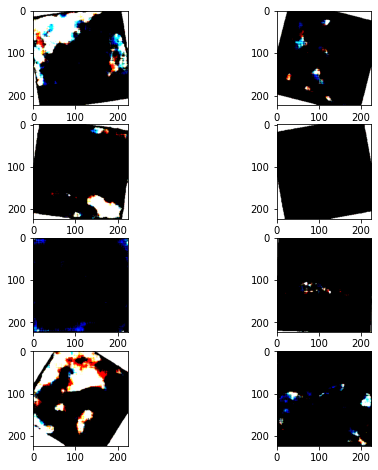

-----------------------------------------------------
Currently at epoch 2/200
Loss:  7.788814400555566e-06
-----------------------------------------------------
Currently at epoch 3/200
Loss:  -7.02060860930942e-05
-----------------------------------------------------
Currently at epoch 4/200
Loss:  0.00010813670814968646
-----------------------------------------------------
Currently at epoch 5/200
Loss:  5.079383481643163e-05
-----------------------------------------------------
Currently at epoch 6/200
Loss:  -0.00018269837892148644
-----------------------------------------------------
Currently at epoch 7/200
Loss:  -1.730563053570222e-05
-----------------------------------------------------
Currently at epoch 8/200
Loss:  -0.00020774727454409003
-----------------------------------------------------
Currently at epoch 9/200
Loss:  6.20642676949501e-05
-----------------------------------------------------
Currently at epoch 10/200
Loss:  3.731713513843715e-05
----------------------

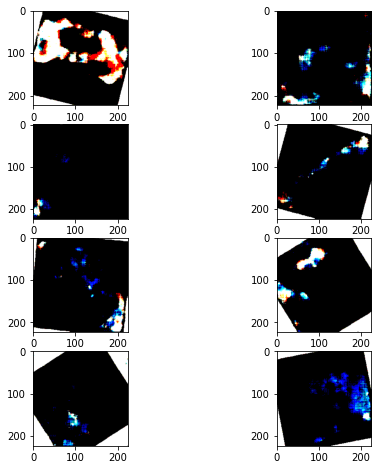

-----------------------------------------------------
Currently at epoch 12/200
Loss:  0.00018144151545129716
-----------------------------------------------------
Currently at epoch 13/200
Loss:  -8.87842325028032e-05
-----------------------------------------------------
Currently at epoch 14/200
Loss:  -2.0011502783745527e-05
-----------------------------------------------------
Currently at epoch 15/200
Loss:  4.880819687969051e-05
-----------------------------------------------------
Currently at epoch 16/200
Loss:  0.00010783921607071534
-----------------------------------------------------
Currently at epoch 17/200
Loss:  -5.799051723442972e-05
-----------------------------------------------------
Currently at epoch 18/200
Loss:  0.00017014546028804034
-----------------------------------------------------
Currently at epoch 19/200
Loss:  -0.00011646214261418208
-----------------------------------------------------
Currently at epoch 20/200
Loss:  -9.777723607840016e-05
----------

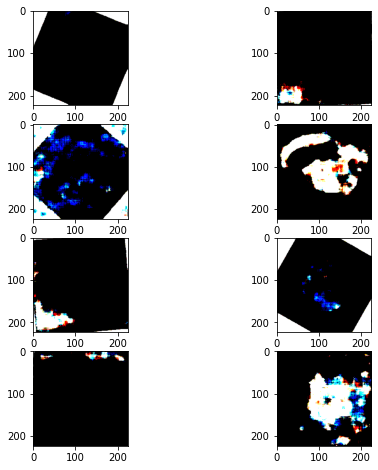

-----------------------------------------------------
Currently at epoch 22/200
Loss:  -5.904240424570162e-06
-----------------------------------------------------
Currently at epoch 23/200
Loss:  -0.00015689508290961385
-----------------------------------------------------
Currently at epoch 24/200
Loss:  -0.00014600895519834012
-----------------------------------------------------
Currently at epoch 25/200
Loss:  -0.00013856319128535688
-----------------------------------------------------
Currently at epoch 26/200
Loss:  -0.0001961195666808635
-----------------------------------------------------
Currently at epoch 27/200
Loss:  -0.00015176802116911858
-----------------------------------------------------
Currently at epoch 28/200
Loss:  -0.00025327311595901847
-----------------------------------------------------
Currently at epoch 29/200
Loss:  -0.0002207457146141678
-----------------------------------------------------
Currently at epoch 30/200
Loss:  -0.00011401674419175833
----

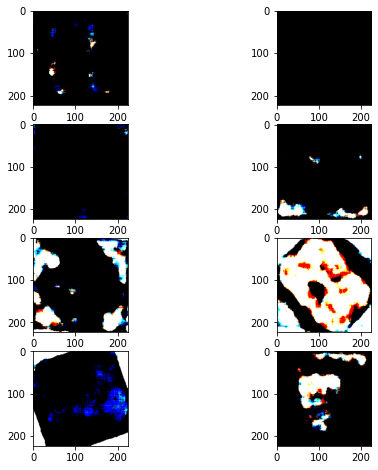

-----------------------------------------------------
Currently at epoch 32/200
Loss:  -0.00017862605454865843
-----------------------------------------------------
Currently at epoch 33/200
Loss:  -0.00021444576850626618
-----------------------------------------------------
Currently at epoch 34/200
Loss:  -0.00023890681040938944
-----------------------------------------------------
Currently at epoch 35/200
Loss:  3.117945743724704e-05
-----------------------------------------------------
Currently at epoch 36/200
Loss:  -0.00025556053151376545
-----------------------------------------------------
Currently at epoch 37/200
Loss:  -0.00023797305766493082
-----------------------------------------------------
Currently at epoch 38/200
Loss:  -7.088077836669981e-05
-----------------------------------------------------
Currently at epoch 39/200
Loss:  -0.00014377423212863505
-----------------------------------------------------
Currently at epoch 40/200
Loss:  -0.00018748952425085008
----

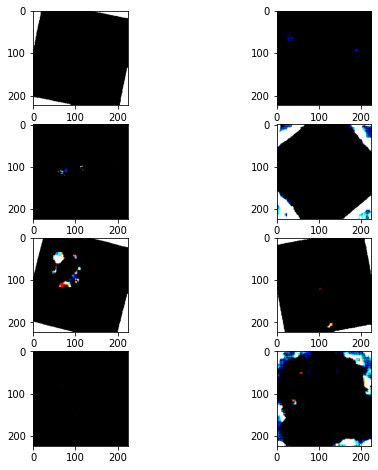

-----------------------------------------------------
Currently at epoch 42/200
Loss:  -0.0002457006776239723
-----------------------------------------------------
Currently at epoch 43/200
Loss:  -0.0002259838074678555
-----------------------------------------------------
Currently at epoch 44/200
Loss:  -0.0002418731601210311
-----------------------------------------------------
Currently at epoch 45/200
Loss:  -0.00022717233514413238
-----------------------------------------------------
Currently at epoch 46/200
Loss:  -0.0002369325520703569
-----------------------------------------------------
Currently at epoch 47/200
Loss:  -0.00022416329011321068
-----------------------------------------------------
Currently at epoch 48/200
Loss:  -0.0002562224108260125
-----------------------------------------------------
Currently at epoch 49/200
Loss:  -0.00027313659666106105
-----------------------------------------------------
Currently at epoch 50/200
Loss:  -0.00020162382861599326
------

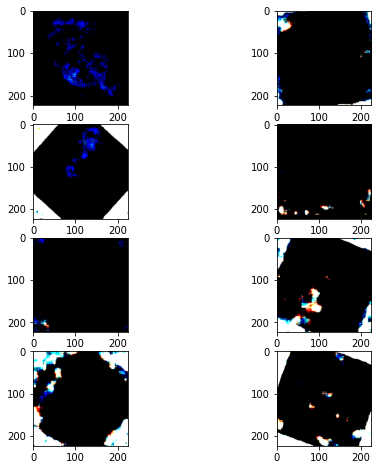

-----------------------------------------------------
Currently at epoch 52/200
Loss:  -0.00024426018353551626
-----------------------------------------------------
Currently at epoch 53/200
Loss:  -0.00019571816665120423
-----------------------------------------------------
Currently at epoch 54/200
Loss:  -0.0002089087647618726
-----------------------------------------------------
Currently at epoch 55/200
Loss:  -0.00021656521130353212
-----------------------------------------------------
Currently at epoch 56/200
Loss:  -0.00019923964282497764
-----------------------------------------------------
Currently at epoch 57/200
Loss:  -0.00021444293088279665
-----------------------------------------------------
Currently at epoch 58/200
Loss:  -8.538374095223844e-05
-----------------------------------------------------
Currently at epoch 59/200
Loss:  -0.00023561876150779426
-----------------------------------------------------
Currently at epoch 60/200
Loss:  -0.00025337704573757946
---

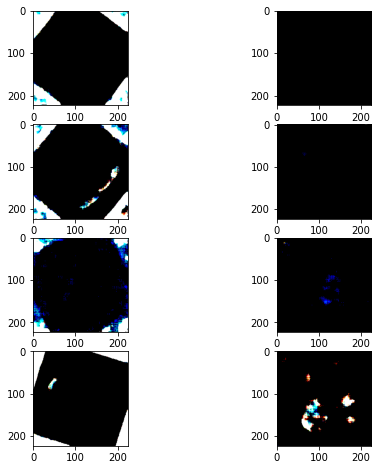

-----------------------------------------------------
Currently at epoch 62/200
Loss:  -0.00021569551608990878
-----------------------------------------------------
Currently at epoch 63/200
Loss:  -0.0002449576568324119
-----------------------------------------------------
Currently at epoch 64/200
Loss:  -0.0003240186779294163
-----------------------------------------------------
Currently at epoch 65/200
Loss:  6.0010312154190615e-05
-----------------------------------------------------
Currently at epoch 66/200
Loss:  -0.00022565358085557818
-----------------------------------------------------
Currently at epoch 67/200
Loss:  -0.00031180024961940944
-----------------------------------------------------
Currently at epoch 68/200
Loss:  -0.0003475260455161333
-----------------------------------------------------
Currently at epoch 69/200
Loss:  -0.0002985911560244858
-----------------------------------------------------
Currently at epoch 70/200
Loss:  -0.00018260728393215686
------

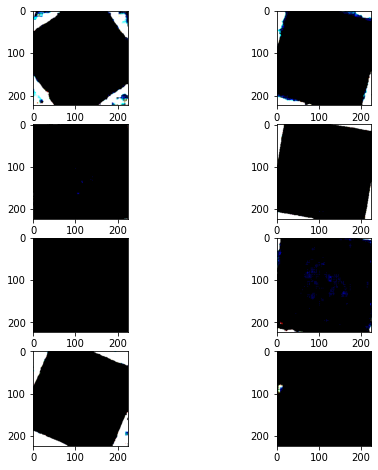

-----------------------------------------------------
Currently at epoch 72/200
Loss:  -0.00032791451667435467
-----------------------------------------------------
Currently at epoch 73/200
Loss:  -0.00027815549401566386
-----------------------------------------------------
Currently at epoch 74/200
Loss:  -0.0002630974049679935
-----------------------------------------------------
Currently at epoch 75/200
Loss:  -0.00021955576085019857
-----------------------------------------------------
Currently at epoch 76/200
Loss:  -0.0003260043158661574
-----------------------------------------------------
Currently at epoch 77/200
Loss:  -0.0002547292679082602
-----------------------------------------------------
Currently at epoch 78/200
Loss:  -0.0003101548063568771
-----------------------------------------------------
Currently at epoch 79/200
Loss:  -0.00033602502662688494
-----------------------------------------------------
Currently at epoch 80/200
Loss:  -0.0003173927834723145
------

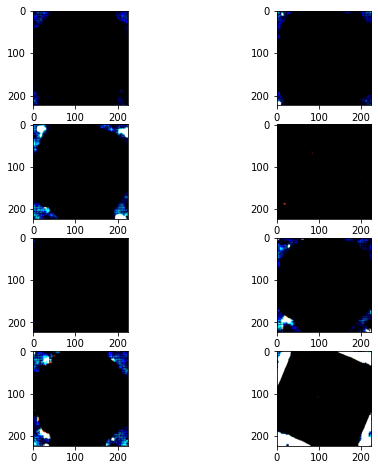

-----------------------------------------------------
Currently at epoch 82/200
Loss:  -0.0003291087341494858
-----------------------------------------------------
Currently at epoch 83/200
Loss:  -0.0002579817082732916
-----------------------------------------------------
Currently at epoch 84/200
Loss:  -0.0003369089390616864
-----------------------------------------------------
Currently at epoch 85/200
Loss:  -0.00032827179529704154
-----------------------------------------------------
Currently at epoch 86/200
Loss:  -0.0003336849622428417
-----------------------------------------------------
Currently at epoch 87/200
Loss:  -0.00028594856848940253
-----------------------------------------------------
Currently at epoch 88/200
Loss:  -0.0003145089722238481
-----------------------------------------------------
Currently at epoch 89/200
Loss:  -0.0003698633809108287
-----------------------------------------------------
Currently at epoch 90/200
Loss:  -0.00027729434077627957
-------

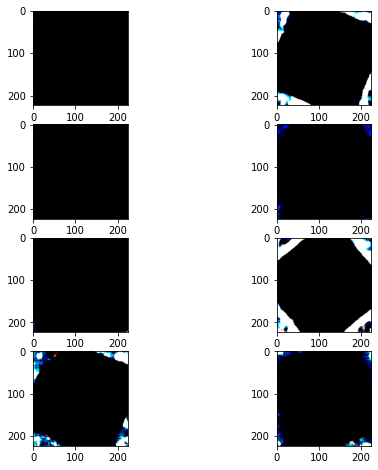

-----------------------------------------------------
Currently at epoch 92/200
Loss:  -0.0003277949581388384
-----------------------------------------------------
Currently at epoch 93/200
Loss:  -0.0003075969871133566
-----------------------------------------------------
Currently at epoch 94/200
Loss:  -0.00035425584064796567
-----------------------------------------------------
Currently at epoch 95/200
Loss:  -0.00028471447876654565
-----------------------------------------------------
Currently at epoch 96/200
Loss:  -0.0003200189385097474
-----------------------------------------------------
Currently at epoch 97/200
Loss:  -0.00027279354981146753
-----------------------------------------------------
Currently at epoch 98/200
Loss:  -0.0003357203968334943
-----------------------------------------------------
Currently at epoch 99/200
Loss:  -0.0003346699522808194
-----------------------------------------------------
Currently at epoch 100/200
Loss:  -0.00025886850198730826
-----

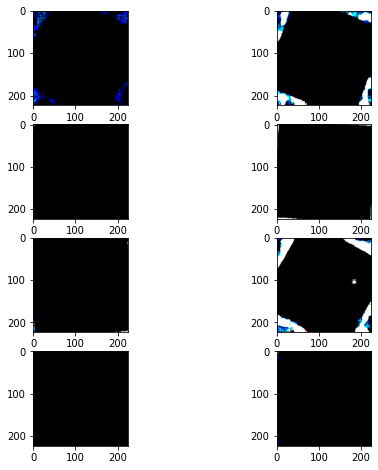

-----------------------------------------------------
Currently at epoch 102/200
Loss:  -0.00029034685576334596
-----------------------------------------------------
Currently at epoch 103/200
Loss:  -0.0003380505077075213
-----------------------------------------------------
Currently at epoch 104/200
Loss:  -0.00034468210651539266
-----------------------------------------------------
Currently at epoch 105/200
Loss:  -0.0002732276916503906
-----------------------------------------------------
Currently at epoch 106/200
Loss:  -0.00034877436701208353
-----------------------------------------------------
Currently at epoch 107/200
Loss:  -0.0003044726327061653
-----------------------------------------------------
Currently at epoch 108/200
Loss:  -0.00034235199564136565
-----------------------------------------------------
Currently at epoch 109/200
Loss:  -0.00032879700302146375
-----------------------------------------------------
Currently at epoch 110/200
Loss:  -0.0003400403948035

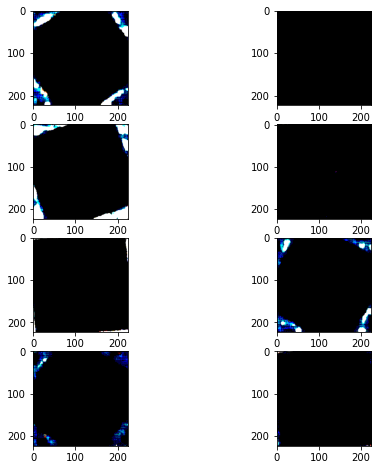

-----------------------------------------------------
Currently at epoch 112/200


In [ ]:
train_source,test_target, trainl_M = switch_source_target("","","", 8, True) ### GETTING ALL NEEEDED LOADERS   source =  Product, target = Real Life
train_target,test_source, trainl_M = switch_source_target("","","", 8, False)
autoencoder = Autoencoder(224,64)
autoencoder = autoencoder.to(device)
epochs = 200
main(train_source, train_target, test_target, epochs, autoencoder, "model_AE_Product_s_new")



In [ ]:
train_source,test_target, trainl_M = switch_source_target("","","", 8, True) ### GETTING ALL NEEEDED LOADERS   source =  Product, target = Real Life
train_target,test_source, trainl_M = switch_source_target("","","", 8, False)


Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.


dict_keys(['epoch', 'model_state_dict', 'loss', 'optimizer_state_dict'])
-----------------------------------------------------
Currently at epoch 1/100
Loss:  -0.0003667461278382689


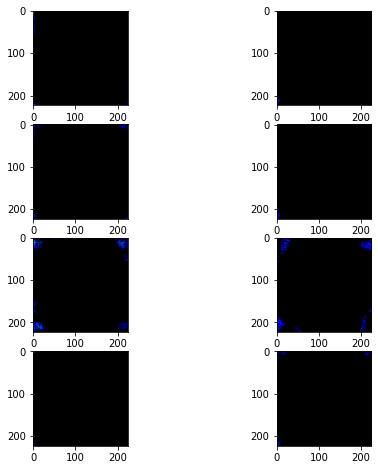

-----------------------------------------------------
Currently at epoch 2/100
Loss:  -0.0003600604541134089
-----------------------------------------------------
Currently at epoch 3/100
Loss:  -0.0003646736731752753
-----------------------------------------------------
Currently at epoch 4/100
Loss:  -0.00036817806540057063
-----------------------------------------------------
Currently at epoch 5/100
Loss:  -0.0003679731162264943
-----------------------------------------------------
Currently at epoch 6/100
Loss:  -0.00036741228541359305
-----------------------------------------------------
Currently at epoch 7/100
Loss:  -0.00037065905053168535
-----------------------------------------------------
Currently at epoch 8/100
Loss:  -0.00036564728361554444
-----------------------------------------------------
Currently at epoch 9/100
Loss:  -0.0003664031100925058
-----------------------------------------------------
Currently at epoch 10/100
Loss:  -0.000373245362425223
---------------

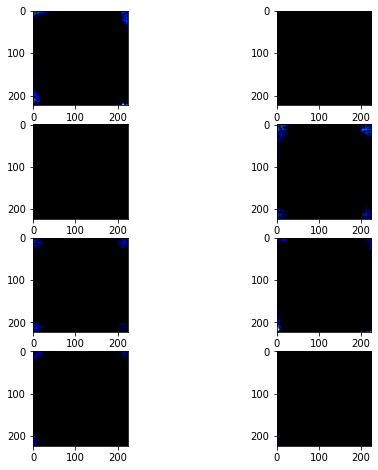

-----------------------------------------------------
Currently at epoch 12/100
Loss:  -0.000377158256014809
-----------------------------------------------------
Currently at epoch 13/100
Loss:  -0.00036541526787914336
-----------------------------------------------------
Currently at epoch 14/100
Loss:  -0.0003751270705834031
-----------------------------------------------------
Currently at epoch 15/100
Loss:  -0.00036885275039821863
-----------------------------------------------------
Currently at epoch 16/100
Loss:  -0.0003699530498124659
-----------------------------------------------------
Currently at epoch 17/100
Loss:  -0.0003688840661197901
-----------------------------------------------------
Currently at epoch 18/100
Loss:  -0.00037045549834147096
-----------------------------------------------------
Currently at epoch 19/100
Loss:  -0.0003720027452800423
-----------------------------------------------------
Currently at epoch 20/100
Loss:  -0.00037119851913303137
-------

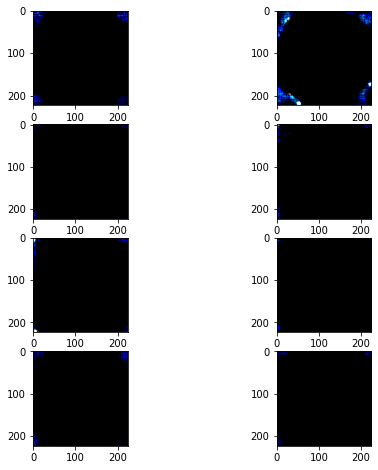

-----------------------------------------------------
Currently at epoch 22/100
Loss:  -0.00037053663982078433
-----------------------------------------------------
Currently at epoch 23/100
Loss:  -0.00037031600368209183
-----------------------------------------------------
Currently at epoch 24/100
Loss:  -0.0003682236128952354
-----------------------------------------------------
Currently at epoch 25/100
Loss:  -0.00036614120472222567
-----------------------------------------------------
Currently at epoch 26/100
Loss:  -0.0003711287572514266
-----------------------------------------------------
Currently at epoch 27/100
Loss:  -0.0003695914929267019
-----------------------------------------------------
Currently at epoch 28/100
Loss:  -0.00036985339829698205
-----------------------------------------------------
Currently at epoch 29/100
Loss:  -0.00036963136517442763
-----------------------------------------------------
Currently at epoch 30/100
Loss:  -0.00036696248571388423
----

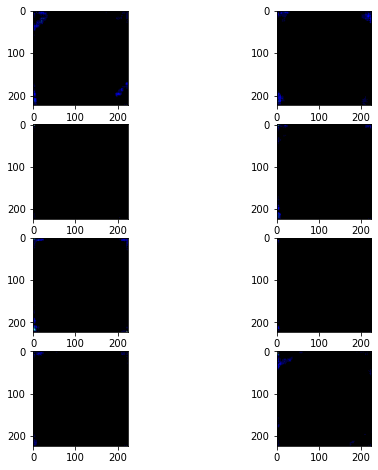

-----------------------------------------------------
Currently at epoch 32/100
Loss:  -0.00036800725501962006
-----------------------------------------------------
Currently at epoch 33/100
Loss:  -0.0003694918705150485
-----------------------------------------------------
Currently at epoch 34/100
Loss:  -0.00037244398845359683
-----------------------------------------------------
Currently at epoch 35/100
Loss:  -0.00036387942964211106
-----------------------------------------------------
Currently at epoch 36/100
Loss:  -0.00036830190219916403
-----------------------------------------------------
Currently at epoch 37/100
Loss:  -0.0003638580674305558
-----------------------------------------------------
Currently at epoch 38/100
Loss:  -0.00036903779255226254
-----------------------------------------------------
Currently at epoch 39/100
Loss:  -0.0003735755744855851
-----------------------------------------------------
Currently at epoch 40/100
Loss:  -0.0003677524800878018
-----

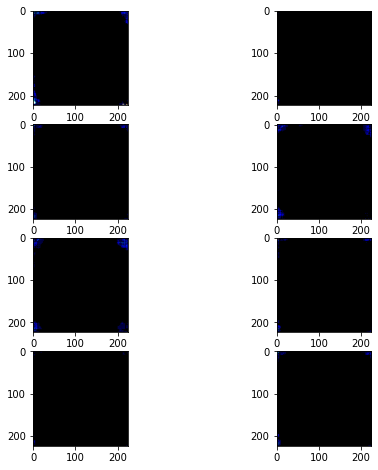

-----------------------------------------------------
Currently at epoch 42/100
Loss:  -0.00036882999120280147
-----------------------------------------------------
Currently at epoch 43/100
Loss:  -0.0003743029374163598
-----------------------------------------------------
Currently at epoch 44/100
Loss:  -0.0003713493933901191
-----------------------------------------------------
Currently at epoch 45/100
Loss:  -0.0003745961585082114
-----------------------------------------------------
Currently at epoch 46/100
Loss:  -0.0003721308312378824
-----------------------------------------------------
Currently at epoch 47/100
Loss:  -0.0003696427447721362
-----------------------------------------------------
Currently at epoch 48/100
Loss:  -0.000368516833987087
-----------------------------------------------------
Currently at epoch 49/100
Loss:  -0.0003711785830091685
-----------------------------------------------------
Currently at epoch 50/100
Loss:  -0.0003692384925670922
----------

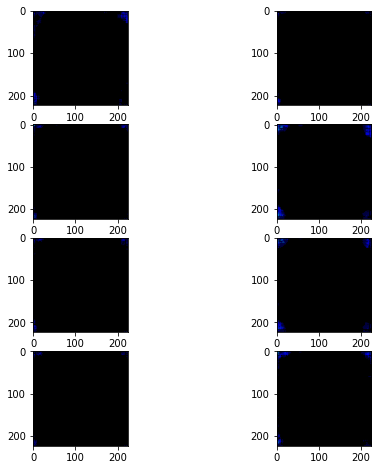

-----------------------------------------------------
Currently at epoch 52/100
Loss:  -0.0003667005803436041
-----------------------------------------------------
Currently at epoch 53/100
Loss:  -0.00036913459189236164
-----------------------------------------------------
Currently at epoch 54/100
Loss:  -0.00037267885636538267
-----------------------------------------------------
Currently at epoch 55/100
Loss:  -0.00037106755189597607
-----------------------------------------------------
Currently at epoch 56/100
Loss:  -0.0003699174558278173
-----------------------------------------------------
Currently at epoch 57/100
Loss:  -0.0003699017979670316
-----------------------------------------------------
Currently at epoch 58/100
Loss:  -0.00036891395575366914
-----------------------------------------------------
Currently at epoch 59/100
Loss:  -0.00037629567668773234
-----------------------------------------------------
Currently at epoch 60/100
Loss:  -0.00036981498124077916
----

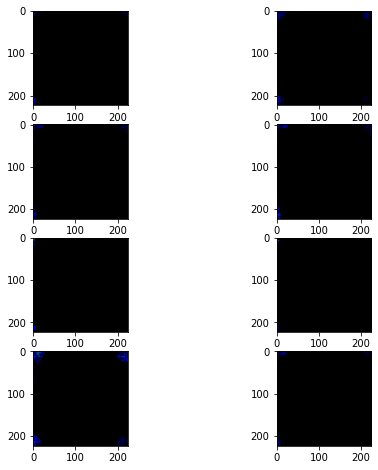

-----------------------------------------------------
Currently at epoch 62/100
Loss:  -0.00037221054662950337
-----------------------------------------------------
Currently at epoch 63/100
Loss:  -0.0003717137733474374
-----------------------------------------------------
Currently at epoch 64/100
Loss:  -0.00037033308763056993
-----------------------------------------------------
Currently at epoch 65/100
Loss:  -0.0003712355101015419
-----------------------------------------------------
Currently at epoch 66/100
Loss:  -0.00037313433131203055
-----------------------------------------------------
Currently at epoch 67/100
Loss:  -0.00036682156496681273
-----------------------------------------------------
Currently at epoch 68/100
Loss:  -0.0003703345137182623
-----------------------------------------------------
Currently at epoch 69/100
Loss:  -0.0003742645203601569
-----------------------------------------------------
Currently at epoch 70/100
Loss:  -0.0003710277087520808
------

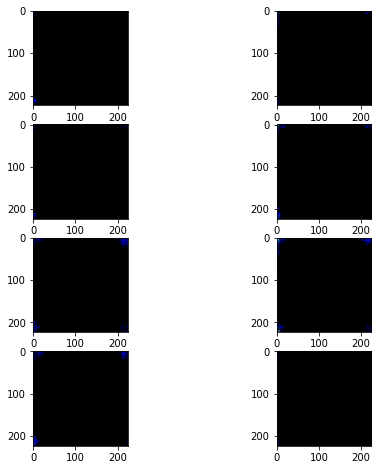

-----------------------------------------------------
Currently at epoch 72/100
Loss:  -0.0003678891225717962
-----------------------------------------------------
Currently at epoch 73/100
Loss:  -0.00037117148167453706
-----------------------------------------------------
Currently at epoch 74/100
Loss:  -0.00036861933767795563
-----------------------------------------------------
Currently at epoch 75/100
Loss:  -0.0003708867880050093
-----------------------------------------------------
Currently at epoch 76/100
Loss:  -0.0003640715731307864
-----------------------------------------------------
Currently at epoch 77/100
Loss:  -0.0003717280051205307
-----------------------------------------------------
Currently at epoch 78/100
Loss:  -0.0003694391925819218
-----------------------------------------------------
Currently at epoch 79/100
Loss:  -0.00037201555096544325
-----------------------------------------------------
Currently at epoch 80/100
Loss:  -0.0003705722338054329
-------

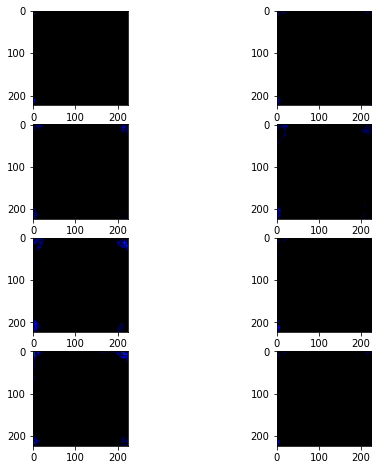

-----------------------------------------------------
Currently at epoch 82/100
Loss:  -0.0003712654288392514
-----------------------------------------------------
Currently at epoch 83/100
Loss:  -0.0003718603984452784
-----------------------------------------------------
Currently at epoch 84/100
Loss:  -0.0003678435750771314
-----------------------------------------------------
Currently at epoch 85/100
Loss:  -0.00037345458986237645
-----------------------------------------------------
Currently at epoch 86/100
Loss:  -0.00037127110408619046
-----------------------------------------------------
Currently at epoch 87/100
Loss:  -0.00037433853140100837
-----------------------------------------------------
Currently at epoch 88/100
Loss:  -0.00037347167381085455
-----------------------------------------------------
Currently at epoch 89/100
Loss:  -0.00036883141729049385
-----------------------------------------------------
Currently at epoch 90/100
Loss:  -0.0003657312481664121
-----

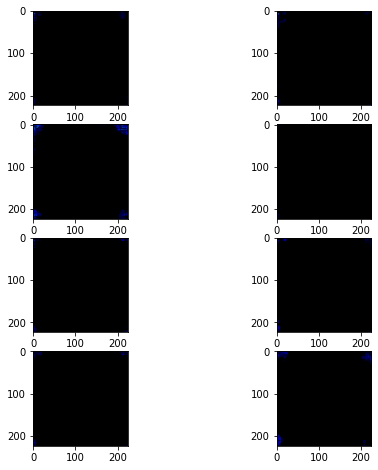

-----------------------------------------------------
Currently at epoch 92/100
Loss:  -0.00037450221134349704
-----------------------------------------------------
Currently at epoch 93/100
Loss:  -0.00037593700108118355
-----------------------------------------------------
Currently at epoch 94/100
Loss:  -0.00037558114854618907
-----------------------------------------------------
Currently at epoch 95/100
Loss:  -0.00037512992275878787
-----------------------------------------------------
Currently at epoch 96/100
Loss:  -0.00036696961615234613
-----------------------------------------------------
Currently at epoch 97/100
Loss:  -0.00037419190630316734
-----------------------------------------------------
Currently at epoch 98/100
Loss:  -0.0003666877746582031
-----------------------------------------------------
Currently at epoch 99/100
Loss:  -0.0003714718041010201
-----------------------------------------------------
Currently at epoch 100/100
Loss:  -0.00037447945214807987




In [ ]:
epochs = 100
autoencoder = Autoencoder(224,64)
autoencoder = autoencoder.to(device)
optimizer = autoencoder.configure_optimizers(autoencoder.parameters())
main(train_source, train_target, test_target, epochs, autoencoder, "model_AE_Product_s_new")

![](https://drive.google.com/uc?export=view&id=1M-ZY-4eQtYK0tP-hVMgpz21bKY-Tf95v)

The aformentioned logic has been translated to code represented in the training algorithm, displayed above, together with the testing step. The main() function calls both steps and saves at each epoch a checkpoint of the weights, and after testing the model itself. By willing to exploit the checkpoint functionality, the goal is to perform a kind of model selection, where only the model reaching the best accuracy is chosen. 
To get a quick feedback on the main hypothesis, the algorithm has been tested on few epochs (10), as well as to get a hint of how well the model would behave.

Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
-----------------------------------------------------
Currently at epoch 1/200
Loss:  -0.0004054845485370606


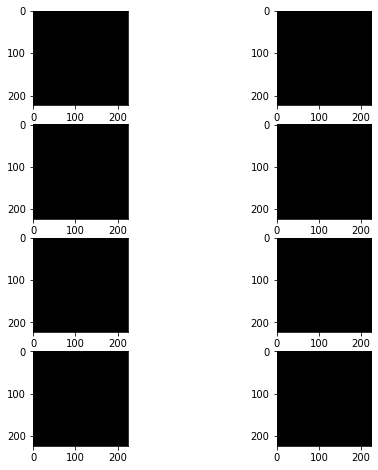

-----------------------------------------------------
Currently at epoch 2/200
Loss:  -0.0004057198530063033
-----------------------------------------------------
Currently at epoch 3/200
Loss:  -0.0004062107182107866
-----------------------------------------------------
Currently at epoch 4/200
Loss:  -0.00040643979446031153
-----------------------------------------------------
Currently at epoch 5/200
Loss:  -0.00040678572258912027
-----------------------------------------------------
Currently at epoch 6/200
Loss:  -0.0004068356065545231
-----------------------------------------------------
Currently at epoch 7/200
Loss:  -0.0004067982081323862
-----------------------------------------------------
Currently at epoch 8/200
Loss:  -0.0004071565927006304
-----------------------------------------------------
Currently at epoch 9/200
Loss:  -0.00040718153468333185
-----------------------------------------------------
Currently at epoch 10/200
Loss:  -0.00040664704283699393
--------------

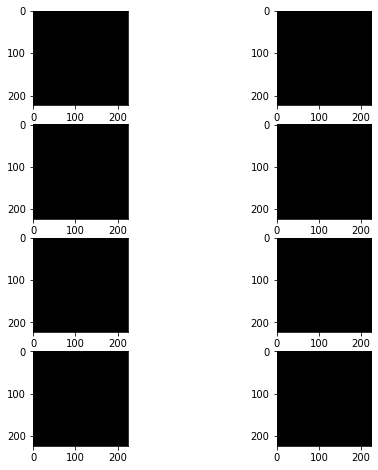

-----------------------------------------------------
Currently at epoch 12/200
Loss:  -0.0004063135711476207
-----------------------------------------------------
Currently at epoch 13/200
Loss:  -0.0004069104033987969
-----------------------------------------------------
Currently at epoch 14/200
Loss:  -0.0004069337737746537
-----------------------------------------------------
Currently at epoch 15/200
Loss:  -0.0004069228598382324
-----------------------------------------------------
Currently at epoch 16/200
Loss:  -0.0004076303157489747
-----------------------------------------------------
Currently at epoch 17/200
Loss:  -0.0004070475115440786
-----------------------------------------------------
Currently at epoch 18/200
Loss:  -0.0004069587157573551
-----------------------------------------------------
Currently at epoch 19/200
Loss:  -0.0004067654663231224
-----------------------------------------------------
Currently at epoch 20/200
Loss:  -0.0004066314722876996
----------

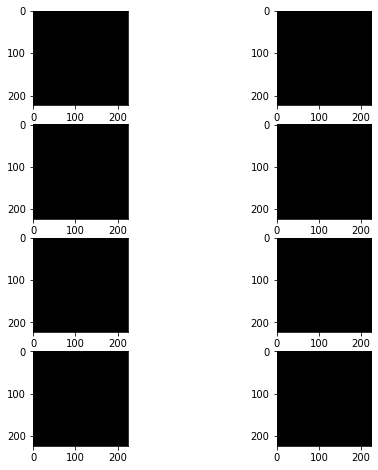

-----------------------------------------------------
Currently at epoch 22/200
Loss:  -0.00040655821794644
-----------------------------------------------------
Currently at epoch 23/200
Loss:  -0.0004067608097102493
-----------------------------------------------------
Currently at epoch 24/200
Loss:  -0.00040675923810340464
-----------------------------------------------------
Currently at epoch 25/200
Loss:  -0.0004078703059349209
-----------------------------------------------------
Currently at epoch 26/200
Loss:  -0.00040709582390263677
-----------------------------------------------------
Currently at epoch 27/200
Loss:  -0.0004068371490575373
-----------------------------------------------------
Currently at epoch 28/200
Loss:  -0.0004062652587890625
-----------------------------------------------------
Currently at epoch 29/200
Loss:  -0.00040671872557140887
-----------------------------------------------------
Currently at epoch 30/200
Loss:  -0.0004070521972607821
---------

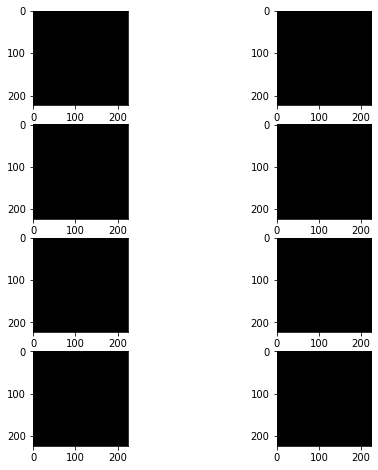

-----------------------------------------------------
Currently at epoch 32/200
Loss:  -0.0004065130196977407
-----------------------------------------------------
Currently at epoch 33/200
Loss:  -0.0004072407609783113
-----------------------------------------------------
Currently at epoch 34/200
Loss:  -0.00040757577517069876
-----------------------------------------------------
Currently at epoch 35/200
Loss:  -0.0004070085706189275
-----------------------------------------------------
Currently at epoch 36/200
Loss:  -0.0004071488219778985
-----------------------------------------------------
Currently at epoch 37/200
Loss:  -0.00040714259375818074
-----------------------------------------------------
Currently at epoch 38/200
Loss:  -0.00040741529664956033
-----------------------------------------------------
Currently at epoch 39/200
Loss:  -0.0004066875553689897
-----------------------------------------------------
Currently at epoch 40/200
Loss:  -0.00040716439252719283
------

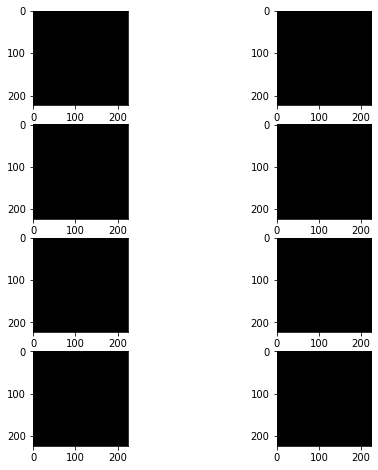

-----------------------------------------------------
Currently at epoch 42/200
Loss:  -0.0004081430088263005
-----------------------------------------------------
Currently at epoch 43/200
Loss:  -0.0004084375104866922
-----------------------------------------------------
Currently at epoch 44/200
Loss:  -0.0004067810659762472
-----------------------------------------------------
Currently at epoch 45/200
Loss:  -0.00040775342495180666
-----------------------------------------------------
Currently at epoch 46/200
Loss:  -0.0004071410221513361
-----------------------------------------------------
Currently at epoch 47/200
Loss:  -0.00040717062074691057
-----------------------------------------------------
Currently at epoch 48/200
Loss:  -0.0004076428012922406
-----------------------------------------------------
Currently at epoch 49/200
Loss:  -0.00040751189226284623
-----------------------------------------------------
Currently at epoch 50/200
Loss:  -0.0004072625597473234
-------

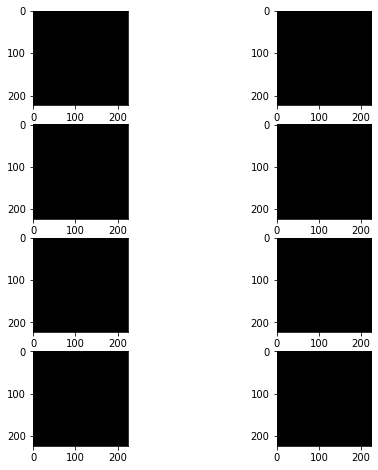

-----------------------------------------------------
Currently at epoch 52/200
Loss:  -0.0004059255588799715
-----------------------------------------------------
Currently at epoch 53/200
Loss:  -0.0004073576128575951
-----------------------------------------------------
Currently at epoch 54/200
Loss:  -0.00040685429121367633
-----------------------------------------------------
Currently at epoch 55/200
Loss:  -0.00040643822285346687
-----------------------------------------------------
Currently at epoch 56/200
Loss:  -0.0004067046975251287
-----------------------------------------------------
Currently at epoch 57/200
Loss:  -0.00040612812153995037
-----------------------------------------------------
Currently at epoch 58/200
Loss:  -0.0004062091757077724
-----------------------------------------------------
Currently at epoch 59/200
Loss:  -0.0004054082091897726
-----------------------------------------------------
Currently at epoch 60/200
Loss:  -0.000406294857384637
--------

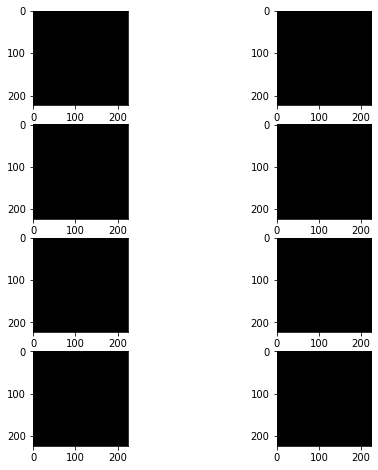

-----------------------------------------------------
Currently at epoch 62/200
Loss:  -0.00040689014713279903
-----------------------------------------------------
Currently at epoch 63/200
Loss:  -0.00040647873538546264
-----------------------------------------------------
Currently at epoch 64/200
Loss:  -0.0004056606558151543
-----------------------------------------------------
Currently at epoch 65/200
Loss:  -0.0004070459690410644
-----------------------------------------------------
Currently at epoch 66/200
Loss:  -0.0004069057176820934
-----------------------------------------------------
Currently at epoch 67/200
Loss:  -0.00040741372504271567
-----------------------------------------------------
Currently at epoch 68/200
Loss:  -0.00040855127735994756
-----------------------------------------------------
Currently at epoch 69/200
Loss:  -0.00040736698429100215
-----------------------------------------------------
Currently at epoch 70/200
Loss:  -0.00040837362757883966
----

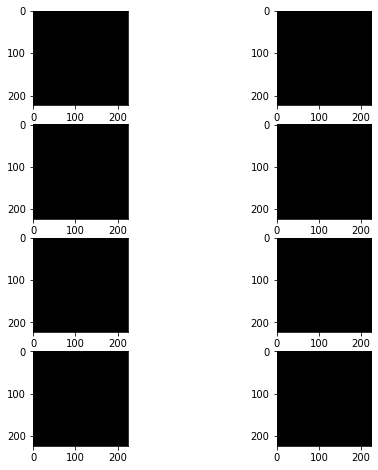

-----------------------------------------------------
Currently at epoch 72/200
Loss:  -0.0004092041926924139
-----------------------------------------------------
Currently at epoch 73/200
Loss:  -0.0004082552040927112
-----------------------------------------------------
Currently at epoch 74/200
Loss:  -0.00040923693450167775
-----------------------------------------------------
Currently at epoch 75/200
Loss:  -0.0004069104033987969
-----------------------------------------------------
Currently at epoch 76/200
Loss:  -0.000410852866480127
-----------------------------------------------------
Currently at epoch 77/200
Loss:  -0.0004087008710484952
-----------------------------------------------------
Currently at epoch 78/200
Loss:  -0.0004075555189047009
-----------------------------------------------------
Currently at epoch 79/200
Loss:  -0.0004060174978803843
-----------------------------------------------------
Currently at epoch 80/200
Loss:  -0.0004088208661414683
----------

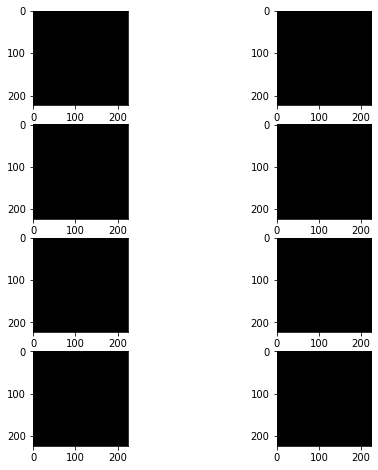

-----------------------------------------------------
Currently at epoch 82/200
Loss:  -0.00040756643284112215
-----------------------------------------------------
Currently at epoch 83/200
Loss:  -0.0004067935224156827
-----------------------------------------------------
Currently at epoch 84/200
Loss:  -0.0004051433061249554
-----------------------------------------------------
Currently at epoch 85/200
Loss:  -0.00040501082548871636
-----------------------------------------------------
Currently at epoch 86/200
Loss:  -0.00040919173625297844
-----------------------------------------------------
Currently at epoch 87/200
Loss:  -0.00040403223829343915
-----------------------------------------------------
Currently at epoch 88/200
Loss:  -0.0004109074070584029
-----------------------------------------------------
Currently at epoch 89/200
Loss:  -0.00040684183477424085
-----------------------------------------------------
Currently at epoch 90/200
Loss:  -0.00040549857658334076
----

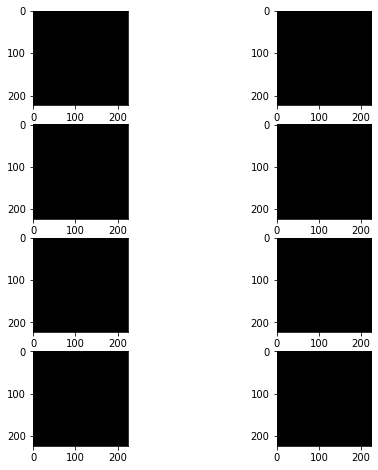

-----------------------------------------------------
Currently at epoch 92/200
Loss:  -0.00041303603211417794
-----------------------------------------------------
Currently at epoch 93/200
Loss:  -0.0004063867963850498
-----------------------------------------------------
Currently at epoch 94/200
Loss:  -0.00040617489139549434
-----------------------------------------------------
Currently at epoch 95/200
Loss:  -0.00040876163984648883
-----------------------------------------------------
Currently at epoch 96/200
Loss:  -0.0004093849565833807
-----------------------------------------------------
Currently at epoch 97/200
Loss:  -0.0004209069593343884
-----------------------------------------------------
Currently at epoch 98/200
Loss:  -0.000402883772039786
-----------------------------------------------------
Currently at epoch 99/200
Loss:  -0.00041337418952025473
-----------------------------------------------------
Currently at epoch 100/200
Loss:  -0.00041597808012738824
-----

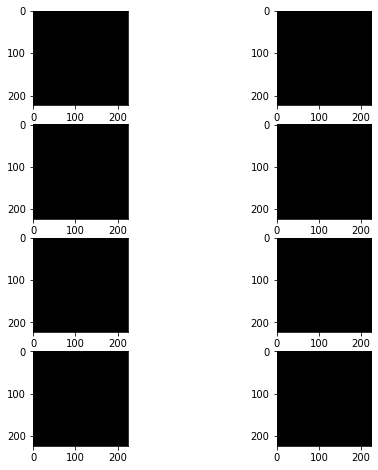

-----------------------------------------------------
Currently at epoch 102/200
Loss:  -0.000410712615121156
-----------------------------------------------------
Currently at epoch 103/200
Loss:  -0.00040837362757883966
-----------------------------------------------------
Currently at epoch 104/200
Loss:  -0.0004080853541381657
-----------------------------------------------------
Currently at epoch 105/200
Loss:  -0.00041231143404729664
-----------------------------------------------------
Currently at epoch 106/200
Loss:  -0.00040444673504680395
-----------------------------------------------------
Currently at epoch 107/200
Loss:  -0.0004079762729816139
-----------------------------------------------------
Currently at epoch 108/200
Loss:  -0.0004043875087518245
-----------------------------------------------------
Currently at epoch 109/200
Loss:  -0.00040293362690135837
-----------------------------------------------------
Currently at epoch 110/200
Loss:  -0.000409294589189812

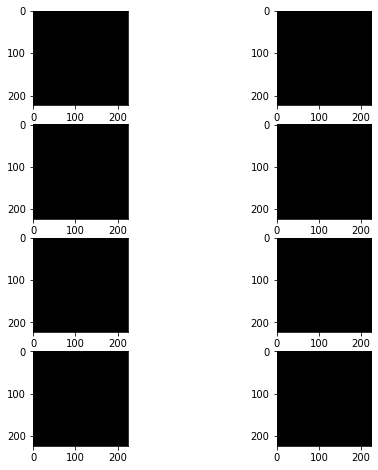

-----------------------------------------------------
Currently at epoch 112/200
Loss:  -0.000407510349759832
-----------------------------------------------------
Currently at epoch 113/200
Loss:  -0.0004069119459018111
-----------------------------------------------------
Currently at epoch 114/200
Loss:  -0.0004028541734442115
-----------------------------------------------------
Currently at epoch 115/200
Loss:  -0.00040803547017276287
-----------------------------------------------------
Currently at epoch 116/200
Loss:  -0.00040373927913606167
-----------------------------------------------------
Currently at epoch 117/200
Loss:  -0.0004179041425231844
-----------------------------------------------------
Currently at epoch 118/200
Loss:  -0.00040449193329550326
-----------------------------------------------------
Currently at epoch 119/200
Loss:  -0.00039815279887989163
-----------------------------------------------------
Currently at epoch 120/200
Loss:  -0.000409551692428067

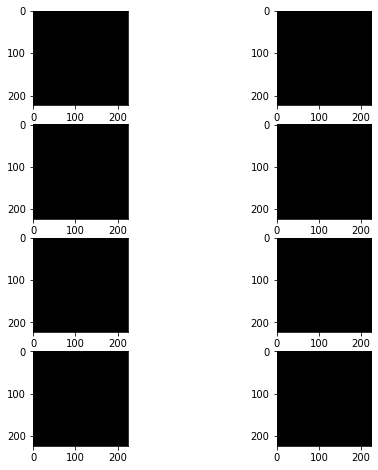

-----------------------------------------------------
Currently at epoch 122/200
Loss:  -0.00040480203460901976
-----------------------------------------------------
Currently at epoch 123/200
Loss:  -0.00039919998380355537
-----------------------------------------------------
Currently at epoch 124/200
Loss:  -0.00038603864959441125
-----------------------------------------------------
Currently at epoch 125/200
Loss:  -0.00041058953502215445
-----------------------------------------------------
Currently at epoch 126/200
Loss:  -0.00038903835229575634
-----------------------------------------------------
Currently at epoch 127/200
Loss:  -0.00039361504605039954
-----------------------------------------------------
Currently at epoch 128/200
Loss:  -0.0004113873583264649
-----------------------------------------------------
Currently at epoch 129/200
Loss:  -0.000403521116822958
-----------------------------------------------------
Currently at epoch 130/200
Loss:  -0.0004342085449025

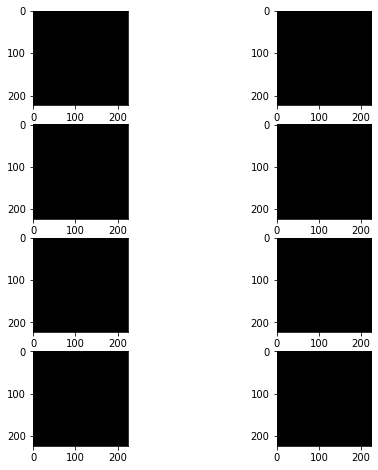

-----------------------------------------------------
Currently at epoch 132/200
Loss:  -0.00039708070107735693
-----------------------------------------------------
Currently at epoch 133/200
Loss:  -0.0003787442692555487
-----------------------------------------------------
Currently at epoch 134/200
Loss:  -0.00040231342427432537
-----------------------------------------------------
Currently at epoch 135/200
Loss:  -0.0003943209594581276
-----------------------------------------------------
Currently at epoch 136/200
Loss:  -0.0004008455143775791
-----------------------------------------------------
Currently at epoch 137/200
Loss:  -0.0003870702348649502
-----------------------------------------------------
Currently at epoch 138/200
Loss:  -0.0005530843627639115
-----------------------------------------------------
Currently at epoch 139/200
Loss:  -0.00038045839755795896
-----------------------------------------------------
Currently at epoch 140/200
Loss:  -0.000423029356170445

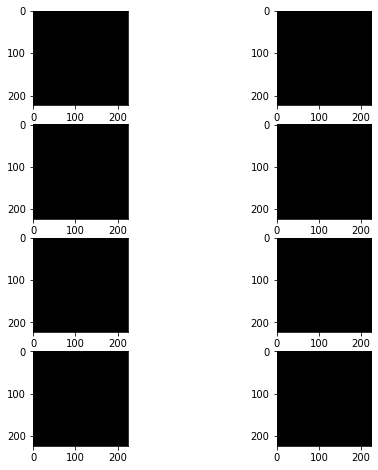

-----------------------------------------------------
Currently at epoch 142/200
Loss:  -0.0003888092760462314
-----------------------------------------------------
Currently at epoch 143/200
Loss:  -0.0003657029301393777
-----------------------------------------------------
Currently at epoch 144/200
Loss:  -0.000398283707909286
-----------------------------------------------------
Currently at epoch 145/200
Loss:  -0.0004047210095450282
-----------------------------------------------------
Currently at epoch 146/200
Loss:  -0.00039933709194883704
-----------------------------------------------------
Currently at epoch 147/200
Loss:  -0.0004115478659514338
-----------------------------------------------------
Currently at epoch 148/200
Loss:  -0.0005049019819125533
-----------------------------------------------------
Currently at epoch 149/200
Loss:  -0.00040929458918981254
-----------------------------------------------------
Currently at epoch 150/200
Loss:  -0.00037481114850379527

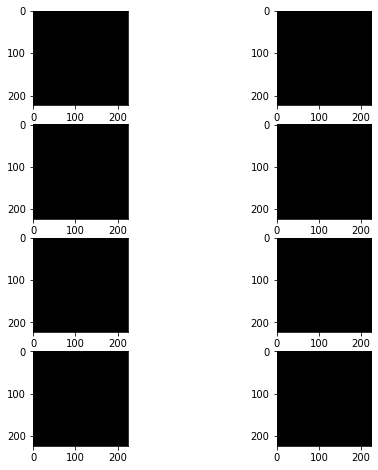

-----------------------------------------------------
Currently at epoch 152/200
Loss:  -0.00038929234142415226
-----------------------------------------------------
Currently at epoch 153/200
Loss:  -0.0005224545602686703
-----------------------------------------------------
Currently at epoch 154/200
Loss:  -0.0005661966279149055
-----------------------------------------------------
Currently at epoch 155/200
Loss:  -0.0005450311000458896
-----------------------------------------------------
Currently at epoch 156/200
Loss:  -0.00036087847547605634
-----------------------------------------------------
Currently at epoch 157/200
Loss:  -0.0004085559630766511
-----------------------------------------------------
Currently at epoch 158/200
Loss:  -0.0005675928550772369
-----------------------------------------------------
Currently at epoch 159/200
Loss:  -0.0003368558536749333
-----------------------------------------------------
Currently at epoch 160/200
Loss:  -0.0003522704646456986

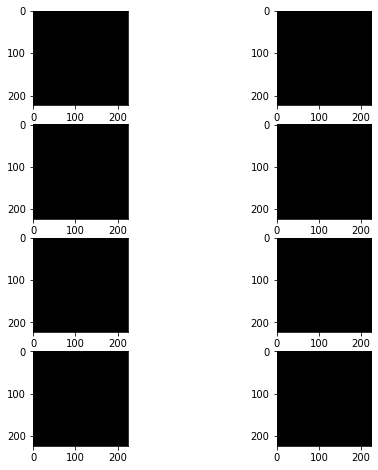

-----------------------------------------------------
Currently at epoch 162/200
Loss:  -0.00041476418846286833
-----------------------------------------------------
Currently at epoch 163/200
Loss:  -0.0003883838653564453
-----------------------------------------------------
Currently at epoch 164/200
Loss:  -0.000403041165554896
-----------------------------------------------------
Currently at epoch 165/200
Loss:  -0.0003712582401931286
-----------------------------------------------------
Currently at epoch 166/200
Loss:  -0.0004732873640023172
-----------------------------------------------------
Currently at epoch 167/200
Loss:  -0.0006464665057137609
-----------------------------------------------------
Currently at epoch 168/200
Loss:  -0.00046469029621221125
-----------------------------------------------------
Currently at epoch 169/200
Loss:  -0.0004534986219368875
-----------------------------------------------------
Currently at epoch 170/200
Loss:  -0.0004411102272570133


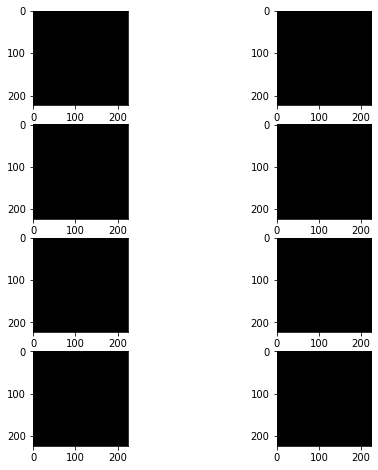

-----------------------------------------------------
Currently at epoch 172/200
Loss:  -0.0004053427546750754
-----------------------------------------------------
Currently at epoch 173/200
Loss:  -0.0002703994105104357
-----------------------------------------------------
Currently at epoch 174/200
Loss:  -0.0004967910936102271
-----------------------------------------------------
Currently at epoch 175/200
Loss:  -0.0003513744450174272
-----------------------------------------------------
Currently at epoch 176/200
Loss:  -0.00029975915094837546
-----------------------------------------------------
Currently at epoch 177/200
Loss:  -0.0005365734687075019
-----------------------------------------------------
Currently at epoch 178/200
Loss:  -0.00039995729457587004
-----------------------------------------------------
Currently at epoch 179/200
Loss:  -0.00013904165825806558
-----------------------------------------------------
Currently at epoch 180/200
Loss:  -0.000940279278438538

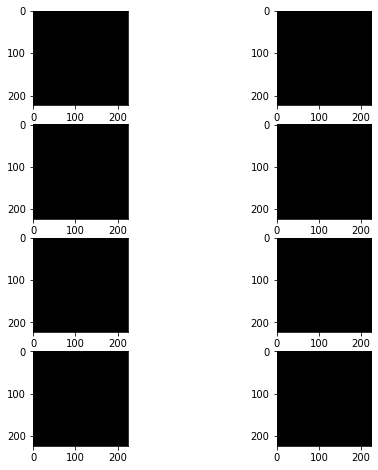

-----------------------------------------------------
Currently at epoch 182/200
Loss:  -0.0003187329275533557
-----------------------------------------------------
Currently at epoch 183/200
Loss:  -0.0005604114267043769
-----------------------------------------------------
Currently at epoch 184/200
Loss:  -0.00033441244158893824
-----------------------------------------------------
Currently at epoch 185/200
Loss:  -0.00035769332316704094
-----------------------------------------------------
Currently at epoch 186/200
Loss:  -0.0003386556636542082
-----------------------------------------------------
Currently at epoch 187/200
Loss:  -0.0005851789028383791
-----------------------------------------------------
Currently at epoch 188/200
Loss:  -0.0005003541009500623
-----------------------------------------------------
Currently at epoch 189/200
Loss:  -0.00041542801773175597
-----------------------------------------------------
Currently at epoch 190/200
Loss:  -0.000681493780575692

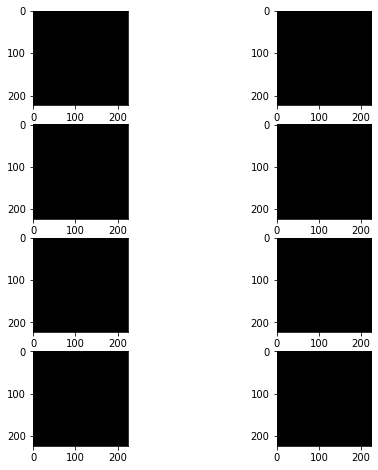

-----------------------------------------------------
Currently at epoch 192/200
Loss:  -0.00030263420194387436
-----------------------------------------------------
Currently at epoch 193/200
Loss:  nan
-----------------------------------------------------
Currently at epoch 194/200
Loss:  -0.0006227976409718394
-----------------------------------------------------
Currently at epoch 195/200
Loss:  -0.00038664325256831944
-----------------------------------------------------
Currently at epoch 196/200
Loss:  -0.0004746072518173605
-----------------------------------------------------
Currently at epoch 197/200
Loss:  -0.00033020038972608745
-----------------------------------------------------
Currently at epoch 198/200
Loss:  nan
-----------------------------------------------------
Currently at epoch 199/200
Loss:  nan
-----------------------------------------------------
Currently at epoch 200/200
Loss:  -0.0006124093197286129


-----------------------------------------------------

In [ ]:
train_source,test_target, trainl_M = switch_source_target("","","", 8, False) ### GETTING ALL NEEEDED LOADERS   source = Real Life, target = Product
train_target,test_target, trainl_M = switch_source_target("","","", 8, True)
autoencoder = Autoencoder(224,64)
autoencoder = autoencoder.to(device)
epochs = 200
main(train_source, train_target, test_target, epochs, autoencoder, "model_AE_Reall_s_new")

As the image displays, after only few epochs the reconstructed image is a full black box. These results are neither ideal nor satisfactory as it means that the model trained with a combination of losses cannot reconstruct the image.  This outcome induces to think the relative weak power of the reconstruction loss when compared to the ones used for the clustering algorithm. Additionally, the model doesn't seem to be learning from the combination of losses above, reaching a very low accuracy on the first epochs. 

An additional issue is that losses are negative. More specifically, the KL-Divergence loss, which is a measure of the difference between two probability distributions, which is in nature always non-negative. Since this value is negative there are issues in the probability distributions that are compared (namely P and Q). The activation outputs are all negative, as well as model weights, and probability distribution do not seem valid. 

Additionally, weights are very small and keep shrinking, leading to values very close to zero. 

Some computations like the square root of a value or its logarithm cannot be performed given the negativity of the values, which returns either nan, or an exploding value towards infinity. 
Therefore, the learning rate has been adjusted to keep decreasing when reaching a plateau. 
Still, the model is not satisfactory as it returns an invalid KL divergence, and overall invalid loss function. 

Given the previous non-satisfactory outcomes, few considerations may be made.
The choice of including the reconstruction loss was driven by the fact of willing to follow the regularisation idea of the authors of the DEPICT paper. The expectation was that by adding the loss, it would have enhanced the clustering-algorithm's performance. Nonetheless, in the original paper it was used to improve the performances of a clustering algorithm, whereas in this case, additional confusion is created by adding a further parameter. Hence, the networkis not able to recognise relevant features of images. Additionally, due to domain shift the network is neither able to reconstruct, nor to classify the images. Thus, it performs poorly also when compared to the baseline. 

Hence, the following comments:
* Adding  a regularisation parameter without it's respective weight (lambda) misleads the network learning process as it tends to assign more power to reconstructing the image than required. The network performs poorly on all tasks as it lacks of guidance. 
* The idea of using and autoencoder working on two different domains is not ideal as it cannot deal with the differences among the two. 




###KMeans - DEPICT (Based)

In [ ]:
class Encoder_N2(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int
                 ):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.layer1 = nn.Sequential(
                        nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),
                        nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
                        nn.ReLU())
        self.layer3 = nn.Sequential(nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
                        nn.ReLU())
        self.layer4 = nn.Sequential(nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
                        nn.ReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), 
                      nn.ReLU()) #QUI SIAMO CON IL NOSTRO ENCODER DI INTERESSE,

        self.latent_repr = nn.Sequential(nn.Flatten(), # Image grid to single feature vector
                           nn.Linear(351232, latent_dim)) #DEPICT
        self.linear2 = nn.Linear(latent_dim, 20*8) # For further predictions to be passed to the softmax 

        self.linear3 = nn.Linear(latent_dim, 20) # KMeans  

        #self.layernorm = torch.nn.LayerNorm(20*8)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

      layer1 = self.layer1(x)
      layer2 = self.layer2(layer1)
      layer3 = self.layer3(layer2)
      layer4 = self.layer4(layer3)
      enc = self.layer5(layer4)

    
      latent_emb_batch = torch.exp(self.latent_repr(enc)) #With the first linear embedding - enforcing positive values
      layer_to_softmax = self.linear2(latent_emb_batch) #to pass to the softmax 
      latent_emb_class = self.latent_repr(enc) #for the kmeans 
      latent_emb_class = self.linear3(latent_emb_class) #Compressing information into an unique vector to approach the kmeans 
      expectation_maximization = self.softmax(layer_to_softmax) 
     

      return  enc, latent_emb_batch, latent_emb_class, expectation_maximization 

In [ ]:
class Decoder_N2(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = 224

        self.layer5 = nn.Sequential(
                      nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
                      nn.ReLU())
       
        self.layer4 = nn.Sequential(
                      nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
                      nn.ReLU())
        self.layer3 = nn.Sequential(
                      nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), 
                      nn.ReLU())
        self.layer2 = nn.Sequential(
                      nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
                      nn.ReLU())
        self.layer1 = nn.Sequential(
                      nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
                      nn.ReLU())
        self.decode = nn.Sequential(
                      nn.ConvTranspose2d(c_hid, 3, kernel_size=3, output_padding=1, padding=1, stride=2), 
                      nn.Sigmoid() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
                            )
    

    def forward(self, x):
        layer5 = self.layer5(x)
        layer4 = self.layer4(layer5)
        layer3 = self.layer3(layer4)
        layer2 = self.layer2(layer3)
        layer1 = self.layer1(layer2)
        decoded = self.decode(layer1)

        return  decoded

In [ ]:
class Autoencoder_N2(nn.Module):

  def __init__(self, 
              base_channel_size: int,
              latent_dim: int,
              encoder_class : object = Encoder_N2, 
              decoder_class : object = Decoder_N2,
              num_input_channels: int = 3):
        super().__init__()
        # Saving hyperparameters of autoencoder
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)

  def forward(self, x):

     enc,latent_embeddings,latent_embeddings_kmeans, softmax = self.encoder(x)
     x_reconstructed = self.decoder(enc)
     return  latent_embeddings,latent_embeddings_kmeans,softmax, x_reconstructed 
   


In [ ]:
def Optimizer(model) : 
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-7) #SMALL GRADIENT TO AVOID GRADIENT EXPLOSION (we get NAN and INF)
  optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                            mode='min',
                                            factor=0.2,
                                            patience=10,
                                             min_lr=1e-20)
  return optimizer

def KLD(logvar, mu):
   return  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) 

In [ ]:
def DEPICT(X_rec, X_original, em, softmax,is_target:bool, ys=None) :
  """Instantiation of the depict algorithm. 
     Since two models are trained, the loss of the target model is partially considered in the source one. 
     Namely:

     @ TARGET AUTOENCODER LOSS: 
                      - reconstruction loss: (reconstructed image - orginal image) + layer reconstruction (batch monitoring). 
                      - clustering loss with a beta of 0.8 (according to paper)
     @ SOURCE AUTOENCODER LOSS: 
                      - loss from target model: kl_T between auxiliary distribution and em_T and cluster loss (beta 0.4, sigma 0.03). Penalized by 0.2
                      - crossEntropy loss: takes advantage of source supervision 
                      - reconstruction loss: (reconstructed image - orginal image) + layer reconstruction (batch monitoring). 

     The goal is to render source autoencoder's training hard to learn a more generalised feature space representation. It is relevant to note that the final goal is not
     to minimise the reconstruction loss, but to minimise the clustering one. """

  n_clus = 20
  CEloss = nn.CrossEntropyLoss()


  rec_loss = F.mse_loss(X_rec, X_original)
  r_sumoveri = torch.sqrt(torch.sum(softmax,dim=0))
  num_T = softmax/r_sumoveri 
  q = num_T/(torch.sum(num_T,dim=0))
  
  clus_loss = -1*torch.mean(q*torch.log(softmax))/n_clus
  
  kl_hat_loss =  KLD(softmax, q)
  
  if (is_target == True) : 

    # LOSS TO TRAIN TARGET AUTOENCODER
    loss_T = rec_loss +clus_loss*0.03 + 0.01*kl_hat_loss #fophi loss and reconstruction loss but with low lambda -> reconstruction is more relevant 
    
    # LOSS HERE TO PENALIZE THE AUTOENCODER FOR THE SOURCE
    loss_S_from_T = clus_loss*0.4 #reconstruction loss for target is more relevant

    return loss_T, loss_S_from_T

  if (is_target == False) : 
    cross_entropy = CEloss(softmax, ys)
    loss_S =  0.8*rec_loss + 0.5*kl_hat_loss + cross_entropy*0.8 +clus_loss*0.8
    return loss_S



In [ ]:
def train(model_T, model_S, optimizer_T, optimizer_S, train_target, train_source, name,n_clus = 20,
          print_every=100, verbose=False):
    '''Training step of the algorithm'''


    model_T.train()
    model_S.train()

    # Iterating over the two domains
    for i, (dataT, dataS) in enumerate(zip(cycle(train_target), train_source)):
        
        loss_print_T = 0 
        loss_print_S = 0 
        # Target Data - Source Data
        Xt_var, _ = dataT
        Xs_var, ys_var =  dataS 
        Xt_var = Xt_var.to(device)
        Xs_var =  Xs_var.to(device)
        ys_var = ys_var.to(device)
        ############ FORWARD PASS FOR TARGET MODEL AND SOURCE MODEL ############
        optimizer_T.zero_grad()
        optimizer_S.zero_grad()

       
        embeddings_T, kmeans_emb_T, softmax_t,  x_reconstructed_T  = model_T(Xt_var) #FULL AUTOENCODER TARGET   
        embeddings_S, kmeans_emb_S, softmax_s,  x_reconstructed_S  = model_S(Xs_var) #FULL AUTOENCODER SOURCE 
       
       
        ############ TARGET ############
        loss_T, loss_S_from_T = DEPICT(x_reconstructed_T, 
                                       Xt_var,  
                                       embeddings_T, softmax_t, True, None) 
        
        ############ SOURCE ############
        loss_S = DEPICT(x_reconstructed_S, 
                        Xs_var,
                        embeddings_S, softmax_s, False, ys_var)
 
        loss_S += 0.2*loss_S_from_T.detach_() 
        

        loss_T.backward()
        loss_S.backward()
        optimizer_T.step()
        optimizer_S.step()

       
        loss_print_T += loss_T
        loss_print_S += loss_S
        
        
       
        loss_print_T = loss_print_T/len(train_target)  
        loss_print_S = loss_print_T/len(train_target)  

    save_checkpoint(model_T, model_T.state_dict(), optimizer_T.state_dict(), loss_T, f"drive/MyDrive/DL_Project/checkpoint_Model_{name}_T")    
    save_checkpoint(model_S, model_S.state_dict(), optimizer_S.state_dict(), loss_S, f"drive/MyDrive/DL_Project/checkpoint_Model_{name}_S")        
    save_checkpoint(model_T.encoder, model_T.encoder.state_dict(), optimizer_T.state_dict(), loss_T, f"drive/MyDrive/DL_Project/checkpoint_encoder_{name}_T") 
    save_checkpoint(model_T.decoder, model_T.decoder.state_dict(), optimizer_T.state_dict(), loss_T, f"drive/MyDrive/DL_Project/checkpoint_decoder_{name}_T")  
    save_checkpoint(model_S.encoder, model_S.encoder.state_dict(), optimizer_S.state_dict(), loss_S, f"drive/MyDrive/DL_Project/checkpoint_encoder_{name}_S") 
    save_checkpoint(model_S.decoder, model_S.decoder.state_dict(), optimizer_S.state_dict(), loss_S, f"drive/MyDrive/DL_Project/checkpoint_decoder_{name}_S") 

      
   
    return loss_S, loss_T, x_reconstructed_S, x_reconstructed_T

In [ ]:
def testing(net, testing_loader, cost_function, device, phase) : 
  """Testing step"""
  val_acc = [] 
  val_err = []
  test_err = []
  test_acc = []


  samp_s = []
  samp_v = []
  
  total = 0.0
  samples = 0.0
  running_loss = 0.0
  running_accuracy = 0.0
  samp = []
  #Evaluation mode and not Training
  net.eval() 
  loss_print = 0.0
  #No gradient computation bc we're not testing -> gradient must not be modified anymore (we're not updating weights and learning) 
  with torch.no_grad():

    # iterate over the test set
    for batch_idx, (img,lab) in enumerate(testing_loader):
      
     # load data into GPU
      img= img.to(device)
      lab = lab.to(device)
        
      # forward pass
      _, _, _, outputs  = net(img)
      loss = cost_function(outputs, lab)
      acc = accuracy(outputs, lab)

      running_accuracy += torch.round(acc * 100)
      loss_print += loss 

    loss_print/len(testing_loader)
    print('Test loss', loss_print.item())
    print('Accuracy', running_accuracy.item()/len(testing_loader))


      

In [ ]:
def main(trainS,
         trainT,
         test,
         epochs,
         autoencoder_T,
         autoencoder_S,
         name,
         checkpoint: bool,
         optim1 = None,
         optim2 = None,
         device='cuda:0', 
         visualization_name='centered'):

  model_T = autoencoder_T
  model_S = autoencoder_S
  model_T = model_T.to(device)
  model_S = model_S.to(device)

  optimizer_T = Optimizer(model_T)
  optimizer_S = Optimizer(model_S)

  LT = [] 
  LS = []
  for e in range(epochs) : 
    print('_______________________________________________________________')
    print('Epoch {}/{}'.format(e+1,epochs))
    loss_S, loss_T, XS_rec, XT_rec = train(model_T,model_S, optimizer_T, optimizer_S, train_target, train_source, name) 
    
    print(f'LOSS SOURCE: {loss_S},\n LOSS TARGET: {loss_T}')
    #### PLOTTING LOSSES ####
    LT.append((e,loss_T.detach()))
    LS.append((e,loss_S.detach()))
    if (( e % 10 )== 0) : 
      print("Source reconstructed images:")
      plot_results(XS_rec)
      print("Target reconstructed images:")
      plot_results(XT_rec)

  #### TESTING IS MISSING ####
  save_model_to_path(model_S, f"drive/MyDrive/DL_Project/model_AE_{name}Depict")
  testing(model_S.encoder, test, nn.CrossEntropyLoss(),device,'Test')
  return LT, LS, XS_rec, XT_rec

In [ ]:
autoencoder_T = Autoencoder_N2(224,64)
autoencoder_S = Autoencoder_N2(224,64)

Given the previous observations, the autoencoder is now trained with some penalties for both target and source losses. Given the lack of such information in the paper and reference code, some valuyes where tried out to understand whether inserting penalties and disregarding the relevance of image reconstruction could be of any use. Results below display the training and testing for both a pre-trained autoencoder and not-pretrained. 

A small correction has been applied to the first latent layer, namely, assumption has been made that the linear layer returns **log-outputs**. Therefore, the exponential of such values is retuned. The very firt tentatives were applied on a dataset normalized with Imagenet's mean and standard deviation, whereas the dataset transformation has been corrected and normalized with the proper mean and standard deviation (howver, not for the whole Adaptiobe dataset). The main issue causing this small tweak whas that linear output values ranged between -1 and 1, and the DEPICT algorithm required to apply the square root and logarithm of the softmax values. Thus, linear values needed to be forced on a range [0, 1] without loosing informativeness. The first idea was to scale values to fit in said range. However, this caused trailing nan values during backpropagation. 

A second solution could have been adopting the absolute value of such output, which is a linear function and has the advantage of not changing the magnitude of the value. Nonetheless, we noticed gradient discontinuities (values changing drastically within the same batch). 

Thus, following the base idea of Variational Autoencoders, and more specifically algorithms in which some form of clustering is enforced in the Z space, the choice has landed on assuming that the output would be **logarithmic**.  
Such assumption might be very strong, as the exponential function leads to a very rapid increase for values < 0. But it is paired with a softmax function, which seems to stabilise the learning process.

In [ ]:
train_source,test_target, trainl_M = switch_source_target("","","", 8, True) ### GETTING ALL NEEEDED LOADERS   source = Real Life, target = Product
train_target,test_source, trainl_M = switch_source_target("","","", 8, False) ### GETTING ALL NEEEDED LOADERS   source = Product, target = Real Life

Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.
Compiling transformations....
________________________________
Done! Returning compiler.


_______________________________________________________________
Epoch 1/200
LOSS SOURCE: 56.374332427978516,
 LOSS TARGET: 2.551426649093628
Source reconstructed images:


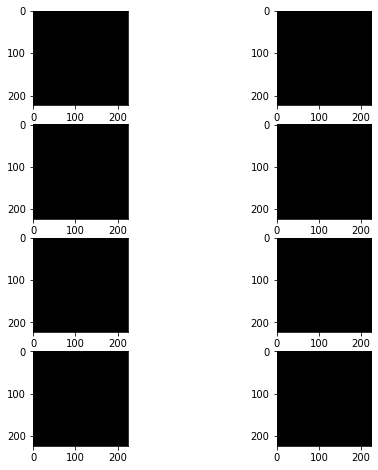

Target reconstructed images:


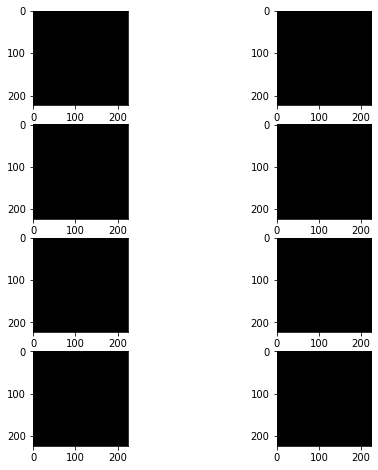

_______________________________________________________________
Epoch 2/200
LOSS SOURCE: 16.04316520690918,
 LOSS TARGET: 1.3968837261199951
_______________________________________________________________
Epoch 3/200
LOSS SOURCE: 8.086538314819336,
 LOSS TARGET: 1.558318018913269
_______________________________________________________________
Epoch 4/200
LOSS SOURCE: 7.443273544311523,
 LOSS TARGET: 1.7242859601974487
_______________________________________________________________
Epoch 5/200
LOSS SOURCE: 7.039818286895752,
 LOSS TARGET: 1.3441749811172485
_______________________________________________________________
Epoch 6/200
LOSS SOURCE: 6.695366382598877,
 LOSS TARGET: 1.4995793104171753
_______________________________________________________________
Epoch 7/200
LOSS SOURCE: 6.100153923034668,
 LOSS TARGET: 1.4368773698806763
_______________________________________________________________
Epoch 8/200
LOSS SOURCE: 5.837123394012451,
 LOSS TARGET: 1.4563238620758057
______________

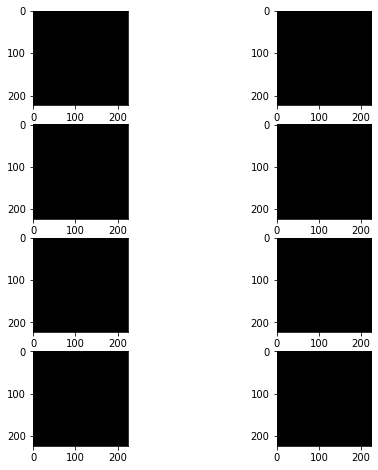

Target reconstructed images:


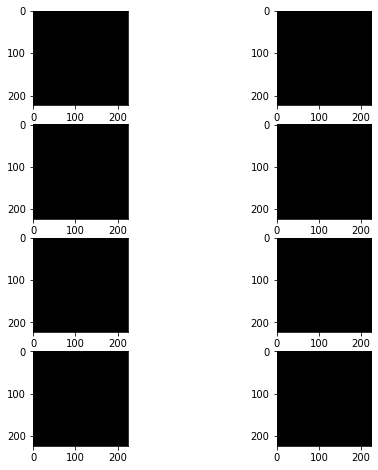

_______________________________________________________________
Epoch 12/200
LOSS SOURCE: 5.6571784019470215,
 LOSS TARGET: 1.0684552192687988
_______________________________________________________________
Epoch 13/200
LOSS SOURCE: 5.7880425453186035,
 LOSS TARGET: 1.0648667812347412
_______________________________________________________________
Epoch 14/200
LOSS SOURCE: 5.5726094245910645,
 LOSS TARGET: 1.162367343902588
_______________________________________________________________
Epoch 15/200
LOSS SOURCE: 5.550780773162842,
 LOSS TARGET: 1.116196632385254
_______________________________________________________________
Epoch 16/200
LOSS SOURCE: 6.073360919952393,
 LOSS TARGET: 1.1844770908355713
_______________________________________________________________
Epoch 17/200
LOSS SOURCE: 5.381935119628906,
 LOSS TARGET: 0.8394041061401367
_______________________________________________________________
Epoch 18/200
LOSS SOURCE: 5.37026309967041,
 LOSS TARGET: 1.001609206199646
_______

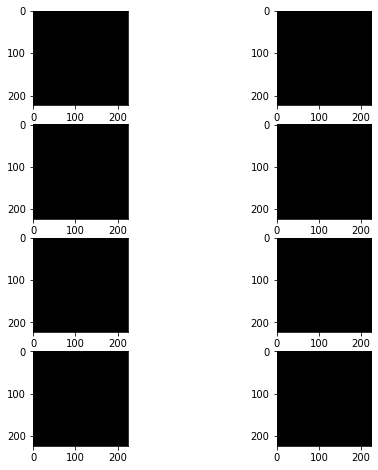

Target reconstructed images:


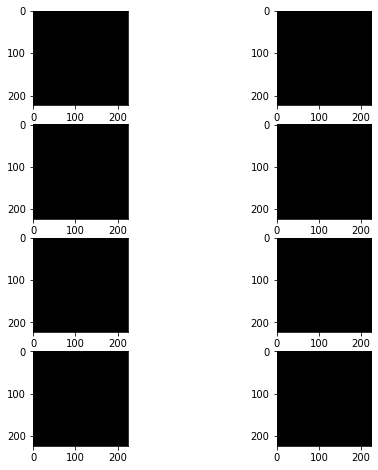

_______________________________________________________________
Epoch 22/200
LOSS SOURCE: 5.930330753326416,
 LOSS TARGET: 0.810143232345581
_______________________________________________________________
Epoch 23/200
LOSS SOURCE: 5.579957008361816,
 LOSS TARGET: 0.9194453954696655
_______________________________________________________________
Epoch 24/200
LOSS SOURCE: 5.667332172393799,
 LOSS TARGET: 0.9422210454940796
_______________________________________________________________
Epoch 25/200
LOSS SOURCE: 5.878616809844971,
 LOSS TARGET: 0.9810600280761719
_______________________________________________________________
Epoch 26/200
LOSS SOURCE: 6.108379364013672,
 LOSS TARGET: 1.135104775428772
_______________________________________________________________
Epoch 27/200
LOSS SOURCE: 5.561051368713379,
 LOSS TARGET: 0.720464825630188
_______________________________________________________________
Epoch 28/200
LOSS SOURCE: 5.608145236968994,
 LOSS TARGET: 1.149549126625061
__________

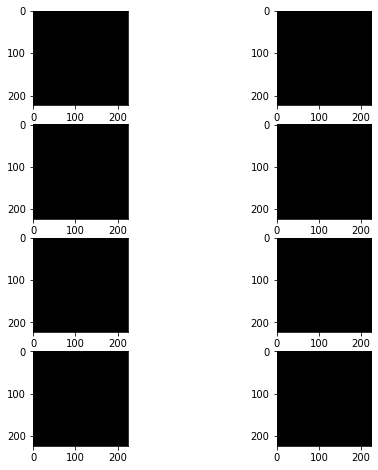

Target reconstructed images:


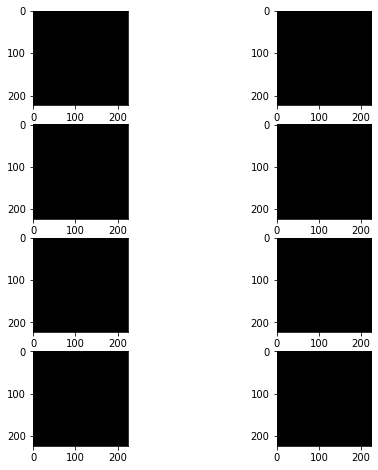

_______________________________________________________________
Epoch 32/200
LOSS SOURCE: 5.664738655090332,
 LOSS TARGET: 0.9642965793609619
_______________________________________________________________
Epoch 33/200
LOSS SOURCE: 5.55419397354126,
 LOSS TARGET: 0.8307077884674072
_______________________________________________________________
Epoch 34/200
LOSS SOURCE: 5.442907810211182,
 LOSS TARGET: 0.9890471696853638
_______________________________________________________________
Epoch 35/200
LOSS SOURCE: 5.3687896728515625,
 LOSS TARGET: 1.1317758560180664
_______________________________________________________________
Epoch 36/200
LOSS SOURCE: 5.714831352233887,
 LOSS TARGET: 1.096625804901123
_______________________________________________________________
Epoch 37/200
LOSS SOURCE: 5.636568069458008,
 LOSS TARGET: 0.9856565594673157
_______________________________________________________________
Epoch 38/200
LOSS SOURCE: 5.672214508056641,
 LOSS TARGET: 0.9792325496673584
_______

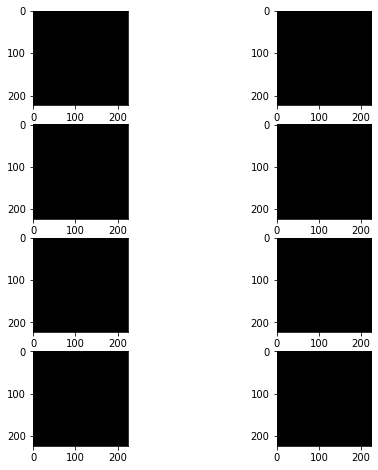

Target reconstructed images:


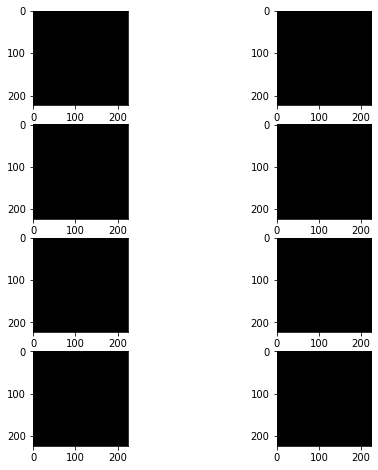

_______________________________________________________________
Epoch 42/200
LOSS SOURCE: 5.530611515045166,
 LOSS TARGET: 0.8170092105865479
_______________________________________________________________
Epoch 43/200
LOSS SOURCE: 5.447038173675537,
 LOSS TARGET: 0.8196864724159241
_______________________________________________________________
Epoch 44/200
LOSS SOURCE: 5.753889083862305,
 LOSS TARGET: 0.9553651809692383
_______________________________________________________________
Epoch 45/200
LOSS SOURCE: 5.244904041290283,
 LOSS TARGET: 0.9281426668167114
_______________________________________________________________
Epoch 46/200
LOSS SOURCE: 5.511911869049072,
 LOSS TARGET: 0.680301308631897
_______________________________________________________________
Epoch 47/200
LOSS SOURCE: 5.165215492248535,
 LOSS TARGET: 0.7026169896125793
_______________________________________________________________
Epoch 48/200
LOSS SOURCE: 5.500186920166016,
 LOSS TARGET: 0.7961594462394714
_______

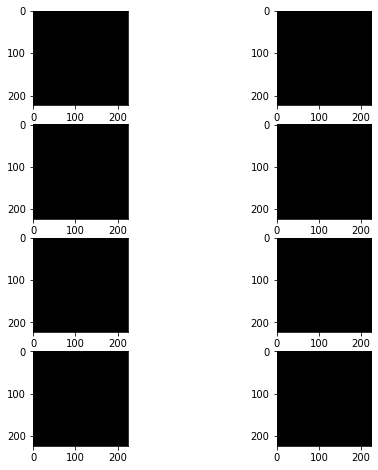

Target reconstructed images:


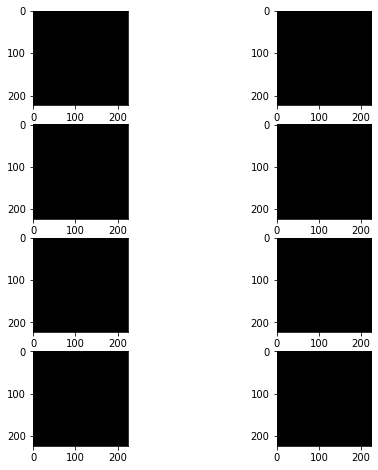

_______________________________________________________________
Epoch 52/200
LOSS SOURCE: 5.217289924621582,
 LOSS TARGET: 0.6656111478805542
_______________________________________________________________
Epoch 53/200
LOSS SOURCE: 5.503715991973877,
 LOSS TARGET: 0.7883796095848083
_______________________________________________________________
Epoch 54/200
LOSS SOURCE: 5.7981791496276855,
 LOSS TARGET: 0.7741092443466187
_______________________________________________________________
Epoch 55/200
LOSS SOURCE: 6.109838485717773,
 LOSS TARGET: 0.8665011525154114
_______________________________________________________________
Epoch 56/200
LOSS SOURCE: 5.345912933349609,
 LOSS TARGET: 0.7658387422561646
_______________________________________________________________
Epoch 57/200
LOSS SOURCE: 5.065587997436523,
 LOSS TARGET: 0.8634025454521179
_______________________________________________________________
Epoch 58/200
LOSS SOURCE: 5.496026515960693,
 LOSS TARGET: 0.5855941772460938
_____

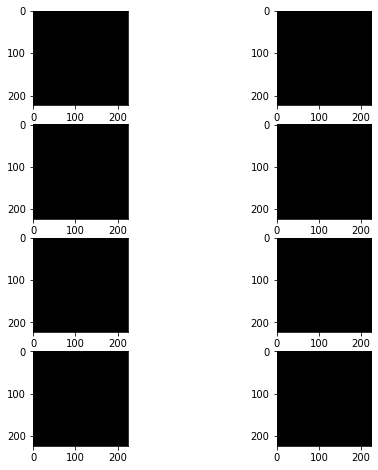

Target reconstructed images:


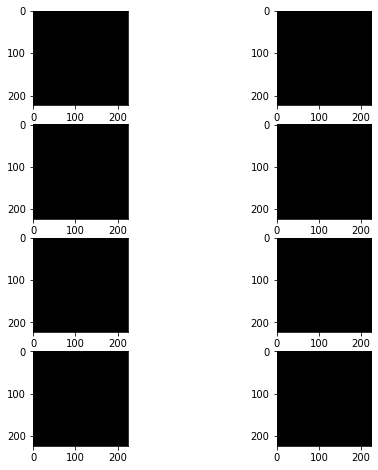

_______________________________________________________________
Epoch 62/200
LOSS SOURCE: 5.490255355834961,
 LOSS TARGET: 0.8645868897438049
_______________________________________________________________
Epoch 63/200
LOSS SOURCE: 5.469318866729736,
 LOSS TARGET: 1.0405654907226562
_______________________________________________________________
Epoch 64/200
LOSS SOURCE: 5.180367946624756,
 LOSS TARGET: 0.9029324650764465
_______________________________________________________________
Epoch 65/200
LOSS SOURCE: 4.92643928527832,
 LOSS TARGET: 0.7839356660842896
_______________________________________________________________
Epoch 66/200
LOSS SOURCE: 5.189391136169434,
 LOSS TARGET: 0.9073278903961182
_______________________________________________________________
Epoch 67/200
LOSS SOURCE: 4.952148914337158,
 LOSS TARGET: 0.8062085509300232
_______________________________________________________________
Epoch 68/200
LOSS SOURCE: 5.441865921020508,
 LOSS TARGET: 0.8854015469551086
_______

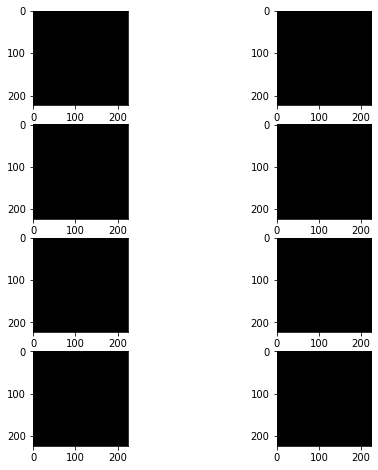

Target reconstructed images:


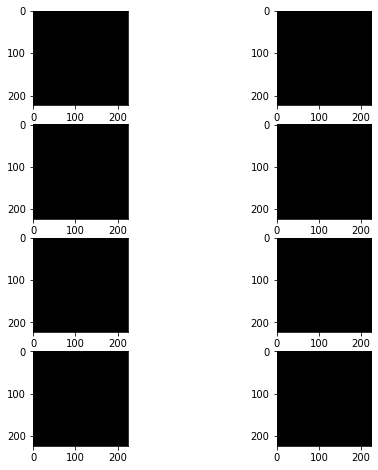

_______________________________________________________________
Epoch 72/200
LOSS SOURCE: 5.571784496307373,
 LOSS TARGET: 0.8814898729324341
_______________________________________________________________
Epoch 73/200
LOSS SOURCE: 5.828615188598633,
 LOSS TARGET: 0.7557470798492432
_______________________________________________________________
Epoch 74/200
LOSS SOURCE: 5.549437522888184,
 LOSS TARGET: 0.6190924644470215
_______________________________________________________________
Epoch 75/200
LOSS SOURCE: 5.7760114669799805,
 LOSS TARGET: 0.8306721448898315
_______________________________________________________________
Epoch 76/200
LOSS SOURCE: 5.1788434982299805,
 LOSS TARGET: 0.7563325762748718
_______________________________________________________________
Epoch 77/200
LOSS SOURCE: 6.050570011138916,
 LOSS TARGET: 0.8011082410812378
_______________________________________________________________
Epoch 78/200
LOSS SOURCE: 5.134779453277588,
 LOSS TARGET: 0.8306552767753601
____

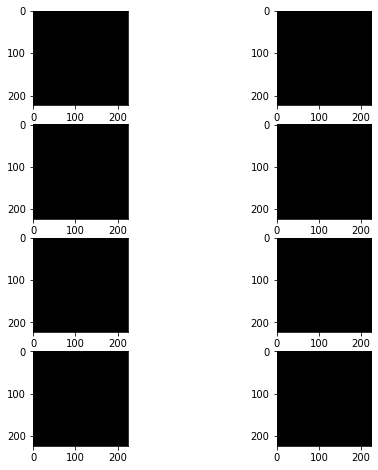

Target reconstructed images:


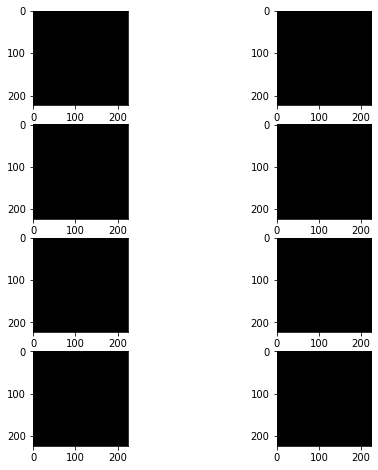

_______________________________________________________________
Epoch 82/200
LOSS SOURCE: 5.7412919998168945,
 LOSS TARGET: 0.6320545673370361
_______________________________________________________________
Epoch 83/200
LOSS SOURCE: 5.14857292175293,
 LOSS TARGET: 0.7148219347000122
_______________________________________________________________
Epoch 84/200
LOSS SOURCE: 5.772083759307861,
 LOSS TARGET: 0.9044781923294067
_______________________________________________________________
Epoch 85/200
LOSS SOURCE: 5.379880905151367,
 LOSS TARGET: 0.7017295956611633
_______________________________________________________________
Epoch 86/200
LOSS SOURCE: 5.1772990226745605,
 LOSS TARGET: 0.7105061411857605
_______________________________________________________________
Epoch 87/200
LOSS SOURCE: 5.392569065093994,
 LOSS TARGET: 0.7456094622612
_______________________________________________________________
Epoch 88/200
LOSS SOURCE: 5.306447505950928,
 LOSS TARGET: 0.718199610710144
_________

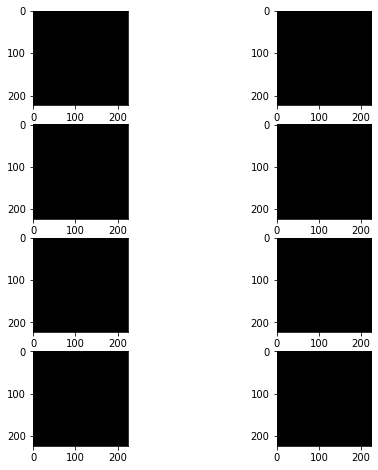

Target reconstructed images:


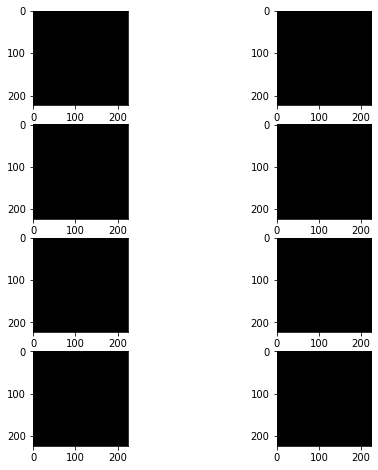

_______________________________________________________________
Epoch 92/200
LOSS SOURCE: 5.166245460510254,
 LOSS TARGET: 0.8214705586433411
_______________________________________________________________
Epoch 93/200
LOSS SOURCE: 5.404688358306885,
 LOSS TARGET: 0.6381770968437195
_______________________________________________________________
Epoch 94/200
LOSS SOURCE: 5.484216213226318,
 LOSS TARGET: 0.7207106947898865
_______________________________________________________________
Epoch 95/200
LOSS SOURCE: 5.587516784667969,
 LOSS TARGET: 0.9988794326782227
_______________________________________________________________
Epoch 96/200
LOSS SOURCE: 5.459740161895752,
 LOSS TARGET: 0.6242971420288086
_______________________________________________________________
Epoch 97/200
LOSS SOURCE: 5.650606155395508,
 LOSS TARGET: 0.9596184492111206
_______________________________________________________________
Epoch 98/200
LOSS SOURCE: 5.4157562255859375,
 LOSS TARGET: 0.9579384326934814
_____

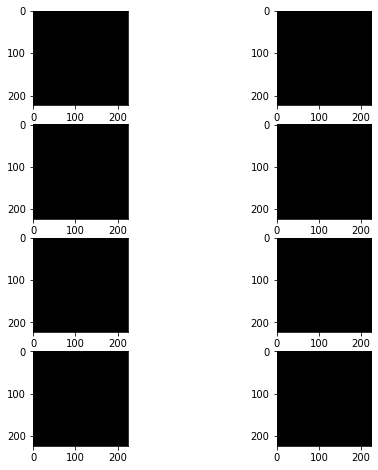

Target reconstructed images:


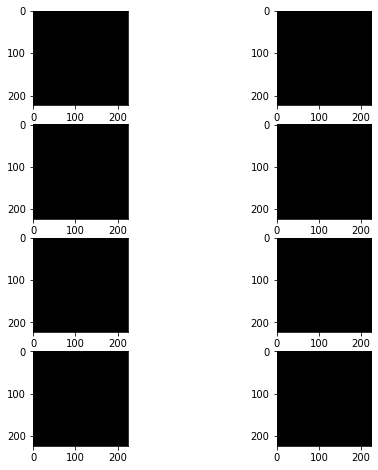

_______________________________________________________________
Epoch 102/200
LOSS SOURCE: 5.622816562652588,
 LOSS TARGET: 0.6595529913902283
_______________________________________________________________
Epoch 103/200
LOSS SOURCE: 5.52056884765625,
 LOSS TARGET: 0.8166471123695374
_______________________________________________________________
Epoch 104/200
LOSS SOURCE: 5.21492862701416,
 LOSS TARGET: 0.8110636472702026
_______________________________________________________________
Epoch 105/200
LOSS SOURCE: 5.656599998474121,
 LOSS TARGET: 0.8139327168464661
_______________________________________________________________
Epoch 106/200
LOSS SOURCE: 5.285082817077637,
 LOSS TARGET: 0.750773549079895
_______________________________________________________________
Epoch 107/200
LOSS SOURCE: 5.517013072967529,
 LOSS TARGET: 0.7309193015098572
_______________________________________________________________
Epoch 108/200
LOSS SOURCE: 5.3269124031066895,
 LOSS TARGET: 0.7778403759002686
_

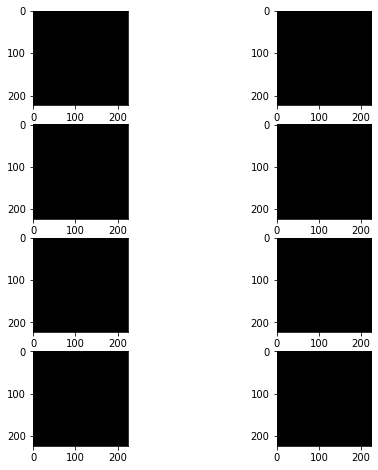

Target reconstructed images:


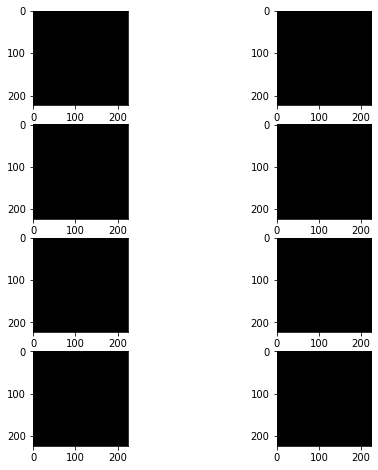

_______________________________________________________________
Epoch 112/200
LOSS SOURCE: 5.19569730758667,
 LOSS TARGET: 0.621062695980072
_______________________________________________________________
Epoch 113/200
LOSS SOURCE: 5.376688480377197,
 LOSS TARGET: 0.7857388854026794
_______________________________________________________________
Epoch 114/200
LOSS SOURCE: 5.143443584442139,
 LOSS TARGET: 0.630823016166687
_______________________________________________________________
Epoch 115/200
LOSS SOURCE: 5.379906177520752,
 LOSS TARGET: 0.9469773769378662
_______________________________________________________________
Epoch 116/200
LOSS SOURCE: 5.0060272216796875,
 LOSS TARGET: 0.6379785537719727
_______________________________________________________________
Epoch 117/200
LOSS SOURCE: 5.630004405975342,
 LOSS TARGET: 0.7184697389602661
_______________________________________________________________
Epoch 118/200
LOSS SOURCE: 5.799935817718506,
 LOSS TARGET: 0.7370343208312988
_

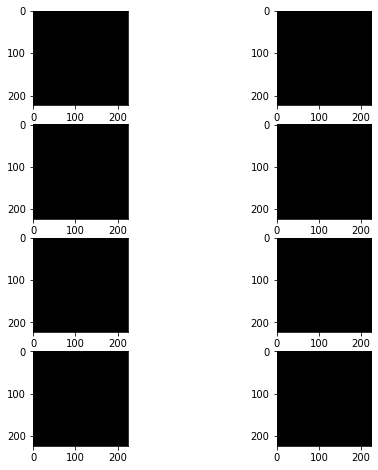

Target reconstructed images:


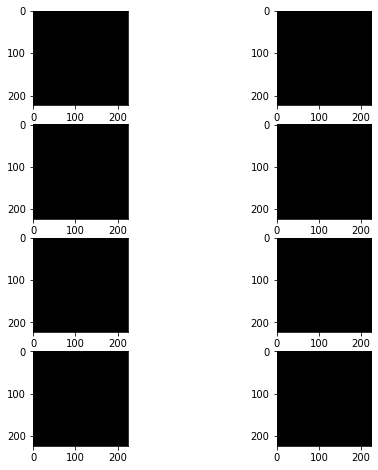

_______________________________________________________________
Epoch 122/200
LOSS SOURCE: 5.546353340148926,
 LOSS TARGET: 0.761642336845398
_______________________________________________________________
Epoch 123/200
LOSS SOURCE: 5.538610935211182,
 LOSS TARGET: 0.7301926612854004
_______________________________________________________________
Epoch 124/200
LOSS SOURCE: 5.326286792755127,
 LOSS TARGET: 0.8110067844390869
_______________________________________________________________
Epoch 125/200
LOSS SOURCE: 5.196952819824219,
 LOSS TARGET: 0.8474094271659851
_______________________________________________________________
Epoch 126/200
LOSS SOURCE: 5.151068210601807,
 LOSS TARGET: 0.7813862562179565
_______________________________________________________________
Epoch 127/200
LOSS SOURCE: 5.328743934631348,
 LOSS TARGET: 0.8643590807914734
_______________________________________________________________
Epoch 128/200
LOSS SOURCE: 5.058299541473389,
 LOSS TARGET: 0.6978113651275635


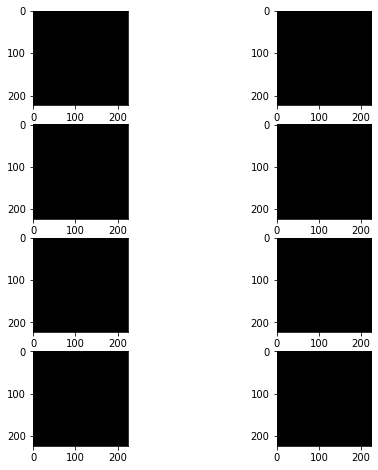

Target reconstructed images:


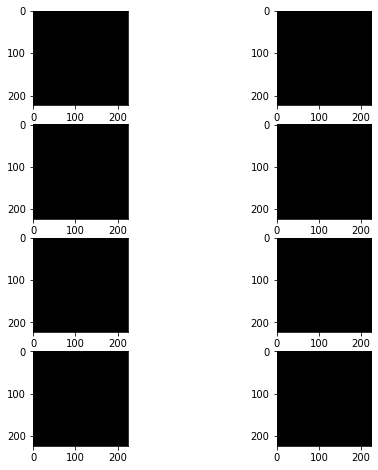

_______________________________________________________________
Epoch 132/200
LOSS SOURCE: 5.266776084899902,
 LOSS TARGET: 0.7030587196350098
_______________________________________________________________
Epoch 133/200
LOSS SOURCE: 5.371518135070801,
 LOSS TARGET: 0.825934648513794
_______________________________________________________________
Epoch 134/200
LOSS SOURCE: 5.286807060241699,
 LOSS TARGET: 0.721788227558136
_______________________________________________________________
Epoch 135/200
LOSS SOURCE: 5.298408508300781,
 LOSS TARGET: 0.5604453086853027
_______________________________________________________________
Epoch 136/200
LOSS SOURCE: 5.385274887084961,
 LOSS TARGET: 0.8012574911117554
_______________________________________________________________
Epoch 137/200
LOSS SOURCE: 5.936500549316406,
 LOSS TARGET: 0.8545422554016113
_______________________________________________________________
Epoch 138/200
LOSS SOURCE: 5.122801780700684,
 LOSS TARGET: 0.9016045928001404
_

In [ ]:
##  NON PRETRAINED 
LT , LS, xS_recon, xT_recon = main(train_target, train_source, test_target, 200, autoencoder_T, autoencoder_S, "Depict_Reall_Source_Prod_Target", False)

### PLOT LOSS TARGET ###
x_val_T = [x[0] for x in LT] #Epochs
y_val_T = [x[1] for x in LT] #Loss value
x_val_S = [x[0] for x in LS] #Epochs
y_val_S = [x[1] for x in LS] #Loss value
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'or')
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'og')
plt.show()

In [ ]:
optimizer = Optimizer(autoencoder_T)
autoencoder_T, optimizer_T, epoch = resume_checkpoint(autoencoder_T,139, optimizer, "drive/MyDrive/DL_Project/checkpoint_Model_Depict_Reall_Source_Prod_Target_T", True) 
autoencoder_S, optimizer_S, epoch = resume_checkpoint(autoencoder_S,139, optimizer, "drive/MyDrive/DL_Project/checkpoint_Model_Depict_Reall_Source_Prod_Target_S", True) 

dict_keys(['epoch', 'model_state_dict', 'loss', 'optimizer_state_dict'])
dict_keys(['epoch', 'model_state_dict', 'loss', 'optimizer_state_dict'])


_______________________________________________________________
Epoch 1/60
LOSS SOURCE: 5.581651210784912,
 LOSS TARGET: 0.9516313672065735
Source reconstructed images:


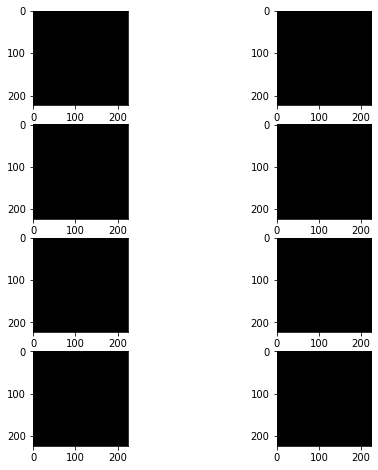

Target reconstructed images:


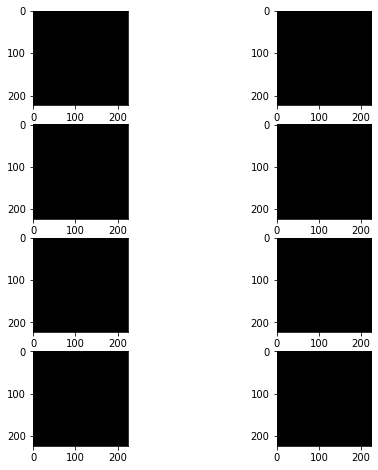

_______________________________________________________________
Epoch 2/60
LOSS SOURCE: 5.51903772354126,
 LOSS TARGET: 0.7191510200500488
_______________________________________________________________
Epoch 3/60
LOSS SOURCE: 5.4873151779174805,
 LOSS TARGET: 1.084875226020813
_______________________________________________________________
Epoch 4/60
LOSS SOURCE: 5.587209701538086,
 LOSS TARGET: 0.9184285402297974
_______________________________________________________________
Epoch 5/60
LOSS SOURCE: 5.460741996765137,
 LOSS TARGET: 0.8576053977012634
_______________________________________________________________
Epoch 6/60
LOSS SOURCE: 5.464235305786133,
 LOSS TARGET: 0.6534512639045715
_______________________________________________________________
Epoch 7/60
LOSS SOURCE: 5.440066337585449,
 LOSS TARGET: 1.0024458169937134
_______________________________________________________________
Epoch 8/60
LOSS SOURCE: 5.592621326446533,
 LOSS TARGET: 0.9139671921730042
_____________________

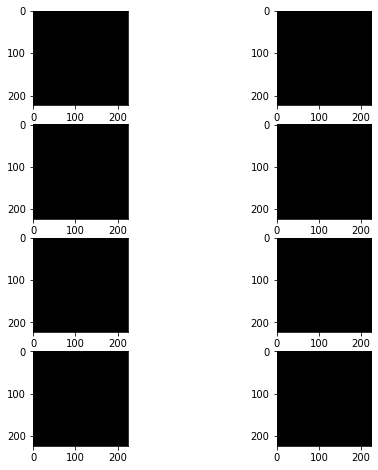

Target reconstructed images:


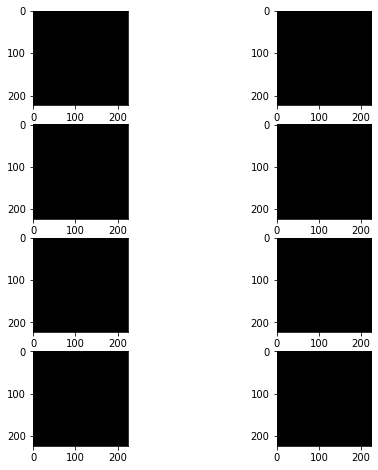

_______________________________________________________________
Epoch 12/60
LOSS SOURCE: 5.681250095367432,
 LOSS TARGET: 0.7850310802459717
_______________________________________________________________
Epoch 13/60
LOSS SOURCE: 5.268335819244385,
 LOSS TARGET: 0.7964196801185608
_______________________________________________________________
Epoch 14/60
LOSS SOURCE: 5.281379699707031,
 LOSS TARGET: 0.9160575270652771
_______________________________________________________________
Epoch 15/60
LOSS SOURCE: 5.334184169769287,
 LOSS TARGET: 0.7645527124404907
_______________________________________________________________
Epoch 16/60
LOSS SOURCE: 5.342512607574463,
 LOSS TARGET: 1.21404230594635
_______________________________________________________________
Epoch 17/60
LOSS SOURCE: 5.206485748291016,
 LOSS TARGET: 0.9806607961654663
_______________________________________________________________
Epoch 18/60
LOSS SOURCE: 5.642734050750732,
 LOSS TARGET: 0.8381180763244629
_______________

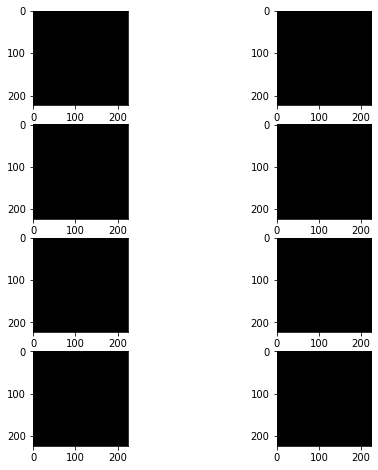

Target reconstructed images:


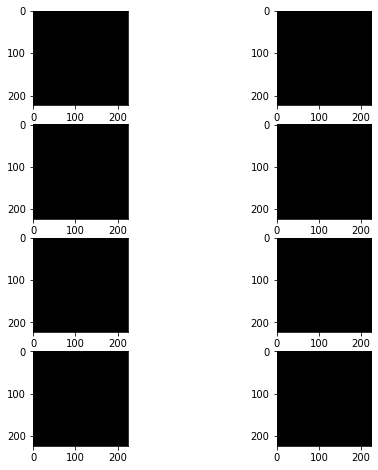

_______________________________________________________________
Epoch 22/60
LOSS SOURCE: 5.707675457000732,
 LOSS TARGET: 0.7582141757011414
_______________________________________________________________
Epoch 23/60
LOSS SOURCE: 5.582857131958008,
 LOSS TARGET: 0.9102780222892761
_______________________________________________________________
Epoch 24/60
LOSS SOURCE: 5.337443828582764,
 LOSS TARGET: 0.6895880699157715
_______________________________________________________________
Epoch 25/60
LOSS SOURCE: 5.533356189727783,
 LOSS TARGET: 0.8539706468582153
_______________________________________________________________
Epoch 26/60
LOSS SOURCE: 5.374360084533691,
 LOSS TARGET: 0.7861623167991638
_______________________________________________________________
Epoch 27/60
LOSS SOURCE: 5.37675142288208,
 LOSS TARGET: 0.6740896701812744
_______________________________________________________________
Epoch 28/60
LOSS SOURCE: 5.130862236022949,
 LOSS TARGET: 0.715958297252655
_______________

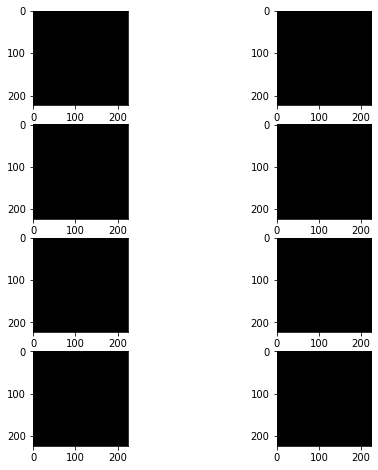

Target reconstructed images:


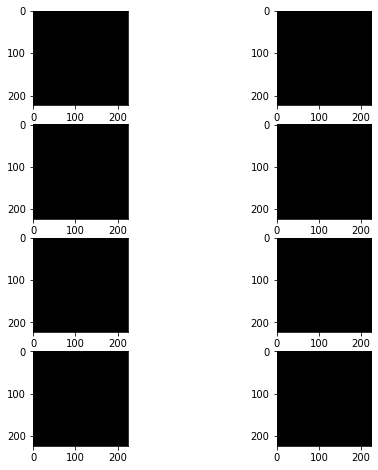

_______________________________________________________________
Epoch 32/60
LOSS SOURCE: 5.407332420349121,
 LOSS TARGET: 0.6918888688087463
_______________________________________________________________
Epoch 33/60
LOSS SOURCE: 5.5374603271484375,
 LOSS TARGET: 0.7388178706169128
_______________________________________________________________
Epoch 34/60
LOSS SOURCE: 5.364931106567383,
 LOSS TARGET: 0.6800770163536072
_______________________________________________________________
Epoch 35/60
LOSS SOURCE: 5.3720479011535645,
 LOSS TARGET: 0.6079221963882446
_______________________________________________________________
Epoch 36/60
LOSS SOURCE: 5.4204421043396,
 LOSS TARGET: 0.9728416800498962
_______________________________________________________________
Epoch 37/60
LOSS SOURCE: 5.409286022186279,
 LOSS TARGET: 0.8418292999267578
_______________________________________________________________
Epoch 38/60
LOSS SOURCE: 5.205917835235596,
 LOSS TARGET: 0.72884202003479
_______________

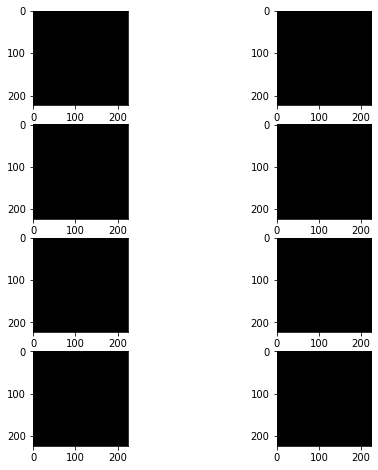

Target reconstructed images:


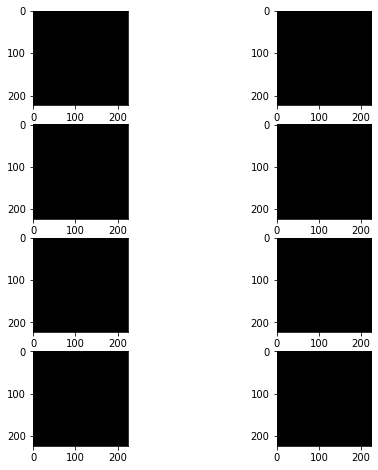

_______________________________________________________________
Epoch 42/60
LOSS SOURCE: 5.499241352081299,
 LOSS TARGET: 0.8772374391555786
_______________________________________________________________
Epoch 43/60
LOSS SOURCE: 5.421602249145508,
 LOSS TARGET: 0.7538689970970154
_______________________________________________________________
Epoch 44/60
LOSS SOURCE: 4.965341091156006,
 LOSS TARGET: 0.6317441463470459
_______________________________________________________________
Epoch 45/60
LOSS SOURCE: 5.508703708648682,
 LOSS TARGET: 0.9712980389595032
_______________________________________________________________
Epoch 46/60
LOSS SOURCE: 5.4339680671691895,
 LOSS TARGET: 0.5520429611206055
_______________________________________________________________
Epoch 47/60
LOSS SOURCE: 5.08526611328125,
 LOSS TARGET: 0.686959981918335
_______________________________________________________________
Epoch 48/60
LOSS SOURCE: 5.482285976409912,
 LOSS TARGET: 0.6577379107475281
______________

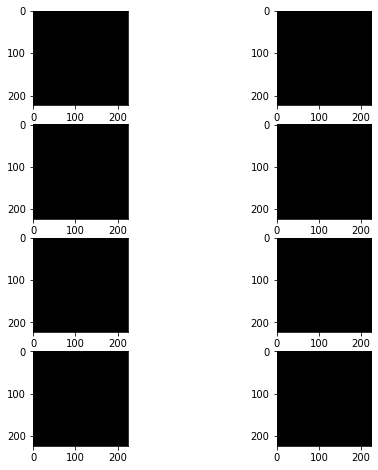

Target reconstructed images:


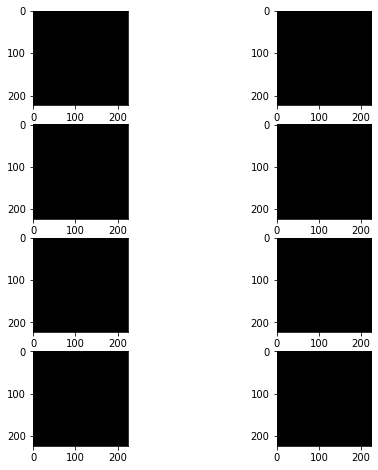

_______________________________________________________________
Epoch 52/60
LOSS SOURCE: 5.301137447357178,
 LOSS TARGET: 0.6598145365715027
_______________________________________________________________
Epoch 53/60
LOSS SOURCE: 5.169438362121582,
 LOSS TARGET: 0.6385455131530762
_______________________________________________________________
Epoch 54/60
LOSS SOURCE: 5.432136535644531,
 LOSS TARGET: 0.7481037974357605
_______________________________________________________________
Epoch 55/60
LOSS SOURCE: 5.388537883758545,
 LOSS TARGET: 0.8032576441764832
_______________________________________________________________
Epoch 56/60
LOSS SOURCE: 5.375258922576904,
 LOSS TARGET: 0.764802873134613
_______________________________________________________________
Epoch 57/60
LOSS SOURCE: 5.50888729095459,
 LOSS TARGET: 0.7996429800987244
_______________________________________________________________
Epoch 58/60
LOSS SOURCE: 5.255972385406494,
 LOSS TARGET: 0.7113835215568542
_______________

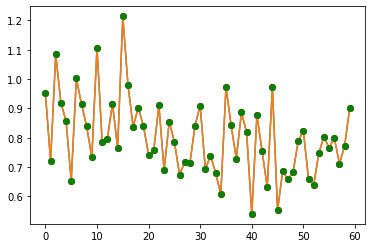

In [ ]:
#  NON PRETRAINED 
LT , LS, xS_recon, xT_recon = main(train_target, train_source, test_target, 60, autoencoder_T, autoencoder_S, "Depict_Reall_Source_Prod_Target", True)
### PLOT LOSS TARGET ###
x_val_T = [x[0] for x in LT] #Epochs
y_val_T = [x[1].cpu() for x in LT] #Loss value
x_val_S = [x[0] for x in LS] #Epochs
y_val_S = [x[1].cpu() for x in LS] #Loss value
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'or')
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'og')
plt.show()

_______________________________________________________________
Epoch 1/200
LOSS SOURCE: 53.73857116699219,
 LOSS TARGET: 2.402015209197998
Source reconstructed images:


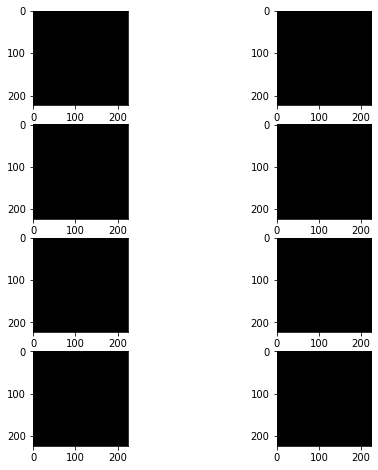

Target reconstructed images:


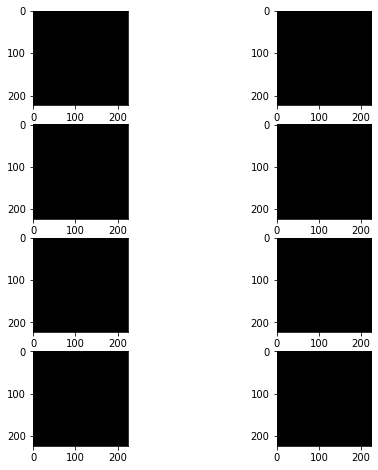

_______________________________________________________________
Epoch 2/200
LOSS SOURCE: 14.80257511138916,
 LOSS TARGET: 1.8089895248413086
_______________________________________________________________
Epoch 3/200
LOSS SOURCE: 8.847291946411133,
 LOSS TARGET: 1.5985273122787476
_______________________________________________________________
Epoch 4/200
LOSS SOURCE: 6.967528820037842,
 LOSS TARGET: 1.1730024814605713
_______________________________________________________________
Epoch 5/200
LOSS SOURCE: 6.87266731262207,
 LOSS TARGET: 1.9886908531188965
_______________________________________________________________
Epoch 6/200
LOSS SOURCE: 6.36802339553833,
 LOSS TARGET: 1.465550422668457
_______________________________________________________________
Epoch 7/200
LOSS SOURCE: 6.467405319213867,
 LOSS TARGET: 1.5220046043395996
_______________________________________________________________
Epoch 8/200
LOSS SOURCE: 6.107278823852539,
 LOSS TARGET: 1.1763625144958496
________________

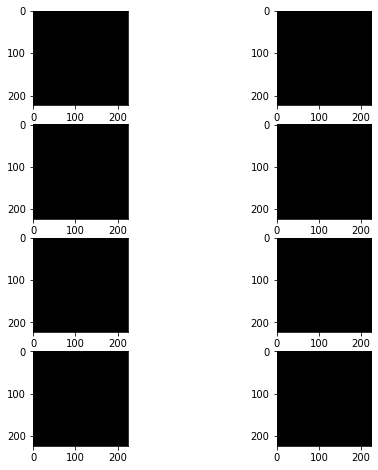

Target reconstructed images:


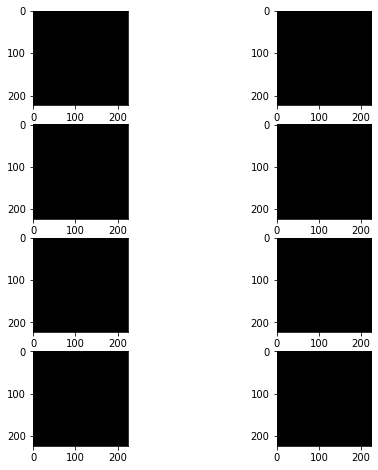

_______________________________________________________________
Epoch 12/200
LOSS SOURCE: 5.672499179840088,
 LOSS TARGET: 0.8974590301513672
_______________________________________________________________
Epoch 13/200
LOSS SOURCE: 6.55661153793335,
 LOSS TARGET: 1.0208487510681152
_______________________________________________________________
Epoch 14/200
LOSS SOURCE: 5.416265964508057,
 LOSS TARGET: 1.100436806678772
_______________________________________________________________
Epoch 15/200
LOSS SOURCE: 5.849696159362793,
 LOSS TARGET: 1.0108188390731812
_______________________________________________________________
Epoch 16/200
LOSS SOURCE: 5.8945817947387695,
 LOSS TARGET: 0.9344640970230103
_______________________________________________________________
Epoch 17/200
LOSS SOURCE: 6.152810573577881,
 LOSS TARGET: 0.9546844363212585
_______________________________________________________________
Epoch 18/200
LOSS SOURCE: 5.527649879455566,
 LOSS TARGET: 1.0319981575012207
_______

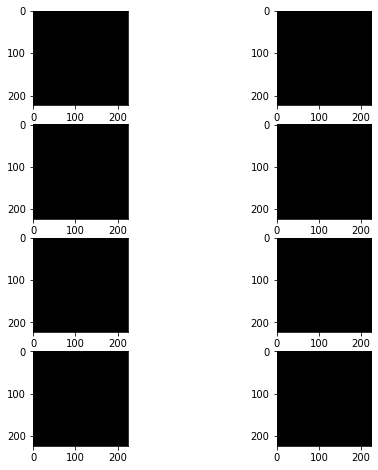

Target reconstructed images:


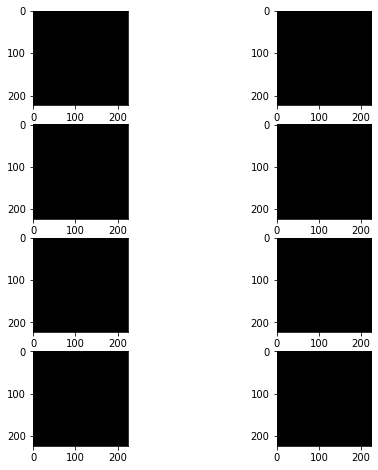

_______________________________________________________________
Epoch 22/200
LOSS SOURCE: 5.504176139831543,
 LOSS TARGET: 0.899778425693512
_______________________________________________________________
Epoch 23/200
LOSS SOURCE: 5.648966312408447,
 LOSS TARGET: 1.1388121843338013
_______________________________________________________________
Epoch 24/200
LOSS SOURCE: 5.347093105316162,
 LOSS TARGET: 0.851108193397522
_______________________________________________________________
Epoch 25/200
LOSS SOURCE: 5.631753444671631,
 LOSS TARGET: 1.047027826309204
_______________________________________________________________
Epoch 26/200
LOSS SOURCE: 5.167063236236572,
 LOSS TARGET: 0.8449198603630066
_______________________________________________________________
Epoch 27/200
LOSS SOURCE: 5.377501487731934,
 LOSS TARGET: 1.2244155406951904
_______________________________________________________________
Epoch 28/200
LOSS SOURCE: 5.2552361488342285,
 LOSS TARGET: 1.0440815687179565
________

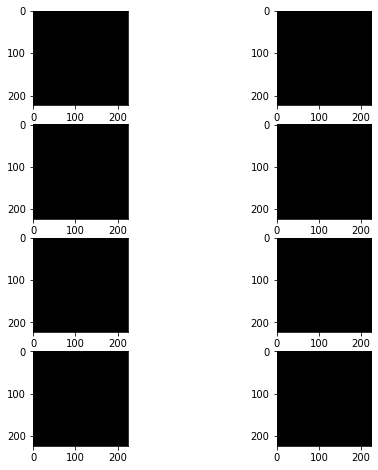

Target reconstructed images:


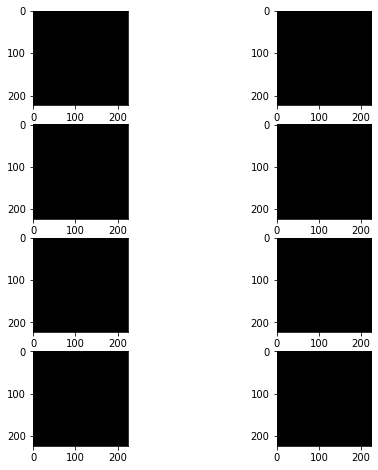

_______________________________________________________________
Epoch 32/200
LOSS SOURCE: 5.420506000518799,
 LOSS TARGET: 0.958352267742157
_______________________________________________________________
Epoch 33/200
LOSS SOURCE: 5.626904010772705,
 LOSS TARGET: 1.07375168800354
_______________________________________________________________
Epoch 34/200
LOSS SOURCE: 5.705588340759277,
 LOSS TARGET: 0.8601495027542114
_______________________________________________________________
Epoch 35/200
LOSS SOURCE: 5.602059364318848,
 LOSS TARGET: 1.0405129194259644
_______________________________________________________________
Epoch 36/200
LOSS SOURCE: 5.595829486846924,
 LOSS TARGET: 0.8757392168045044
_______________________________________________________________
Epoch 37/200
LOSS SOURCE: 5.887150764465332,
 LOSS TARGET: 0.7233225107192993
_______________________________________________________________
Epoch 38/200
LOSS SOURCE: 5.6430206298828125,
 LOSS TARGET: 1.043674111366272
_________

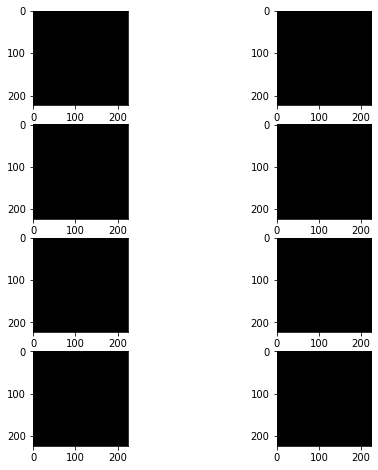

Target reconstructed images:


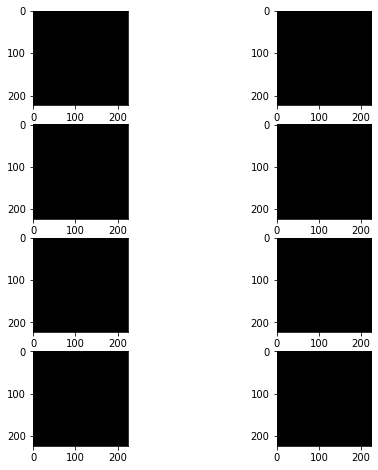

_______________________________________________________________
Epoch 42/200
LOSS SOURCE: 5.578982353210449,
 LOSS TARGET: 0.7253310680389404
_______________________________________________________________
Epoch 43/200
LOSS SOURCE: 5.169769287109375,
 LOSS TARGET: 0.8038326501846313
_______________________________________________________________
Epoch 44/200
LOSS SOURCE: 5.358504772186279,
 LOSS TARGET: 0.7036612629890442
_______________________________________________________________
Epoch 45/200
LOSS SOURCE: 5.6420183181762695,
 LOSS TARGET: 0.8734656572341919
_______________________________________________________________
Epoch 46/200
LOSS SOURCE: 5.417700290679932,
 LOSS TARGET: 0.899848461151123
_______________________________________________________________
Epoch 47/200
LOSS SOURCE: 5.462411403656006,
 LOSS TARGET: 0.8875810503959656
_______________________________________________________________
Epoch 48/200
LOSS SOURCE: 6.301034450531006,
 LOSS TARGET: 0.6957098841667175
______

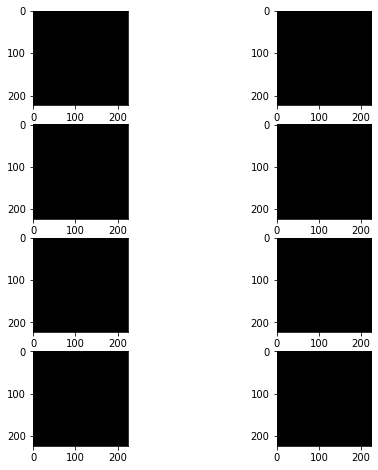

Target reconstructed images:


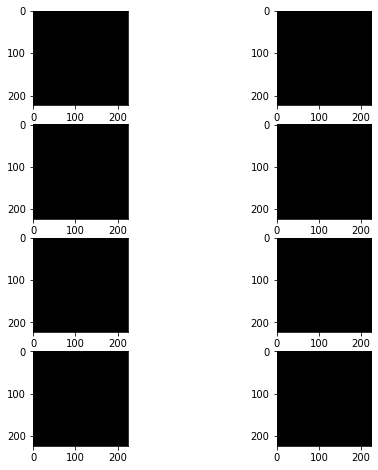

_______________________________________________________________
Epoch 52/200
LOSS SOURCE: 5.702288627624512,
 LOSS TARGET: 0.9725967645645142
_______________________________________________________________
Epoch 53/200
LOSS SOURCE: 5.152003765106201,
 LOSS TARGET: 0.9198580384254456
_______________________________________________________________
Epoch 54/200
LOSS SOURCE: 5.642914295196533,
 LOSS TARGET: 0.8378192782402039
_______________________________________________________________
Epoch 55/200
LOSS SOURCE: 5.096246242523193,
 LOSS TARGET: 0.9039978384971619
_______________________________________________________________
Epoch 56/200
LOSS SOURCE: 5.308631896972656,
 LOSS TARGET: 0.8746669888496399
_______________________________________________________________
Epoch 57/200
LOSS SOURCE: 5.296856880187988,
 LOSS TARGET: 0.7820633053779602
_______________________________________________________________
Epoch 58/200
LOSS SOURCE: 5.2393269538879395,
 LOSS TARGET: 1.0114498138427734
_____

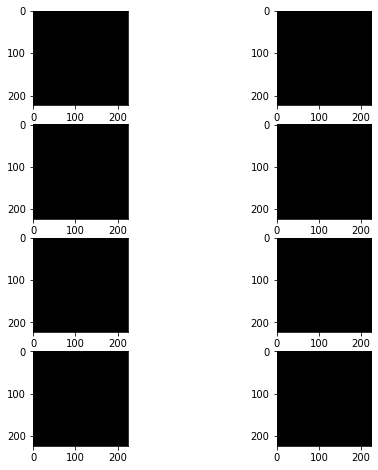

Target reconstructed images:


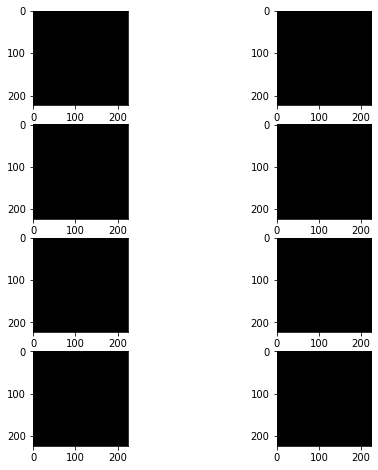

_______________________________________________________________
Epoch 62/200
LOSS SOURCE: 5.311000823974609,
 LOSS TARGET: 1.0819764137268066
_______________________________________________________________
Epoch 63/200
LOSS SOURCE: 4.8781208992004395,
 LOSS TARGET: 0.8324496150016785
_______________________________________________________________
Epoch 64/200
LOSS SOURCE: 5.352639675140381,
 LOSS TARGET: 0.8013843297958374
_______________________________________________________________
Epoch 65/200
LOSS SOURCE: 5.145812034606934,
 LOSS TARGET: 1.0164539813995361
_______________________________________________________________
Epoch 66/200
LOSS SOURCE: 5.238160610198975,
 LOSS TARGET: 0.8980440497398376
_______________________________________________________________
Epoch 67/200
LOSS SOURCE: 5.2371368408203125,
 LOSS TARGET: 1.0447882413864136
_______________________________________________________________
Epoch 68/200
LOSS SOURCE: 5.6601176261901855,
 LOSS TARGET: 0.7792347073554993
___

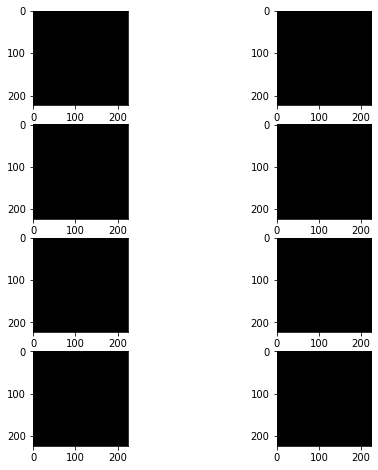

Target reconstructed images:


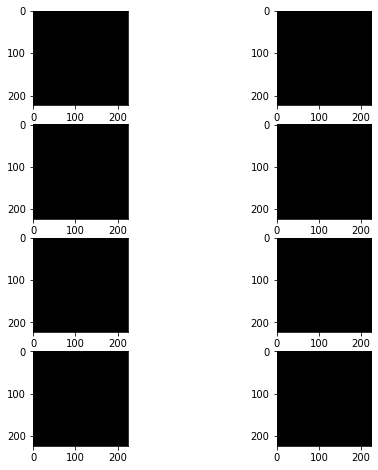

_______________________________________________________________
Epoch 72/200
LOSS SOURCE: 5.50808048248291,
 LOSS TARGET: 0.6874085068702698
_______________________________________________________________
Epoch 73/200
LOSS SOURCE: 5.476150035858154,
 LOSS TARGET: 0.8804047107696533
_______________________________________________________________
Epoch 74/200
LOSS SOURCE: 5.3685407638549805,
 LOSS TARGET: 0.6296707987785339
_______________________________________________________________
Epoch 75/200
LOSS SOURCE: 5.271843433380127,
 LOSS TARGET: 0.7123478651046753
_______________________________________________________________
Epoch 76/200


In [ ]:
##  NON PRETRAINED 
LT , LS, xS_recon, xT_recon = main(train_source, train_target, test_source, 200, autoencoder_T, autoencoder_S, "Depict_Prod_Source_Reall_Target", False)

### PLOT LOSS TARGET ###
x_val_T = [x[0] for x in LT] #Epochs
y_val_T = [x[1].cpu() for x in LT] #Loss value
x_val_S = [x[0] for x in LS] #Epochs
y_val_S = [x[1].cpu() for x in LS] #Loss value
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'or')
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'og')
plt.show()

dict_keys(['epoch', 'model_state_dict', 'loss', 'optimizer_state_dict'])
dict_keys(['epoch', 'model_state_dict', 'loss', 'optimizer_state_dict'])
_______________________________________________________________
Epoch 1/151
LOSS SOURCE: 5.810139179229736,
 LOSS TARGET: 0.8996462821960449
Source reconstructed images:


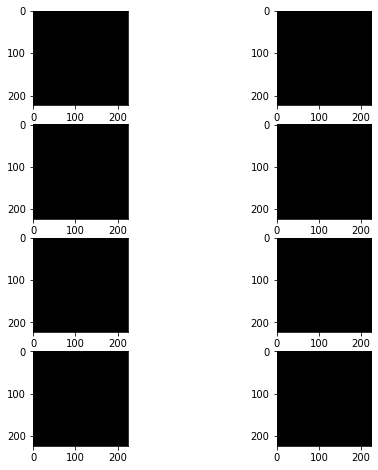

Target reconstructed images:


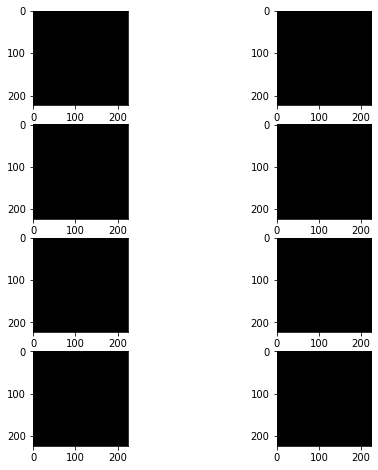

_______________________________________________________________
Epoch 2/151
LOSS SOURCE: 5.172945976257324,
 LOSS TARGET: 0.933748722076416
_______________________________________________________________
Epoch 3/151
LOSS SOURCE: 5.5247931480407715,
 LOSS TARGET: 0.8442586660385132
_______________________________________________________________
Epoch 4/151
LOSS SOURCE: 5.440306186676025,
 LOSS TARGET: 1.0149118900299072
_______________________________________________________________
Epoch 5/151
LOSS SOURCE: 5.151583194732666,
 LOSS TARGET: 0.7056012749671936
_______________________________________________________________
Epoch 6/151
LOSS SOURCE: 5.2344207763671875,
 LOSS TARGET: 1.017722725868225
_______________________________________________________________
Epoch 7/151
LOSS SOURCE: 5.6121721267700195,
 LOSS TARGET: 0.6600863933563232
_______________________________________________________________
Epoch 8/151
LOSS SOURCE: 5.589351654052734,
 LOSS TARGET: 0.7080284357070923
____________

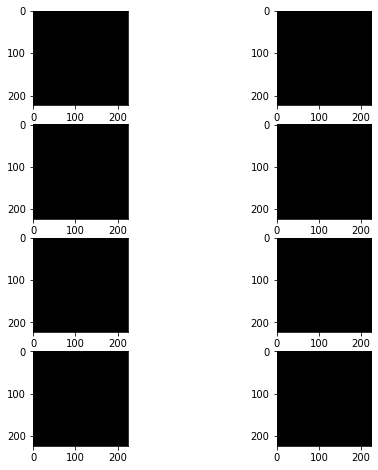

Target reconstructed images:


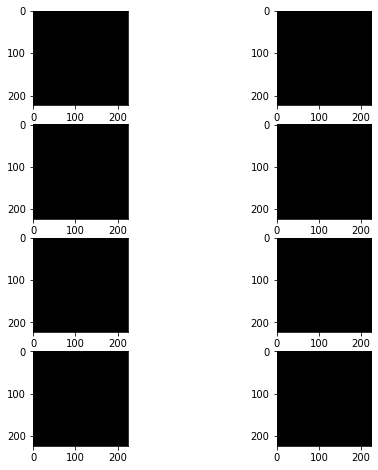

_______________________________________________________________
Epoch 12/151
LOSS SOURCE: 5.559479713439941,
 LOSS TARGET: 0.5619500279426575
_______________________________________________________________
Epoch 13/151
LOSS SOURCE: 5.534631729125977,
 LOSS TARGET: 0.7311967611312866
_______________________________________________________________
Epoch 14/151
LOSS SOURCE: 5.376065254211426,
 LOSS TARGET: 0.949107825756073
_______________________________________________________________
Epoch 15/151
LOSS SOURCE: 5.18973445892334,
 LOSS TARGET: 0.7336040735244751
_______________________________________________________________
Epoch 16/151
LOSS SOURCE: 5.159682273864746,
 LOSS TARGET: 0.6823433041572571
_______________________________________________________________
Epoch 17/151
LOSS SOURCE: 5.478567600250244,
 LOSS TARGET: 0.7953925728797913
_______________________________________________________________
Epoch 18/151
LOSS SOURCE: 5.010392189025879,
 LOSS TARGET: 0.7981427311897278
________

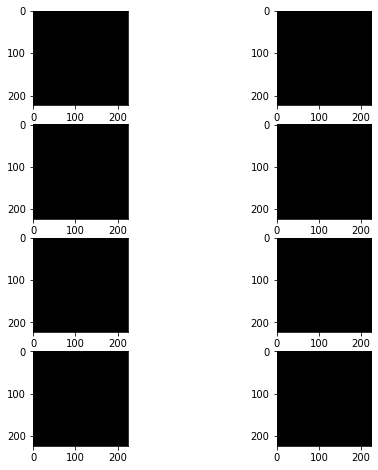

Target reconstructed images:


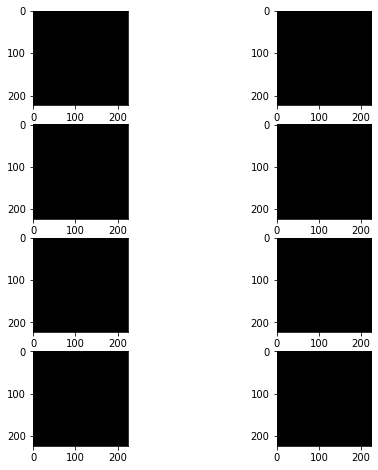

_______________________________________________________________
Epoch 22/151
LOSS SOURCE: 5.367693901062012,
 LOSS TARGET: 0.5822844505310059
_______________________________________________________________
Epoch 23/151
LOSS SOURCE: 5.193471431732178,
 LOSS TARGET: 0.8187605738639832
_______________________________________________________________
Epoch 24/151
LOSS SOURCE: 5.715835094451904,
 LOSS TARGET: 1.084618330001831
_______________________________________________________________
Epoch 25/151
LOSS SOURCE: 5.215211868286133,
 LOSS TARGET: 0.8397113680839539
_______________________________________________________________
Epoch 26/151
LOSS SOURCE: 5.305668354034424,
 LOSS TARGET: 0.9040300846099854
_______________________________________________________________
Epoch 27/151
LOSS SOURCE: 5.22104024887085,
 LOSS TARGET: 0.8512060642242432
_______________________________________________________________
Epoch 28/151
LOSS SOURCE: 5.444532871246338,
 LOSS TARGET: 0.6958762407302856
________

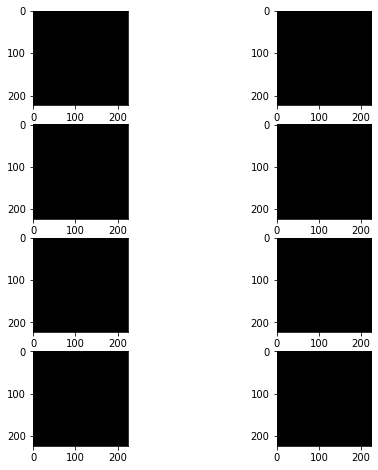

Target reconstructed images:


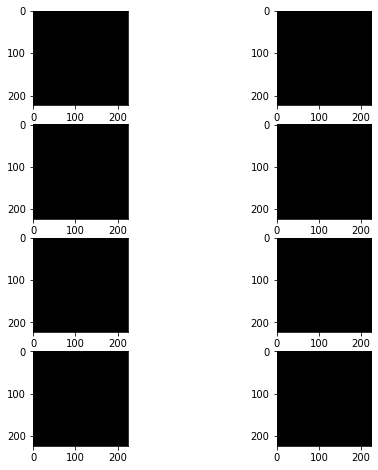

_______________________________________________________________
Epoch 32/151
LOSS SOURCE: 5.510464668273926,
 LOSS TARGET: 0.808012068271637
_______________________________________________________________
Epoch 33/151
LOSS SOURCE: 5.5705742835998535,
 LOSS TARGET: 0.839101254940033
_______________________________________________________________
Epoch 34/151
LOSS SOURCE: 5.675509929656982,
 LOSS TARGET: 0.8834806680679321
_______________________________________________________________
Epoch 35/151
LOSS SOURCE: 5.401622295379639,
 LOSS TARGET: 0.7724905610084534
_______________________________________________________________
Epoch 36/151
LOSS SOURCE: 5.050432205200195,
 LOSS TARGET: 0.5898628234863281
_______________________________________________________________
Epoch 37/151
LOSS SOURCE: 5.359368801116943,
 LOSS TARGET: 0.883301854133606
_______________________________________________________________
Epoch 38/151
LOSS SOURCE: 5.158977508544922,
 LOSS TARGET: 0.5552626252174377
________

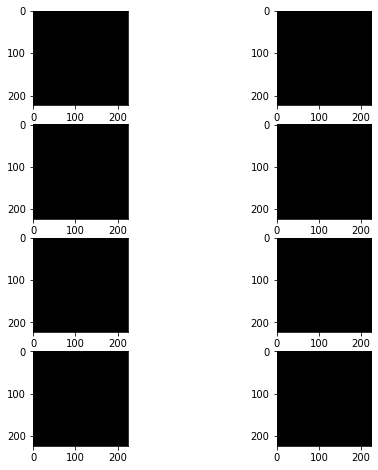

Target reconstructed images:


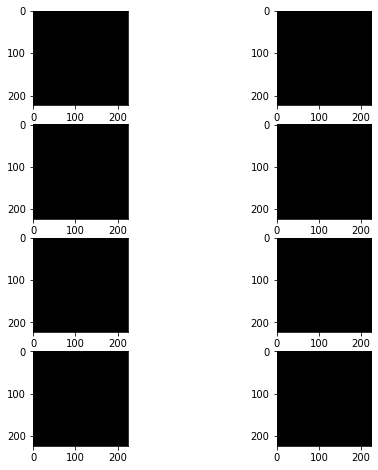

_______________________________________________________________
Epoch 42/151
LOSS SOURCE: 5.247864246368408,
 LOSS TARGET: 0.8757861852645874
_______________________________________________________________
Epoch 43/151
LOSS SOURCE: 6.067621231079102,
 LOSS TARGET: 0.9961529970169067
_______________________________________________________________
Epoch 44/151
LOSS SOURCE: 5.675262928009033,
 LOSS TARGET: 0.8349952697753906
_______________________________________________________________
Epoch 45/151
LOSS SOURCE: 5.355067253112793,
 LOSS TARGET: 0.6542081832885742
_______________________________________________________________
Epoch 46/151
LOSS SOURCE: 5.320575714111328,
 LOSS TARGET: 0.6390045881271362
_______________________________________________________________
Epoch 47/151
LOSS SOURCE: 5.306434154510498,
 LOSS TARGET: 0.6748619079589844
_______________________________________________________________
Epoch 48/151
LOSS SOURCE: 5.646328449249268,
 LOSS TARGET: 1.0739977359771729
______

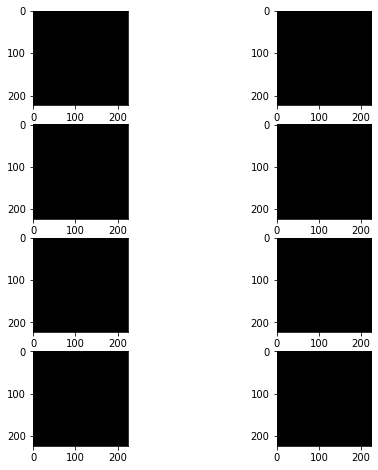

Target reconstructed images:


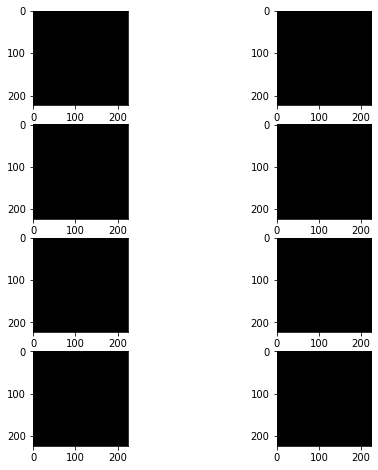

_______________________________________________________________
Epoch 52/151
LOSS SOURCE: 5.144091606140137,
 LOSS TARGET: 0.8679388761520386
_______________________________________________________________
Epoch 53/151
LOSS SOURCE: 5.509433746337891,
 LOSS TARGET: 0.8041388988494873
_______________________________________________________________
Epoch 54/151
LOSS SOURCE: 5.5984787940979,
 LOSS TARGET: 0.9890936017036438
_______________________________________________________________
Epoch 55/151
LOSS SOURCE: 5.5421462059021,
 LOSS TARGET: 0.8778750896453857
_______________________________________________________________
Epoch 56/151
LOSS SOURCE: 5.249199867248535,
 LOSS TARGET: 0.6949986219406128
_______________________________________________________________
Epoch 57/151
LOSS SOURCE: 5.807572841644287,
 LOSS TARGET: 0.6724601984024048
_______________________________________________________________
Epoch 58/151
LOSS SOURCE: 5.386200904846191,
 LOSS TARGET: 0.5902084112167358
__________

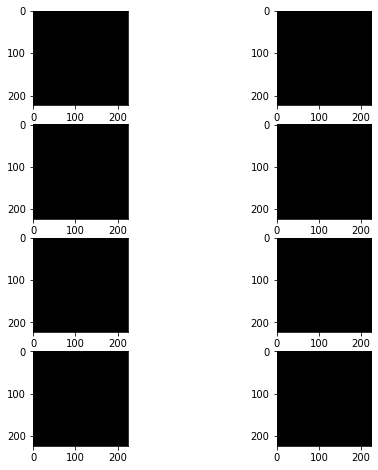

Target reconstructed images:


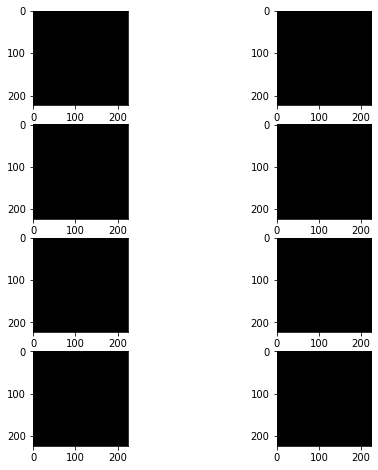

_______________________________________________________________
Epoch 62/151
LOSS SOURCE: 5.248570919036865,
 LOSS TARGET: 0.8281898498535156
_______________________________________________________________
Epoch 63/151
LOSS SOURCE: 5.359664440155029,
 LOSS TARGET: 0.7640729546546936
_______________________________________________________________
Epoch 64/151
LOSS SOURCE: 5.3917236328125,
 LOSS TARGET: 0.6906099915504456
_______________________________________________________________
Epoch 65/151
LOSS SOURCE: 5.788540840148926,
 LOSS TARGET: 0.9339141845703125
_______________________________________________________________
Epoch 66/151
LOSS SOURCE: 5.484365940093994,
 LOSS TARGET: 0.8517562747001648
_______________________________________________________________
Epoch 67/151
LOSS SOURCE: 5.053088665008545,
 LOSS TARGET: 0.6796196103096008
_______________________________________________________________
Epoch 68/151
LOSS SOURCE: 5.327108383178711,
 LOSS TARGET: 0.7407885789871216
________

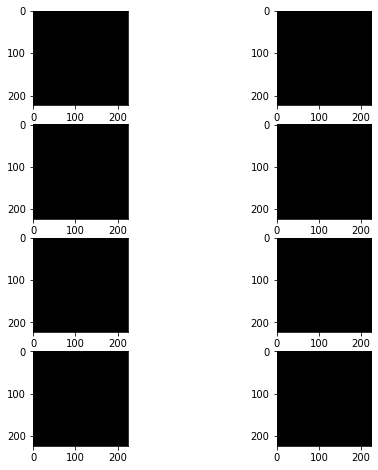

Target reconstructed images:


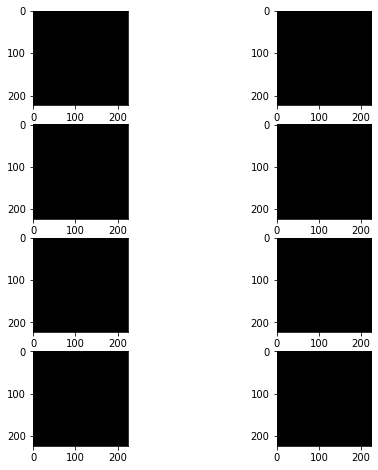

_______________________________________________________________
Epoch 72/151
LOSS SOURCE: 5.752774715423584,
 LOSS TARGET: 0.8583663702011108
_______________________________________________________________
Epoch 73/151
LOSS SOURCE: 4.976590633392334,
 LOSS TARGET: 0.8692683577537537
_______________________________________________________________
Epoch 74/151
LOSS SOURCE: 5.379179954528809,
 LOSS TARGET: 0.8474029302597046
_______________________________________________________________
Epoch 75/151
LOSS SOURCE: 5.5561203956604,
 LOSS TARGET: 0.7726434469223022
_______________________________________________________________
Epoch 76/151
LOSS SOURCE: 5.361576080322266,
 LOSS TARGET: 0.8909507393836975
_______________________________________________________________
Epoch 77/151
LOSS SOURCE: 5.113136291503906,
 LOSS TARGET: 0.7660275101661682
_______________________________________________________________
Epoch 78/151
LOSS SOURCE: 5.570243835449219,
 LOSS TARGET: 0.7239974141120911
________

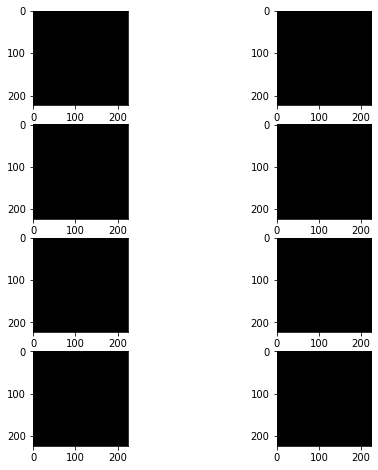

Target reconstructed images:


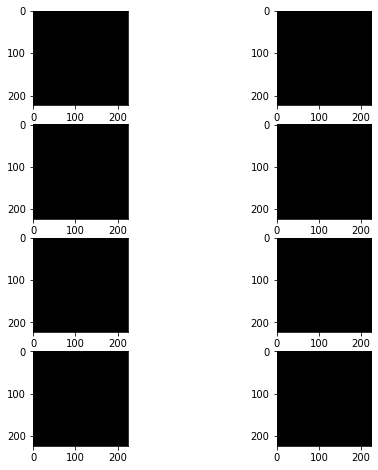

_______________________________________________________________
Epoch 82/151
LOSS SOURCE: 5.886704921722412,
 LOSS TARGET: 0.6101554036140442
_______________________________________________________________
Epoch 83/151
LOSS SOURCE: 5.469804286956787,
 LOSS TARGET: 0.775218665599823
_______________________________________________________________
Epoch 84/151
LOSS SOURCE: 5.561160564422607,
 LOSS TARGET: 0.7646636962890625
_______________________________________________________________
Epoch 85/151
LOSS SOURCE: 5.241121768951416,
 LOSS TARGET: 0.8169761300086975
_______________________________________________________________
Epoch 86/151
LOSS SOURCE: 5.1843156814575195,
 LOSS TARGET: 0.65346360206604
_______________________________________________________________
Epoch 87/151
LOSS SOURCE: 5.574436187744141,
 LOSS TARGET: 0.609386146068573
_______________________________________________________________
Epoch 88/151
LOSS SOURCE: 5.513064861297607,
 LOSS TARGET: 0.6251534223556519
_________

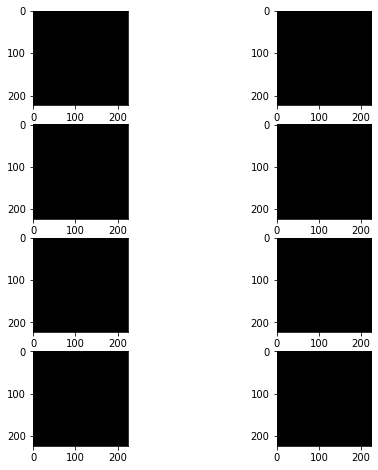

Target reconstructed images:


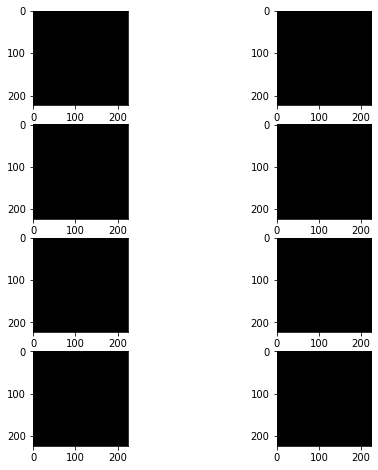

_______________________________________________________________
Epoch 92/151
LOSS SOURCE: 5.423832893371582,
 LOSS TARGET: 0.8969605565071106
_______________________________________________________________
Epoch 93/151
LOSS SOURCE: 4.885976791381836,
 LOSS TARGET: 0.7099382877349854
_______________________________________________________________
Epoch 94/151
LOSS SOURCE: 5.449450969696045,
 LOSS TARGET: 0.8118640184402466
_______________________________________________________________
Epoch 95/151
LOSS SOURCE: 5.263895034790039,
 LOSS TARGET: 0.646435022354126
_______________________________________________________________
Epoch 96/151
LOSS SOURCE: 5.5173211097717285,
 LOSS TARGET: 0.5149229764938354
_______________________________________________________________
Epoch 97/151
LOSS SOURCE: 5.1122541427612305,
 LOSS TARGET: 0.909027099609375
_______________________________________________________________
Epoch 98/151
LOSS SOURCE: 5.540493965148926,
 LOSS TARGET: 0.6146062016487122
______

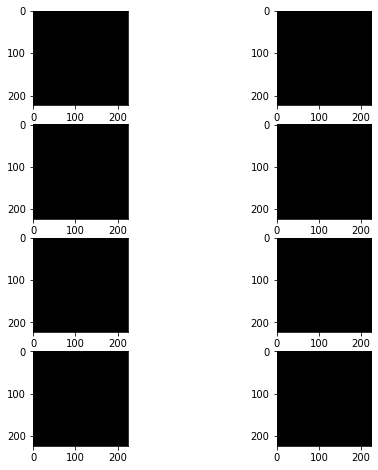

Target reconstructed images:


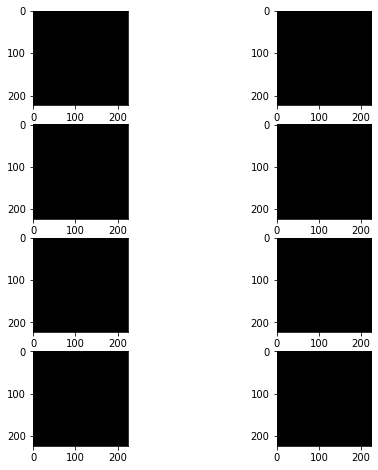

_______________________________________________________________
Epoch 102/151
LOSS SOURCE: 5.385141372680664,
 LOSS TARGET: 0.8780269026756287
_______________________________________________________________
Epoch 103/151
LOSS SOURCE: 5.241961479187012,
 LOSS TARGET: 0.7668715119361877
_______________________________________________________________
Epoch 104/151
LOSS SOURCE: 5.278468608856201,
 LOSS TARGET: 0.7774579524993896
_______________________________________________________________
Epoch 105/151
LOSS SOURCE: 5.272749423980713,
 LOSS TARGET: 0.8070743083953857
_______________________________________________________________
Epoch 106/151
LOSS SOURCE: 6.042193412780762,
 LOSS TARGET: 0.6850153803825378
_______________________________________________________________
Epoch 107/151
LOSS SOURCE: 5.038527011871338,
 LOSS TARGET: 0.7454678416252136
_______________________________________________________________
Epoch 108/151
LOSS SOURCE: 5.328829288482666,
 LOSS TARGET: 0.8006311058998108

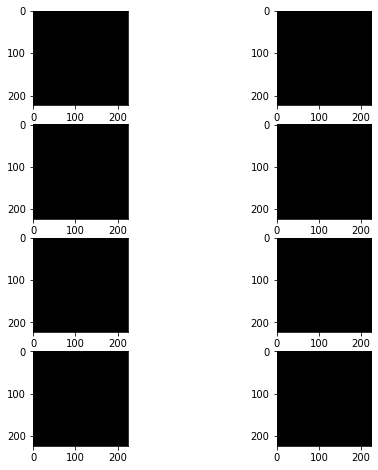

Target reconstructed images:


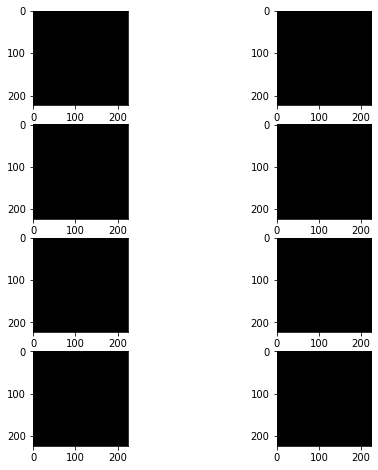

_______________________________________________________________
Epoch 112/151
LOSS SOURCE: 5.271788597106934,
 LOSS TARGET: 0.6919263601303101
_______________________________________________________________
Epoch 113/151
LOSS SOURCE: 5.220385551452637,
 LOSS TARGET: 0.7164961695671082
_______________________________________________________________
Epoch 114/151
LOSS SOURCE: 5.5183491706848145,
 LOSS TARGET: 0.7460879683494568
_______________________________________________________________
Epoch 115/151
LOSS SOURCE: 5.561560153961182,
 LOSS TARGET: 0.7776370048522949
_______________________________________________________________
Epoch 116/151
LOSS SOURCE: 5.33831262588501,
 LOSS TARGET: 0.9180669784545898
_______________________________________________________________
Epoch 117/151
LOSS SOURCE: 5.19488525390625,
 LOSS TARGET: 0.8319640159606934
_______________________________________________________________
Epoch 118/151
LOSS SOURCE: 5.206674098968506,
 LOSS TARGET: 0.5285542011260986


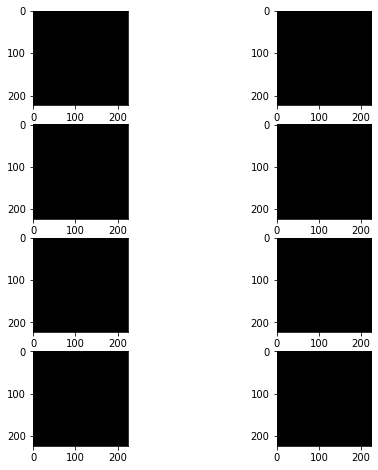

Target reconstructed images:


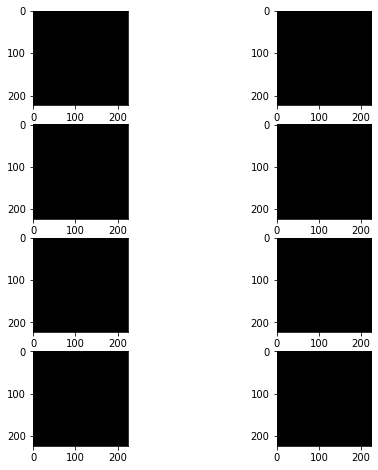

_______________________________________________________________
Epoch 122/151
LOSS SOURCE: 5.2249531745910645,
 LOSS TARGET: 0.7133631706237793
_______________________________________________________________
Epoch 123/151
LOSS SOURCE: 5.494180679321289,
 LOSS TARGET: 0.848028838634491
_______________________________________________________________
Epoch 124/151
LOSS SOURCE: 5.154219150543213,
 LOSS TARGET: 0.8190197348594666
_______________________________________________________________
Epoch 125/151
LOSS SOURCE: 5.153013706207275,
 LOSS TARGET: 0.6230182647705078
_______________________________________________________________
Epoch 126/151
LOSS SOURCE: 5.378347873687744,
 LOSS TARGET: 0.6621261239051819
_______________________________________________________________
Epoch 127/151
LOSS SOURCE: 5.241968154907227,
 LOSS TARGET: 0.7751843929290771
_______________________________________________________________
Epoch 128/151
LOSS SOURCE: 5.642122745513916,
 LOSS TARGET: 0.7640101909637451

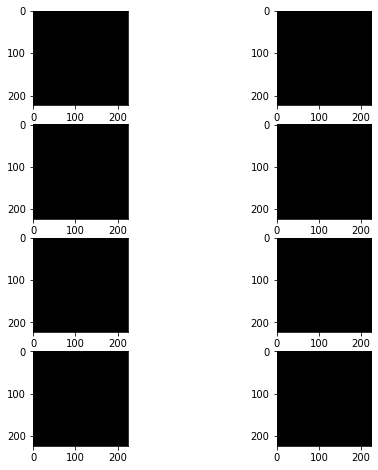

Target reconstructed images:


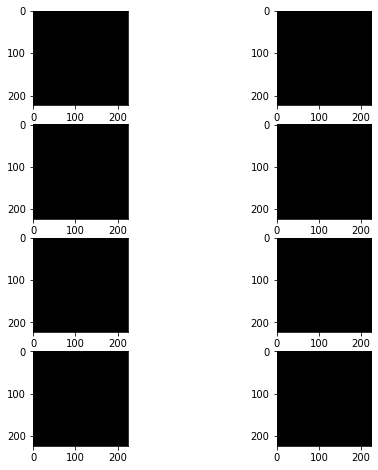

_______________________________________________________________
Epoch 132/151
LOSS SOURCE: 5.3605523109436035,
 LOSS TARGET: 0.7529176473617554
_______________________________________________________________
Epoch 133/151
LOSS SOURCE: 5.06275749206543,
 LOSS TARGET: 0.9017148017883301
_______________________________________________________________
Epoch 134/151
LOSS SOURCE: 5.107757091522217,
 LOSS TARGET: 0.7294492721557617
_______________________________________________________________
Epoch 135/151
LOSS SOURCE: 5.194539546966553,
 LOSS TARGET: 0.5493015646934509
_______________________________________________________________
Epoch 136/151
LOSS SOURCE: 5.2393670082092285,
 LOSS TARGET: 0.644197940826416
_______________________________________________________________
Epoch 137/151
LOSS SOURCE: 5.513227939605713,
 LOSS TARGET: 0.6986908316612244
_______________________________________________________________
Epoch 138/151
LOSS SOURCE: 5.094228744506836,
 LOSS TARGET: 0.6462027430534363

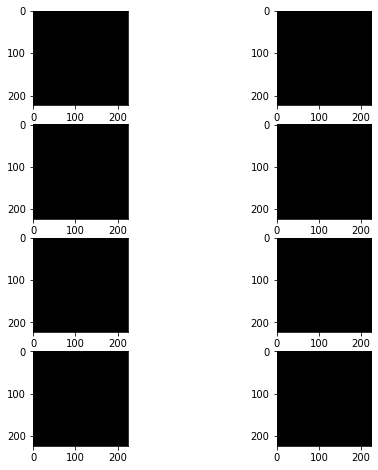

Target reconstructed images:


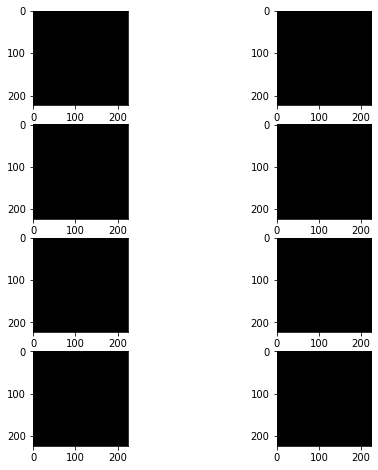

_______________________________________________________________
Epoch 142/151
LOSS SOURCE: 5.783596515655518,
 LOSS TARGET: 0.8599862456321716
_______________________________________________________________
Epoch 143/151
LOSS SOURCE: 5.506515979766846,
 LOSS TARGET: 0.969210147857666
_______________________________________________________________
Epoch 144/151
LOSS SOURCE: 6.087455749511719,
 LOSS TARGET: 0.9243624806404114
_______________________________________________________________
Epoch 145/151
LOSS SOURCE: 5.276920795440674,
 LOSS TARGET: 0.7928799986839294
_______________________________________________________________
Epoch 146/151
LOSS SOURCE: 5.294068336486816,
 LOSS TARGET: 0.8688071966171265
_______________________________________________________________
Epoch 147/151
LOSS SOURCE: 5.199782848358154,
 LOSS TARGET: 0.6829524040222168
_______________________________________________________________
Epoch 148/151
LOSS SOURCE: 5.059770107269287,
 LOSS TARGET: 0.7083828449249268


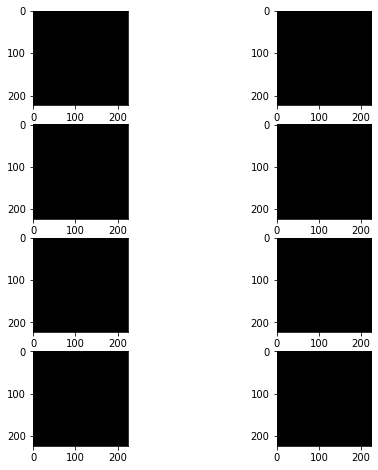

Target reconstructed images:


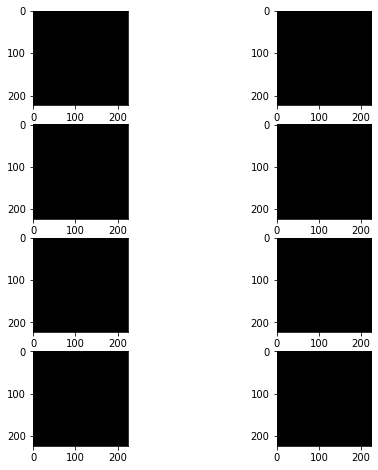

Test loss 268.98822021484375
Accuracy 4.943396226415095


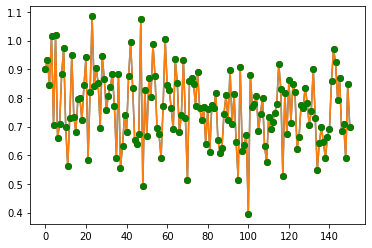

In [ ]:
optimizer = Optimizer(autoencoder_T)
autoencoder_T, optimizer_T, epoch = resume_checkpoint(autoencoder_T,75, optimizer, "drive/MyDrive/DL_Project/checkpoint_Model_Depict_Prod_Source_Reall_Target_T", True) 
autoencoder_S, optimizer_S, epoch = resume_checkpoint(autoencoder_S,75, optimizer, "drive/MyDrive/DL_Project/checkpoint_Model_Depict_Prod_Source_Reall_Target_S", True) 

#  NON PRETRAINED 
LT , LS, xS_recon, xT_recon = main(train_target, train_source, test_target, 151, autoencoder_T, autoencoder_S, "Depict_Reall_Source_Prod_Target", True)
### PLOT LOSS TARGET ###
x_val_T = [x[0] for x in LT] #Epochs
y_val_T = [x[1].cpu() for x in LT] #Loss value
x_val_S = [x[0] for x in LS] #Epochs
y_val_S = [x[1].cpu() for x in LS] #Loss value
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'or')
plt.plot(x_val_T,y_val_T)
plt.plot(x_val_T,y_val_T,'og')
plt.show()

Both the assumption of introducing some further hyperparameters such as different $\lambda$s weighting each loss, as well as assuming that the network outputted logarithmic probabilities allowed to get both correct probability distributions, as well as a positive KLDivergence. Nonetheless, given that the scope of the algorithm was not to reconstruct clear images but to generalize its feature space, reconstructed images keep being black. 

There are some limitations to this algorithm, which is mainly not exploiting the soft-label assignments which can be deduced by the target domain, as well as not taking directly advantage of the KMeans clustering. 

Combined information in the loss for both the SRDC and DEPICT overloads the network, which does not learn to discriminate and generalize features correctly, thus returning very low. This also depends on the fact that the model is trained on a very low batch size, combined with very little images (although augmented). This approach inhibits generalization. 


## Conclusion

To conclude, no **gain** can be computed since all presented models to not perform better than the given baseline. This can be recriminated over several issues not only within the base reasoning over which the code has been written, but lack of computational power as well. Only fine-tuning the Resn-Net Backbone with Kmeans produced similar outcomes to the ones of the basic-resnet, with a better feature representation. 

Starting from the implementation issues: 
+ No clear algorithm among SRDC and Depict has been chosen. Instead, a clear merge among the two by following their backbone ideas has been used. Therefore, instead of optimizing one clear algorithm, two blurry ones were united and conveyed information did not yield increased advantages in training. 

  Namely, the SRDC algorithm only introduces an auxiliary
distribution, and then minimizes the KL divergence between the introduced one and the predictive label distribution of the network. The auxiliary distribution is replaced with that of ground-truth labels of source data, and structural source regularization  is achieved via a
simple strategy of joint network training. 

  On the other hand, the DEPICT algorithm uses clustering to align the feature spaces of the source and target domains, and then uses the cluster assignments as soft targets to fine-tune the CAE on the target domain data. Clustering is accomplished  on the feature representations of the source domain data, and then the cluster assignments are used to create soft targets for the target domain data. The Autoencoder is then fine-tuned on the target domain data using these soft targets. The idea is that by using clustering to align the feature spaces of the source and target domains, the CAE can learn to extract more domain-invariant features, which can improve its performance on the target domain.

+ Batch size was too small: having a batch size of 8 is not much different than directly using SDG, with its limitations. Namely, a very noisy and unstable gradient, which is not able to generalize well as each pass happens too frequently. Although this noise can also be good, by helping to get to a good local minimia, it also prevents the descent from fully converging to an optima at all.
+ Learning rate issues: given the depth of the algorithm a very small learning rate had to be used. This yields to a long training process that could get stuck. Therefore, small learning rates combined with small batch size and small training dataset hinders training. This is also the reason why Kmeans fine-tuning or even training jointly on ResNet18 worked better than these models from scratch: they were pre-trained and only some fine-tuning was performed. 
+ Additionally, although the idea of using the reconstruction loss as a regularizer could have enhanced training, the goal wasn't to reconstruct images as they where but being able to return generalized features that would have allowed the model to perform clustering better and align target and source features. However, the scope of the reconstruction loss itself is to measure the distance between the input and the output and to minimize it. These changes of information could have been non-trivial and poorly handled during the writing of the training function. 
+ To stabilize training, BatchNorm and LayerNorm have also been tried (where BatchNorm normalizes each feature independently over the mini-batch, and LayerNorm only normalized the distribution of the intermediate layers, but enables the features non to be dependent on batch statistics). However, no serious improvement in performance has been reached, by getting accuracies around 0%. 

One last limit was the computational power to train the autoencoder on. Namely, further processing and augmentation could be provided, as well as passing to the training algorithm larger batch sizes to enhance generalization. Furthermore, the model would need to be trained on more than 200 epochs. 

Therefore, although the idea of improving ResNet18's generalization capabilities has proved to push similar features closeby, this is not sufficient nor better than other state of the art models that could have been approached. 

